## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 614)
Hypercube shape: (512, 614, 176)


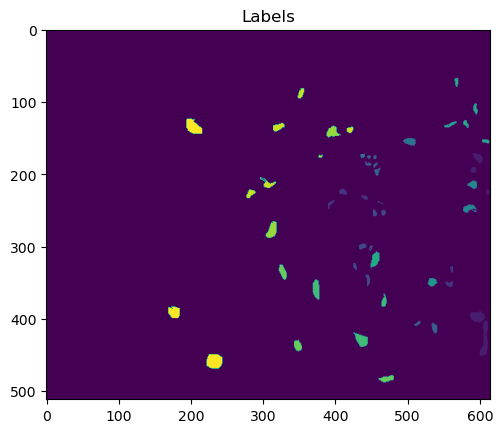

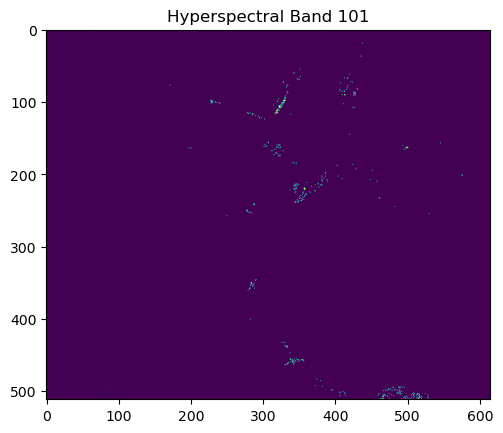

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'KSC_gt.mat'
data_files = 'KSC.mat'
label_files = 'KSC_gt'
hypercube_files = 'KSC'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 5211
Extracted windows shape: (5211, 5, 5, 176)
Corresponding labels shape: (5211,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 761 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 243 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 256 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 252 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 161 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 229 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 105 samples
Shuffled class indices for class '7'
Selected 5


All datasets saved to the 'indices' folder.
(65, 5, 5, 176)
(65, 5, 5, 176)
(5081, 5, 5, 176)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 65
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (4168, 5, 5, 176)
Validation data shape: (1043, 5, 5, 176)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

176


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/66], Loss: 0.2518, PSNR: 5.9891


Epoch [1/50] Training Loss: 0.2406, PSNR: 5.5175
	[Val]   Batch [1/17] Loss: 0.2258, PSNR: 6.4633
	[Val]   Batch [10/17] Loss: 0.2261, PSNR: 6.4568
Epoch [1/50] Validation Loss: 0.2260, PSNR: 6.4598

LOG: Epoch [2/50]
	 Training Batch [1/66], Loss: 0.2207, PSNR: 6.5622


Epoch [2/50] Training Loss: 0.2045, PSNR: 6.8993
	[Val]   Batch [1/17] Loss: 0.1822, PSNR: 7.3954
	[Val]   Batch [10/17] Loss: 0.1845, PSNR: 7.3402
Epoch [2/50] Validation Loss: 0.1836, PSNR: 7.3602

LOG: Epoch [3/50]
	 Training Batch [1/66], Loss: 0.1818, PSNR: 7.4029


Epoch [3/50] Training Loss: 0.1682, PSNR: 7.0706
	[Val]   Batch [1/17] Loss: 0.1461, PSNR: 8.3544
	[Val]   Batch [10/17] Loss: 0.1491, PSNR: 8.2666
Epoch [3/50] Validation Loss: 0.1481, PSNR: 8.2957

LOG: Epoch [4/50]
	 Training Batch [1/66], Loss: 0.1482, PSNR: 8.2909


Epoch [4/50] Training Loss: 0.1357, PSNR: 8.6814
	[Val]   Batch [1/17] Loss: 0.1190, PSNR: 9.2435
	[Val]   Batch [10/17] Loss: 0.1208, PSNR: 9.1793
Epoch [4/50] Validation Loss: 0.1201, PSNR: 9.2053

LOG: Epoch [5/50]
	 Training Batch [1/66], Loss: 0.1188, PSNR: 9.2506


Epoch [5/50] Training Loss: 0.1084, PSNR: 9.6586
	[Val]   Batch [1/17] Loss: 0.0948, PSNR: 10.2311
	[Val]   Batch [10/17] Loss: 0.0962, PSNR: 10.1684
Epoch [5/50] Validation Loss: 0.0956, PSNR: 10.1968

LOG: Epoch [6/50]
	 Training Batch [1/66], Loss: 0.0939, PSNR: 10.2747


Epoch [6/50] Training Loss: 0.0865, PSNR: 9.9590
	[Val]   Batch [1/17] Loss: 0.0766, PSNR: 11.1604
	[Val]   Batch [10/17] Loss: 0.0775, PSNR: 11.1064
Epoch [6/50] Validation Loss: 0.0769, PSNR: 11.1385

LOG: Epoch [7/50]
	 Training Batch [1/66], Loss: 0.0760, PSNR: 11.1937


Epoch [7/50] Training Loss: 0.0696, PSNR: 11.5778
	[Val]   Batch [1/17] Loss: 0.0631, PSNR: 12.0009
	[Val]   Batch [10/17] Loss: 0.0635, PSNR: 11.9723
Epoch [7/50] Validation Loss: 0.0631, PSNR: 11.9984

LOG: Epoch [8/50]
	 Training Batch [1/66], Loss: 0.0613, PSNR: 12.1238


Epoch [8/50] Training Loss: 0.0569, PSNR: 12.4547
	[Val]   Batch [1/17] Loss: 0.0519, PSNR: 12.8480
	[Val]   Batch [10/17] Loss: 0.0522, PSNR: 12.8218
Epoch [8/50] Validation Loss: 0.0519, PSNR: 12.8499

LOG: Epoch [9/50]
	 Training Batch [1/66], Loss: 0.0506, PSNR: 12.9543


Epoch [9/50] Training Loss: 0.0472, PSNR: 13.2660
	[Val]   Batch [1/17] Loss: 0.0432, PSNR: 13.6459
	[Val]   Batch [10/17] Loss: 0.0434, PSNR: 13.6298
Epoch [9/50] Validation Loss: 0.0431, PSNR: 13.6519

LOG: Epoch [10/50]
	 Training Batch [1/66], Loss: 0.0426, PSNR: 13.7093


Epoch [10/50] Training Loss: 0.0398, PSNR: 13.3290
	[Val]   Batch [1/17] Loss: 0.0377, PSNR: 14.2380
	[Val]   Batch [10/17] Loss: 0.0383, PSNR: 14.1706
Epoch [10/50] Validation Loss: 0.0380, PSNR: 14.2077

LOG: Epoch [11/50]
	 Training Batch [1/66], Loss: 0.0361, PSNR: 14.4201


Epoch [11/50] Training Loss: 0.0340, PSNR: 14.6858
	[Val]   Batch [1/17] Loss: 0.0322, PSNR: 14.9220
	[Val]   Batch [10/17] Loss: 0.0322, PSNR: 14.9250
Epoch [11/50] Validation Loss: 0.0321, PSNR: 14.9371

LOG: Epoch [12/50]
	 Training Batch [1/66], Loss: 0.0310, PSNR: 15.0925


Epoch [12/50] Training Loss: 0.0295, PSNR: 15.3050
	[Val]   Batch [1/17] Loss: 0.0278, PSNR: 15.5629
	[Val]   Batch [10/17] Loss: 0.0279, PSNR: 15.5438
Epoch [12/50] Validation Loss: 0.0278, PSNR: 15.5615

LOG: Epoch [13/50]
	 Training Batch [1/66], Loss: 0.0271, PSNR: 15.6656


Epoch [13/50] Training Loss: 0.0258, PSNR: 15.2008
	[Val]   Batch [1/17] Loss: 0.0250, PSNR: 16.0281
	[Val]   Batch [10/17] Loss: 0.0250, PSNR: 16.0139
Epoch [13/50] Validation Loss: 0.0249, PSNR: 16.0298

LOG: Epoch [14/50]
	 Training Batch [1/66], Loss: 0.0242, PSNR: 16.1611


Epoch [14/50] Training Loss: 0.0229, PSNR: 16.3997
	[Val]   Batch [1/17] Loss: 0.0223, PSNR: 16.5204
	[Val]   Batch [10/17] Loss: 0.0224, PSNR: 16.5016
Epoch [14/50] Validation Loss: 0.0223, PSNR: 16.5143

LOG: Epoch [15/50]
	 Training Batch [1/66], Loss: 0.0211, PSNR: 16.7587


Epoch [15/50] Training Loss: 0.0204, PSNR: 16.9028
	[Val]   Batch [1/17] Loss: 0.0201, PSNR: 16.9784
	[Val]   Batch [10/17] Loss: 0.0202, PSNR: 16.9413
Epoch [15/50] Validation Loss: 0.0201, PSNR: 16.9637

LOG: Epoch [16/50]
	 Training Batch [1/66], Loss: 0.0190, PSNR: 17.2159


Epoch [16/50] Training Loss: 0.0184, PSNR: 16.6828
	[Val]   Batch [1/17] Loss: 0.0181, PSNR: 17.4281
	[Val]   Batch [10/17] Loss: 0.0182, PSNR: 17.4094
Epoch [16/50] Validation Loss: 0.0181, PSNR: 17.4256

LOG: Epoch [17/50]
	 Training Batch [1/66], Loss: 0.0172, PSNR: 17.6534


Epoch [17/50] Training Loss: 0.0166, PSNR: 17.1062
	[Val]   Batch [1/17] Loss: 0.0164, PSNR: 17.8443
	[Val]   Batch [10/17] Loss: 0.0165, PSNR: 17.8161
Epoch [17/50] Validation Loss: 0.0165, PSNR: 17.8328

LOG: Epoch [18/50]
	 Training Batch [1/66], Loss: 0.0156, PSNR: 18.0624


Epoch [18/50] Training Loss: 0.0151, PSNR: 18.1994
	[Val]   Batch [1/17] Loss: 0.0149, PSNR: 18.2641
	[Val]   Batch [10/17] Loss: 0.0150, PSNR: 18.2325
Epoch [18/50] Validation Loss: 0.0150, PSNR: 18.2499

LOG: Epoch [19/50]
	 Training Batch [1/66], Loss: 0.0145, PSNR: 18.3777


Epoch [19/50] Training Loss: 0.0139, PSNR: 17.9006
	[Val]   Batch [1/17] Loss: 0.0137, PSNR: 18.6353
	[Val]   Batch [10/17] Loss: 0.0138, PSNR: 18.6003
Epoch [19/50] Validation Loss: 0.0138, PSNR: 18.6158

LOG: Epoch [20/50]
	 Training Batch [1/66], Loss: 0.0131, PSNR: 18.8395


Epoch [20/50] Training Loss: 0.0127, PSNR: 18.9501
	[Val]   Batch [1/17] Loss: 0.0125, PSNR: 19.0286
	[Val]   Batch [10/17] Loss: 0.0126, PSNR: 19.0067
Epoch [20/50] Validation Loss: 0.0125, PSNR: 19.0204

LOG: Epoch [21/50]
	 Training Batch [1/66], Loss: 0.0124, PSNR: 19.0742


Epoch [21/50] Training Loss: 0.0118, PSNR: 19.3001
	[Val]   Batch [1/17] Loss: 0.0116, PSNR: 19.3430
	[Val]   Batch [10/17] Loss: 0.0117, PSNR: 19.3049
Epoch [21/50] Validation Loss: 0.0117, PSNR: 19.3227

LOG: Epoch [22/50]
	 Training Batch [1/66], Loss: 0.0113, PSNR: 19.4774


Epoch [22/50] Training Loss: 0.0109, PSNR: 19.6328
	[Val]   Batch [1/17] Loss: 0.0108, PSNR: 19.6793
	[Val]   Batch [10/17] Loss: 0.0108, PSNR: 19.6589
Epoch [22/50] Validation Loss: 0.0108, PSNR: 19.6710

LOG: Epoch [23/50]
	 Training Batch [1/66], Loss: 0.0104, PSNR: 19.8122


Epoch [23/50] Training Loss: 0.0101, PSNR: 19.9438
	[Val]   Batch [1/17] Loss: 0.0100, PSNR: 19.9838
	[Val]   Batch [10/17] Loss: 0.0102, PSNR: 19.9303
Epoch [23/50] Validation Loss: 0.0101, PSNR: 19.9521

LOG: Epoch [24/50]
	 Training Batch [1/66], Loss: 0.0098, PSNR: 20.1026


Epoch [24/50] Training Loss: 0.0094, PSNR: 20.2468
	[Val]   Batch [1/17] Loss: 0.0093, PSNR: 20.3152
	[Val]   Batch [10/17] Loss: 0.0094, PSNR: 20.2827
Epoch [24/50] Validation Loss: 0.0093, PSNR: 20.2990

LOG: Epoch [25/50]
	 Training Batch [1/66], Loss: 0.0090, PSNR: 20.4758


Epoch [25/50] Training Loss: 0.0088, PSNR: 20.5402
	[Val]   Batch [1/17] Loss: 0.0088, PSNR: 20.5580
	[Val]   Batch [10/17] Loss: 0.0089, PSNR: 20.5013
Epoch [25/50] Validation Loss: 0.0089, PSNR: 20.5232

LOG: Epoch [26/50]
	 Training Batch [1/66], Loss: 0.0084, PSNR: 20.7779


Epoch [26/50] Training Loss: 0.0083, PSNR: 20.1432
	[Val]   Batch [1/17] Loss: 0.0083, PSNR: 20.8347
	[Val]   Batch [10/17] Loss: 0.0084, PSNR: 20.7792
Epoch [26/50] Validation Loss: 0.0083, PSNR: 20.8016

LOG: Epoch [27/50]
	 Training Batch [1/66], Loss: 0.0080, PSNR: 20.9842


Epoch [27/50] Training Loss: 0.0078, PSNR: 21.0924
	[Val]   Batch [1/17] Loss: 0.0078, PSNR: 21.0773
	[Val]   Batch [10/17] Loss: 0.0079, PSNR: 21.0148
Epoch [27/50] Validation Loss: 0.0079, PSNR: 21.0415

LOG: Epoch [28/50]
	 Training Batch [1/66], Loss: 0.0075, PSNR: 21.2711


Epoch [28/50] Training Loss: 0.0073, PSNR: 21.3519
	[Val]   Batch [1/17] Loss: 0.0073, PSNR: 21.3757
	[Val]   Batch [10/17] Loss: 0.0074, PSNR: 21.3110
Epoch [28/50] Validation Loss: 0.0074, PSNR: 21.3368

LOG: Epoch [29/50]
	 Training Batch [1/66], Loss: 0.0070, PSNR: 21.5286


Epoch [29/50] Training Loss: 0.0069, PSNR: 21.5985
	[Val]   Batch [1/17] Loss: 0.0068, PSNR: 21.6533
	[Val]   Batch [10/17] Loss: 0.0069, PSNR: 21.5866
Epoch [29/50] Validation Loss: 0.0069, PSNR: 21.6133

LOG: Epoch [30/50]
	 Training Batch [1/66], Loss: 0.0066, PSNR: 21.8164


Epoch [30/50] Training Loss: 0.0065, PSNR: 21.8455
	[Val]   Batch [1/17] Loss: 0.0066, PSNR: 21.8355
	[Val]   Batch [10/17] Loss: 0.0067, PSNR: 21.7644
Epoch [30/50] Validation Loss: 0.0066, PSNR: 21.7924

LOG: Epoch [31/50]
	 Training Batch [1/66], Loss: 0.0062, PSNR: 22.0618


Epoch [31/50] Training Loss: 0.0062, PSNR: 21.4111
	[Val]   Batch [1/17] Loss: 0.0062, PSNR: 22.0460
	[Val]   Batch [10/17] Loss: 0.0064, PSNR: 21.9599
Epoch [31/50] Validation Loss: 0.0063, PSNR: 21.9918

LOG: Epoch [32/50]
	 Training Batch [1/66], Loss: 0.0059, PSNR: 22.2942


Epoch [32/50] Training Loss: 0.0059, PSNR: 21.6289
	[Val]   Batch [1/17] Loss: 0.0059, PSNR: 22.2788
	[Val]   Batch [10/17] Loss: 0.0060, PSNR: 22.1975
Epoch [32/50] Validation Loss: 0.0060, PSNR: 22.2277

LOG: Epoch [33/50]
	 Training Batch [1/66], Loss: 0.0060, PSNR: 22.2424


Epoch [33/50] Training Loss: 0.0056, PSNR: 21.8449
	[Val]   Batch [1/17] Loss: 0.0056, PSNR: 22.5226
	[Val]   Batch [10/17] Loss: 0.0057, PSNR: 22.4338
Epoch [33/50] Validation Loss: 0.0057, PSNR: 22.4663

LOG: Epoch [34/50]
	 Training Batch [1/66], Loss: 0.0054, PSNR: 22.6565


Epoch [34/50] Training Loss: 0.0053, PSNR: 22.0800
	[Val]   Batch [1/17] Loss: 0.0054, PSNR: 22.7146
	[Val]   Batch [10/17] Loss: 0.0055, PSNR: 22.6355
Epoch [34/50] Validation Loss: 0.0054, PSNR: 22.6658

LOG: Epoch [35/50]
	 Training Batch [1/66], Loss: 0.0053, PSNR: 22.7395


Epoch [35/50] Training Loss: 0.0051, PSNR: 22.9504
	[Val]   Batch [1/17] Loss: 0.0050, PSNR: 22.9867
	[Val]   Batch [10/17] Loss: 0.0052, PSNR: 22.8677
Epoch [35/50] Validation Loss: 0.0051, PSNR: 22.9126

LOG: Epoch [36/50]
	 Training Batch [1/66], Loss: 0.0049, PSNR: 23.1328


Epoch [36/50] Training Loss: 0.0048, PSNR: 22.4782
	[Val]   Batch [1/17] Loss: 0.0048, PSNR: 23.1691
	[Val]   Batch [10/17] Loss: 0.0049, PSNR: 23.0689
Epoch [36/50] Validation Loss: 0.0049, PSNR: 23.1059

LOG: Epoch [37/50]
	 Training Batch [1/66], Loss: 0.0047, PSNR: 23.2928


Epoch [37/50] Training Loss: 0.0046, PSNR: 22.6820
	[Val]   Batch [1/17] Loss: 0.0046, PSNR: 23.3610
	[Val]   Batch [10/17] Loss: 0.0047, PSNR: 23.2438
Epoch [37/50] Validation Loss: 0.0047, PSNR: 23.2856

LOG: Epoch [38/50]
	 Training Batch [1/66], Loss: 0.0043, PSNR: 23.6154


Epoch [38/50] Training Loss: 0.0044, PSNR: 23.5607
	[Val]   Batch [1/17] Loss: 0.0044, PSNR: 23.5716
	[Val]   Batch [10/17] Loss: 0.0045, PSNR: 23.4502
Epoch [38/50] Validation Loss: 0.0045, PSNR: 23.4977

LOG: Epoch [39/50]
	 Training Batch [1/66], Loss: 0.0043, PSNR: 23.6167


Epoch [39/50] Training Loss: 0.0042, PSNR: 23.0767
	[Val]   Batch [1/17] Loss: 0.0042, PSNR: 23.7488
	[Val]   Batch [10/17] Loss: 0.0043, PSNR: 23.6213
Epoch [39/50] Validation Loss: 0.0043, PSNR: 23.6687

LOG: Epoch [40/50]
	 Training Batch [1/66], Loss: 0.0041, PSNR: 23.8325


Epoch [40/50] Training Loss: 0.0040, PSNR: 23.9347
	[Val]   Batch [1/17] Loss: 0.0041, PSNR: 23.9092
	[Val]   Batch [10/17] Loss: 0.0042, PSNR: 23.7818
Epoch [40/50] Validation Loss: 0.0041, PSNR: 23.8297

LOG: Epoch [41/50]
	 Training Batch [1/66], Loss: 0.0039, PSNR: 24.0810


Epoch [41/50] Training Loss: 0.0039, PSNR: 24.1050
	[Val]   Batch [1/17] Loss: 0.0039, PSNR: 24.1073
	[Val]   Batch [10/17] Loss: 0.0040, PSNR: 23.9689
Epoch [41/50] Validation Loss: 0.0040, PSNR: 24.0221

LOG: Epoch [42/50]
	 Training Batch [1/66], Loss: 0.0038, PSNR: 24.1754


Epoch [42/50] Training Loss: 0.0037, PSNR: 24.2896
	[Val]   Batch [1/17] Loss: 0.0037, PSNR: 24.2697
	[Val]   Batch [10/17] Loss: 0.0039, PSNR: 24.1269
Epoch [42/50] Validation Loss: 0.0038, PSNR: 24.1811

LOG: Epoch [43/50]
	 Training Batch [1/66], Loss: 0.0035, PSNR: 24.5234


Epoch [43/50] Training Loss: 0.0036, PSNR: 24.4406
	[Val]   Batch [1/17] Loss: 0.0036, PSNR: 24.4900
	[Val]   Batch [10/17] Loss: 0.0037, PSNR: 24.3338
Epoch [43/50] Validation Loss: 0.0036, PSNR: 24.3953

LOG: Epoch [44/50]
	 Training Batch [1/66], Loss: 0.0034, PSNR: 24.6938


Epoch [44/50] Training Loss: 0.0035, PSNR: 24.6150
	[Val]   Batch [1/17] Loss: 0.0034, PSNR: 24.6542
	[Val]   Batch [10/17] Loss: 0.0035, PSNR: 24.4994
Epoch [44/50] Validation Loss: 0.0035, PSNR: 24.5596

LOG: Epoch [45/50]
	 Training Batch [1/66], Loss: 0.0033, PSNR: 24.7959


Epoch [45/50] Training Loss: 0.0033, PSNR: 24.7804
	[Val]   Batch [1/17] Loss: 0.0033, PSNR: 24.7853
	[Val]   Batch [10/17] Loss: 0.0035, PSNR: 24.6144
Epoch [45/50] Validation Loss: 0.0034, PSNR: 24.6811

LOG: Epoch [46/50]
	 Training Batch [1/66], Loss: 0.0034, PSNR: 24.7272


Epoch [46/50] Training Loss: 0.0032, PSNR: 24.9314
	[Val]   Batch [1/17] Loss: 0.0032, PSNR: 24.9822
	[Val]   Batch [10/17] Loss: 0.0033, PSNR: 24.8111
Epoch [46/50] Validation Loss: 0.0033, PSNR: 24.8767

LOG: Epoch [47/50]
	 Training Batch [1/66], Loss: 0.0031, PSNR: 25.1083


Epoch [47/50] Training Loss: 0.0031, PSNR: 25.0949
	[Val]   Batch [1/17] Loss: 0.0031, PSNR: 25.1088
	[Val]   Batch [10/17] Loss: 0.0032, PSNR: 24.9345
Epoch [47/50] Validation Loss: 0.0032, PSNR: 25.0020

LOG: Epoch [48/50]
	 Training Batch [1/66], Loss: 0.0029, PSNR: 25.3517


Epoch [48/50] Training Loss: 0.0030, PSNR: 24.5611
	[Val]   Batch [1/17] Loss: 0.0030, PSNR: 25.2693
	[Val]   Batch [10/17] Loss: 0.0031, PSNR: 25.0831
Epoch [48/50] Validation Loss: 0.0031, PSNR: 25.1512

LOG: Epoch [49/50]
	 Training Batch [1/66], Loss: 0.0028, PSNR: 25.4829


Epoch [49/50] Training Loss: 0.0029, PSNR: 25.3987
	[Val]   Batch [1/17] Loss: 0.0029, PSNR: 25.4492
	[Val]   Batch [10/17] Loss: 0.0030, PSNR: 25.2560
Epoch [49/50] Validation Loss: 0.0029, PSNR: 25.3254

LOG: Epoch [50/50]
	 Training Batch [1/66], Loss: 0.0027, PSNR: 25.6677


Epoch [50/50] Training Loss: 0.0028, PSNR: 25.5227
	[Val]   Batch [1/17] Loss: 0.0028, PSNR: 25.5868
	[Val]   Batch [10/17] Loss: 0.0029, PSNR: 25.3740
Epoch [50/50] Validation Loss: 0.0028, PSNR: 25.4560


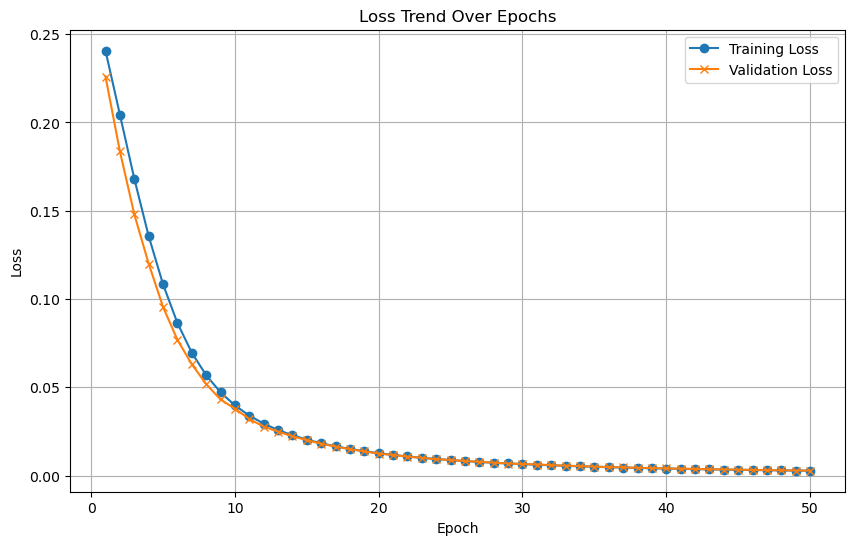

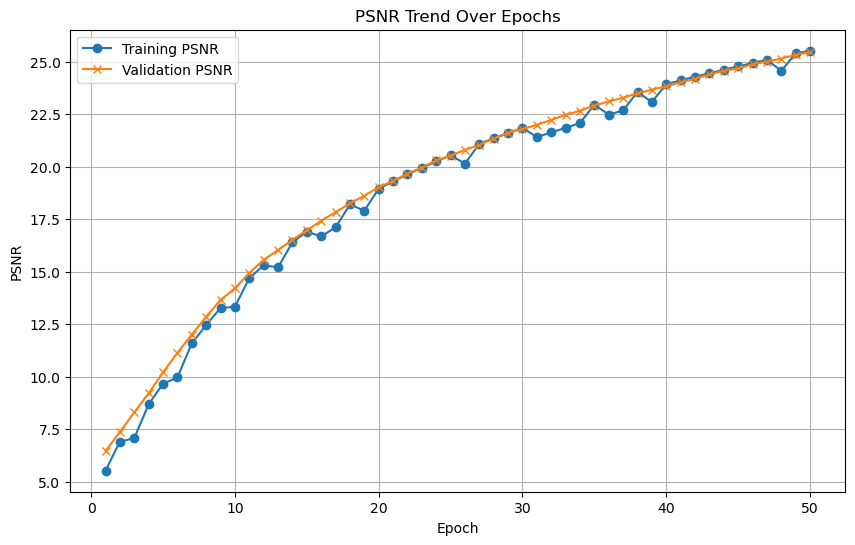

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/20 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.5975
    Validation Batch [1/1], Loss: 2.5718
Validation Loss: 2.5718, Validation Accuracy: 7.69%
Validation loss improved from inf to 2.5718. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.6002
    Validation Batch [1/1], Loss: 2.5717
Validation Loss: 2.5717, Validation Accuracy: 7.69%
Validation loss improved from 2.5718 to 2.5717. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5749
    Validation Batch [1/1], Loss: 2.5717
Validation Loss: 2.5717, Validation Accuracy: 7.69%
Validation loss improved from 2.5717 to 2.5717. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5631
    Validation Batch [1/1], Loss: 2.5717
Validation Loss: 2.5717, Validation Accuracy: 7.69%
Validation loss improved from 2.5717 to 2.5717. Saving model...

LOG: Epoch [5/1000] - 

Epoch [22/1000] completed, Average Training Loss: 2.4817
    Validation Batch [1/1], Loss: 2.5726
Validation Loss: 2.5726, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.4708
    Validation Batch [1/1], Loss: 2.5728
Validation Loss: 2.5728, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 2.4711
    Validation Batch [1/1], Loss: 2.5730
Validation Loss: 2.5730, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 2.4681
    Validation Batch [1/1], Loss: 2.5732
Validation Loss: 2.5732, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [26/1000] - Training
Epoch [26/1000] completed, Average Training Loss: 2.4745
    Validat

Epoch [53/1000] completed, Average Training Loss: 2.2683
    Validation Batch [1/1], Loss: 2.6095
Validation Loss: 2.6095, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [54/1000] - Training
Epoch [54/1000] completed, Average Training Loss: 2.2621
    Validation Batch [1/1], Loss: 2.6134
Validation Loss: 2.6134, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [55/1000] - Training
Epoch [55/1000] completed, Average Training Loss: 2.2297
    Validation Batch [1/1], Loss: 2.6175
Validation Loss: 2.6175, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 2.2575
    Validation Batch [1/1], Loss: 2.6219
Validation Loss: 2.6219, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [57/1000] - Training
Epoch [57/1000] completed, Average Training Loss: 2.2248
    Validat

Epoch [86/1000] completed, Average Training Loss: 2.0505
    Validation Batch [1/1], Loss: 2.4881
Validation Loss: 2.4881, Validation Accuracy: 13.85%
Validation loss improved from 2.5025 to 2.4881. Saving model...

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Training Loss: 2.0379
    Validation Batch [1/1], Loss: 2.4700
Validation Loss: 2.4700, Validation Accuracy: 15.38%
Validation loss improved from 2.4881 to 2.4700. Saving model...

LOG: Epoch [88/1000] - Training
Epoch [88/1000] completed, Average Training Loss: 1.9948
    Validation Batch [1/1], Loss: 2.4554
Validation Loss: 2.4554, Validation Accuracy: 18.46%
Validation loss improved from 2.4700 to 2.4554. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Training Loss: 2.0096
    Validation Batch [1/1], Loss: 2.4372
Validation Loss: 2.4372, Validation Accuracy: 21.54%
Validation loss improved from 2.4554 to 2.4372. Saving model...

LOG: Epoch [90/1000] - Training
Epoch [9

Epoch [119/1000] completed, Average Training Loss: 1.8033
    Validation Batch [1/1], Loss: 2.1123
Validation Loss: 2.1123, Validation Accuracy: 35.38%
Validation loss improved from 2.1195 to 2.1123. Saving model...

LOG: Epoch [120/1000] - Training
Epoch [120/1000] completed, Average Training Loss: 1.7853
    Validation Batch [1/1], Loss: 2.1061
Validation Loss: 2.1061, Validation Accuracy: 36.92%
Validation loss improved from 2.1123 to 2.1061. Saving model...

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 1.7673
    Validation Batch [1/1], Loss: 2.1045
Validation Loss: 2.1045, Validation Accuracy: 35.38%
Validation loss improved from 2.1061 to 2.1045. Saving model...

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 1.7785
    Validation Batch [1/1], Loss: 2.0964
Validation Loss: 2.0964, Validation Accuracy: 36.92%
Validation loss improved from 2.1045 to 2.0964. Saving model...

LOG: Epoch [123/1000] - Training


    Validation Batch [1/1], Loss: 1.9344
Validation Loss: 1.9344, Validation Accuracy: 49.23%
Validation loss improved from 1.9414 to 1.9344. Saving model...

LOG: Epoch [150/1000] - Training
Epoch [150/1000] completed, Average Training Loss: 1.5906
    Validation Batch [1/1], Loss: 1.9341
Validation Loss: 1.9341, Validation Accuracy: 44.62%
Validation loss improved from 1.9344 to 1.9341. Saving model...

LOG: Epoch [151/1000] - Training
Epoch [151/1000] completed, Average Training Loss: 1.5085
    Validation Batch [1/1], Loss: 1.9245
Validation Loss: 1.9245, Validation Accuracy: 49.23%
Validation loss improved from 1.9341 to 1.9245. Saving model...

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Average Training Loss: 1.4972
    Validation Batch [1/1], Loss: 1.9167
Validation Loss: 1.9167, Validation Accuracy: 50.77%
Validation loss improved from 1.9245 to 1.9167. Saving model...

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 1.4654


Epoch [178/1000] completed, Average Training Loss: 1.2309
    Validation Batch [1/1], Loss: 1.7698
Validation Loss: 1.7698, Validation Accuracy: 55.38%
Validation loss improved from 1.7765 to 1.7698. Saving model...

LOG: Epoch [179/1000] - Training
Epoch [179/1000] completed, Average Training Loss: 1.2563
    Validation Batch [1/1], Loss: 1.7627
Validation Loss: 1.7627, Validation Accuracy: 58.46%
Validation loss improved from 1.7698 to 1.7627. Saving model...

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Average Training Loss: 1.2765
    Validation Batch [1/1], Loss: 1.7619
Validation Loss: 1.7619, Validation Accuracy: 58.46%
Validation loss improved from 1.7627 to 1.7619. Saving model...

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Average Training Loss: 1.2367
    Validation Batch [1/1], Loss: 1.7745
Validation Loss: 1.7745, Validation Accuracy: 55.38%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [182/1000] - Training
Epoch [182/1000

Epoch [209/1000] completed, Average Training Loss: 0.9695
    Validation Batch [1/1], Loss: 1.5820
Validation Loss: 1.5820, Validation Accuracy: 58.46%
Validation loss improved from 1.5960 to 1.5820. Saving model...

LOG: Epoch [210/1000] - Training
Epoch [210/1000] completed, Average Training Loss: 0.9888
    Validation Batch [1/1], Loss: 1.5769
Validation Loss: 1.5769, Validation Accuracy: 56.92%
Validation loss improved from 1.5820 to 1.5769. Saving model...

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 1.0405
    Validation Batch [1/1], Loss: 1.5713
Validation Loss: 1.5713, Validation Accuracy: 58.46%
Validation loss improved from 1.5769 to 1.5713. Saving model...

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Average Training Loss: 0.9890
    Validation Batch [1/1], Loss: 1.5666
Validation Loss: 1.5666, Validation Accuracy: 58.46%
Validation loss improved from 1.5713 to 1.5666. Saving model...

LOG: Epoch [213/1000] - Training


Epoch [241/1000] completed, Average Training Loss: 0.7509
    Validation Batch [1/1], Loss: 1.4361
Validation Loss: 1.4361, Validation Accuracy: 61.54%
Validation loss improved from 1.4523 to 1.4361. Saving model...

LOG: Epoch [242/1000] - Training
Epoch [242/1000] completed, Average Training Loss: 0.7137
    Validation Batch [1/1], Loss: 1.4353
Validation Loss: 1.4353, Validation Accuracy: 61.54%
Validation loss improved from 1.4361 to 1.4353. Saving model...

LOG: Epoch [243/1000] - Training
Epoch [243/1000] completed, Average Training Loss: 0.7152
    Validation Batch [1/1], Loss: 1.4134
Validation Loss: 1.4134, Validation Accuracy: 63.08%
Validation loss improved from 1.4353 to 1.4134. Saving model...

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.8090
    Validation Batch [1/1], Loss: 1.3990
Validation Loss: 1.3990, Validation Accuracy: 63.08%
Validation loss improved from 1.4134 to 1.3990. Saving model...

LOG: Epoch [245/1000] - Training


Epoch [270/1000] completed, Average Training Loss: 0.6027
    Validation Batch [1/1], Loss: 1.3442
Validation Loss: 1.3442, Validation Accuracy: 63.08%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Training Loss: 0.5303
    Validation Batch [1/1], Loss: 1.3432
Validation Loss: 1.3432, Validation Accuracy: 63.08%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Average Training Loss: 0.6113
    Validation Batch [1/1], Loss: 1.3274
Validation Loss: 1.3274, Validation Accuracy: 63.08%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [273/1000] - Training
Epoch [273/1000] completed, Average Training Loss: 0.5286
    Validation Batch [1/1], Loss: 1.3160
Validation Loss: 1.3160, Validation Accuracy: 64.62%
Validation loss improved from 1.3254 to 1.3160. Saving model...

LOG: Epoch [274/1000] - Training
Epoch [274/1000] completed, Average Training 

Epoch [300/1000] completed, Average Training Loss: 0.4630
    Validation Batch [1/1], Loss: 1.2632
Validation Loss: 1.2632, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [301/1000] - Training
Epoch [301/1000] completed, Average Training Loss: 0.4599
    Validation Batch [1/1], Loss: 1.2734
Validation Loss: 1.2734, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.3913
    Validation Batch [1/1], Loss: 1.2593
Validation Loss: 1.2593, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Training Loss: 0.3970
    Validation Batch [1/1], Loss: 1.2425
Validation Loss: 1.2425, Validation Accuracy: 64.62%
Validation loss improved from 1.2536 to 1.2425. Saving model...

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.1641
Validation Loss: 1.1641, Validation Accuracy: 64.62%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [331/1000] - Training
Epoch [331/1000] completed, Average Training Loss: 0.3317
    Validation Batch [1/1], Loss: 1.1673
Validation Loss: 1.1673, Validation Accuracy: 64.62%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training Loss: 0.3461
    Validation Batch [1/1], Loss: 1.1765
Validation Loss: 1.1765, Validation Accuracy: 61.54%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Average Training Loss: 0.2962
    Validation Batch [1/1], Loss: 1.1804
Validation Loss: 1.1804, Validation Accuracy: 63.08%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Training Loss: 0.3456
    Validation Batch [1/1], Loss: 1.1703
Validation Loss: 1.

Epoch [364/1000] completed, Average Training Loss: 0.2273
    Validation Batch [1/1], Loss: 1.1804
Validation Loss: 1.1804, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [365/1000] - Training
Epoch [365/1000] completed, Average Training Loss: 0.2613
    Validation Batch [1/1], Loss: 1.1690
Validation Loss: 1.1690, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.2773
    Validation Batch [1/1], Loss: 1.1573
Validation Loss: 1.1573, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.2439
    Validation Batch [1/1], Loss: 1.1472
Validation Loss: 1.1472, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.1750
  

Epoch [398/1000] completed, Average Training Loss: 0.1890
    Validation Batch [1/1], Loss: 1.1481
Validation Loss: 1.1481, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.1819
    Validation Batch [1/1], Loss: 1.1630
Validation Loss: 1.1630, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.2104
    Validation Batch [1/1], Loss: 1.1588
Validation Loss: 1.1588, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.2108
    Validation Batch [1/1], Loss: 1.1335
Validation Loss: 1.1335, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training Loss: 0.1842
  

Epoch [431/1000] completed, Average Training Loss: 0.1597
    Validation Batch [1/1], Loss: 1.1153
Validation Loss: 1.1153, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [432/1000] - Training
Epoch [432/1000] completed, Average Training Loss: 0.1775
    Validation Batch [1/1], Loss: 1.1042
Validation Loss: 1.1042, Validation Accuracy: 64.62%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [433/1000] - Training
Epoch [433/1000] completed, Average Training Loss: 0.1447
    Validation Batch [1/1], Loss: 1.1246
Validation Loss: 1.1246, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [434/1000] - Training
Epoch [434/1000] completed, Average Training Loss: 0.1314
    Validation Batch [1/1], Loss: 1.1406
Validation Loss: 1.1406, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [435/1000] - Training
Epoch [435/1000] completed, Average Training Loss: 0.1426
 

Epoch [462/1000] completed, Average Training Loss: 0.1169
    Validation Batch [1/1], Loss: 1.1123
Validation Loss: 1.1123, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [463/1000] - Training
Epoch [463/1000] completed, Average Training Loss: 0.1116
    Validation Batch [1/1], Loss: 1.1222
Validation Loss: 1.1222, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [464/1000] - Training
Epoch [464/1000] completed, Average Training Loss: 0.1021
    Validation Batch [1/1], Loss: 1.1400
Validation Loss: 1.1400, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [465/1000] - Training
Epoch [465/1000] completed, Average Training Loss: 0.1233
    Validation Batch [1/1], Loss: 1.1638
Validation Loss: 1.1638, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [466/1000] - Training
Epoch [466/1000] completed, Average Training Loss: 0.161

    Validation Batch [1/1], Loss: 1.1087
Validation Loss: 1.1087, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [493/1000] - Training
Epoch [493/1000] completed, Average Training Loss: 0.0999
    Validation Batch [1/1], Loss: 1.0940
Validation Loss: 1.0940, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [494/1000] - Training
Epoch [494/1000] completed, Average Training Loss: 0.0783
    Validation Batch [1/1], Loss: 1.0916
Validation Loss: 1.0916, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [495/1000] - Training
Epoch [495/1000] completed, Average Training Loss: 0.1053
    Validation Batch [1/1], Loss: 1.0995
Validation Loss: 1.0995, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [496/1000] - Training
Epoch [496/1000] completed, Average Training Loss: 0.1321
    Validation Batch [1/1], Loss: 1.1068
Validation Loss

Epoch [526/1000] completed, Average Training Loss: 0.1679
    Validation Batch [1/1], Loss: 1.1713
Validation Loss: 1.1713, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [527/1000] - Training
Epoch [527/1000] completed, Average Training Loss: 0.0744
    Validation Batch [1/1], Loss: 1.2042
Validation Loss: 1.2042, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [528/1000] - Training
Epoch [528/1000] completed, Average Training Loss: 0.0977
    Validation Batch [1/1], Loss: 1.1973
Validation Loss: 1.1973, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [529/1000] - Training
Epoch [529/1000] completed, Average Training Loss: 0.0874
    Validation Batch [1/1], Loss: 1.1774
Validation Loss: 1.1774, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [530/1000] - Training
Epoch [530/1000] completed, Average Training Loss: 0.098

Epoch [559/1000] completed, Average Training Loss: 0.0712
    Validation Batch [1/1], Loss: 1.0888
Validation Loss: 1.0888, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [560/1000] - Training
Epoch [560/1000] completed, Average Training Loss: 0.0801
    Validation Batch [1/1], Loss: 1.0955
Validation Loss: 1.0955, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [561/1000] - Training
Epoch [561/1000] completed, Average Training Loss: 0.0846
    Validation Batch [1/1], Loss: 1.0958
Validation Loss: 1.0958, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [562/1000] - Training
Epoch [562/1000] completed, Average Training Loss: 0.0811
    Validation Batch [1/1], Loss: 1.0917
Validation Loss: 1.0917, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [563/1000] - Training
Epoch [563/1000] completed, Average Training Loss: 0.079

Epoch [592/1000] completed, Average Training Loss: 0.0711
    Validation Batch [1/1], Loss: 1.1430
Validation Loss: 1.1430, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [593/1000] - Training
Epoch [593/1000] completed, Average Training Loss: 0.0522
    Validation Batch [1/1], Loss: 1.1448
Validation Loss: 1.1448, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [594/1000] - Training
Epoch [594/1000] completed, Average Training Loss: 0.0788
    Validation Batch [1/1], Loss: 1.1523
Validation Loss: 1.1523, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [595/1000] - Training
Epoch [595/1000] completed, Average Training Loss: 0.0537
    Validation Batch [1/1], Loss: 1.1550
Validation Loss: 1.1550, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [596/1000] - Training
Epoch [596/1000] completed, Average Training Loss: 0.073

    Validation Batch [1/1], Loss: 1.1242
Validation Loss: 1.1242, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 79/100

LOG: Epoch [622/1000] - Training
Epoch [622/1000] completed, Average Training Loss: 0.0682
    Validation Batch [1/1], Loss: 1.1252
Validation Loss: 1.1252, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 80/100

LOG: Epoch [623/1000] - Training
Epoch [623/1000] completed, Average Training Loss: 0.0700
    Validation Batch [1/1], Loss: 1.1212
Validation Loss: 1.1212, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 81/100

LOG: Epoch [624/1000] - Training
Epoch [624/1000] completed, Average Training Loss: 0.0678
    Validation Batch [1/1], Loss: 1.1299
Validation Loss: 1.1299, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [625/1000] - Training
Epoch [625/1000] completed, Average Training Loss: 0.0725
    Validation Batch [1/1], Loss: 1.1278
Validation Loss

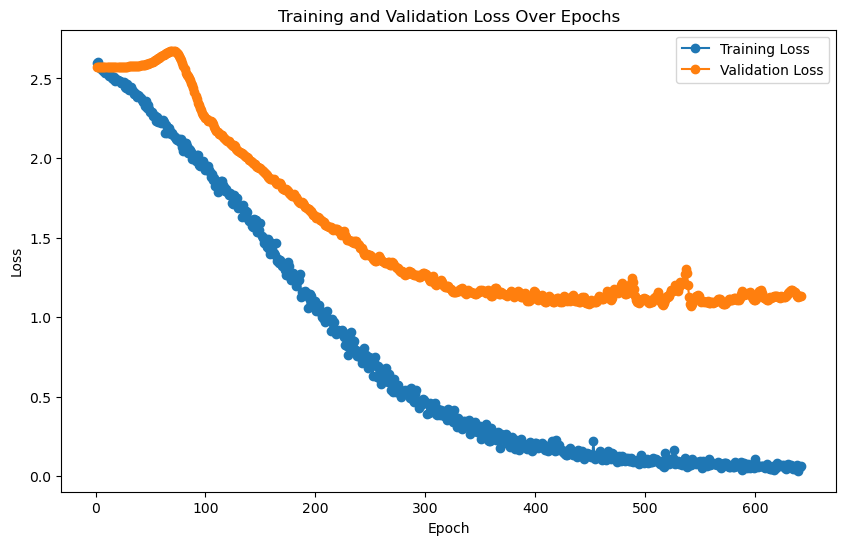

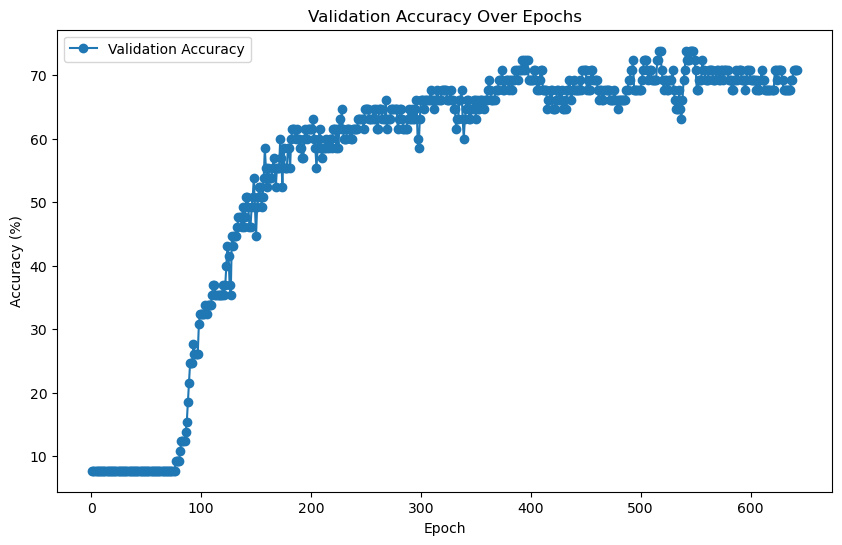


Evaluating on the test set...
    Test Batch [1/20], Loss: 1.3675

Final Test Loss: 1.4709, Test Accuracy: 69.36%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.
  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5081 samples with 64 features each
LOG: Labels shape: (5081,)

LOG: Training features shape: (65, 64), Training labels shape: (65,)
LOG: Validation features shape: (65, 64), Validation labels shape: (65,)
LOG: Test features shape: (5081, 64), Test labels shape: (5081,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 40.00%

Validation Classification Report:
               precision    recall  f1-sco

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5081 samples with 64 features each
LOG: Labels shape: (5081,)
Train reps shape: (65, 64)
Train labels shape: (65,)
Val reps shape: (65, 64)
Val labels shape: (65,)
Test reps shape: (5081, 64)
Test labels shape: (5081,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7923  |  Val Loss: 2.6543
Validation loss improved from inf to 2.6543.
[Epoch 2/1000] Train Loss: 2.6766  |  Val Loss: 2.6313
Validation loss improved from 2.6543 to 2.6313.
[Epoch 3/1000] Train Loss: 2.6304  |  Val Loss: 2.6279
Validation loss improved from 2.6313 to 2.6279.
[Epoch 4/1000] Train Loss: 2.6136  |  Val Loss: 2.6259
Validation loss improved from 2.6279 to 2.6259.
[Epoch 5/1000] Train Loss: 2.6049  |  Val Loss: 2.6282
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 6/1000] Train Loss: 2.6032  |  Val Loss: 2.6367
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 7/1000] Train Loss: 2.6089  |  Val Loss: 2.6397
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 8/1000] Train Loss: 2.6066  |  Val Loss: 2.6368
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 9/1000] Train Loss: 2.6009  |  Val Loss: 2.6274
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 10/1000] Train Loss: 2.5884  |  Val Los

[Epoch 28/1000] Train Loss: 2.5129  |  Val Loss: 2.5915
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 29/1000] Train Loss: 2.5053  |  Val Loss: 2.5908
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 30/1000] Train Loss: 2.4995  |  Val Loss: 2.5904
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 31/1000] Train Loss: 2.4988  |  Val Loss: 2.5891
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 32/1000] Train Loss: 2.4971  |  Val Loss: 2.5885
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 33/1000] Train Loss: 2.4947  |  Val Loss: 2.5923
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 34/1000] Train Loss: 2.4972  |  Val Loss: 2.5978
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 35/1000] Train Loss: 2.5026  |  Val Loss: 2.6043
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 36/1000] Train Loss: 2.5074  |  Val Loss: 2.6064
!! Validation loss did NOT improve !! Patience: 16/100
[Ep

[Epoch 44/1000] Train Loss: 2.4821  |  Val Loss: 2.5885
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 45/1000] Train Loss: 2.4787  |  Val Loss: 2.5860
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 46/1000] Train Loss: 2.4749  |  Val Loss: 2.5831
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 47/1000] Train Loss: 2.4738  |  Val Loss: 2.5817
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 48/1000] Train Loss: 2.4707  |  Val Loss: 2.5815
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 49/1000] Train Loss: 2.4675  |  Val Loss: 2.5811
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 50/1000] Train Loss: 2.4635  |  Val Loss: 2.5814
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 51/1000] Train Loss: 2.4598  |  Val Loss: 2.5819
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 52/1000] Train Loss: 2.4582  |  Val Loss: 2.5815
!! Validation loss did NOT improve !! Patience: 32/100
[

[Epoch 67/1000] Train Loss: 2.4357  |  Val Loss: 2.5891
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 68/1000] Train Loss: 2.4333  |  Val Loss: 2.5916
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 69/1000] Train Loss: 2.4325  |  Val Loss: 2.5941
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 70/1000] Train Loss: 2.4317  |  Val Loss: 2.5961
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 71/1000] Train Loss: 2.4315  |  Val Loss: 2.5994
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 72/1000] Train Loss: 2.4324  |  Val Loss: 2.6036
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 73/1000] Train Loss: 2.4341  |  Val Loss: 2.6059
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 74/1000] Train Loss: 2.4346  |  Val Loss: 2.6072
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 75/1000] Train Loss: 2.4323  |  Val Loss: 2.6076
!! Validation loss did NOT improve !! Patience: 55/100
[

[Epoch 85/1000] Train Loss: 2.4556  |  Val Loss: 2.5980
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 86/1000] Train Loss: 2.4486  |  Val Loss: 2.5948
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 87/1000] Train Loss: 2.4400  |  Val Loss: 2.5878
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 88/1000] Train Loss: 2.4299  |  Val Loss: 2.5832
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 89/1000] Train Loss: 2.4234  |  Val Loss: 2.5800
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 90/1000] Train Loss: 2.4189  |  Val Loss: 2.5757
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 91/1000] Train Loss: 2.4151  |  Val Loss: 2.5716
Validation loss improved from 2.5717 to 2.5716.
[Epoch 92/1000] Train Loss: 2.4120  |  Val Loss: 2.5697
Validation loss improved from 2.5716 to 2.5697.
[Epoch 93/1000] Train Loss: 2.4092  |  Val Loss: 2.5689
Validation loss improved from 2.5697 to 2.5689.
[Epoch 94/1000] Train 

[Epoch 114/1000] Train Loss: 2.3864  |  Val Loss: 2.5602
Validation loss improved from 2.5607 to 2.5602.
[Epoch 115/1000] Train Loss: 2.3863  |  Val Loss: 2.5605
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 116/1000] Train Loss: 2.3856  |  Val Loss: 2.5603
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 117/1000] Train Loss: 2.3853  |  Val Loss: 2.5600
Validation loss improved from 2.5602 to 2.5600.
[Epoch 118/1000] Train Loss: 2.3859  |  Val Loss: 2.5603
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 119/1000] Train Loss: 2.3864  |  Val Loss: 2.5611
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 120/1000] Train Loss: 2.3878  |  Val Loss: 2.5639
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 121/1000] Train Loss: 2.3878  |  Val Loss: 2.5686
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 122/1000] Train Loss: 2.3883  |  Val Loss: 2.5731
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 123/10

[Epoch 127/1000] Train Loss: 2.3843  |  Val Loss: 2.5856
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 128/1000] Train Loss: 2.3820  |  Val Loss: 2.5852
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 129/1000] Train Loss: 2.3789  |  Val Loss: 2.5851
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 130/1000] Train Loss: 2.3757  |  Val Loss: 2.5856
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 131/1000] Train Loss: 2.3730  |  Val Loss: 2.5853
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 132/1000] Train Loss: 2.3727  |  Val Loss: 2.5884
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 133/1000] Train Loss: 2.3780  |  Val Loss: 2.5922
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 134/1000] Train Loss: 2.3864  |  Val Loss: 2.5935
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 135/1000] Train Loss: 2.3878  |  Val Loss: 2.5931
!! Validation loss did NOT improve !! Patience:

[Epoch 157/1000] Train Loss: 2.3601  |  Val Loss: 2.5821
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 158/1000] Train Loss: 2.3620  |  Val Loss: 2.5848
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 159/1000] Train Loss: 2.3797  |  Val Loss: 2.5872
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 160/1000] Train Loss: 2.3992  |  Val Loss: 2.5891
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 161/1000] Train Loss: 2.4131  |  Val Loss: 2.5907
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 162/1000] Train Loss: 2.4211  |  Val Loss: 2.5925
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 163/1000] Train Loss: 2.4265  |  Val Loss: 2.5928
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 164/1000] Train Loss: 2.4293  |  Val Loss: 2.5937
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 165/1000] Train Loss: 2.4308  |  Val Loss: 2.5958
!! Validation loss did NOT improve !! Patience:

[Epoch 170/1000] Train Loss: 2.4240  |  Val Loss: 2.5881
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 171/1000] Train Loss: 2.4107  |  Val Loss: 2.5887
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 172/1000] Train Loss: 2.3897  |  Val Loss: 2.5919
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 173/1000] Train Loss: 2.3809  |  Val Loss: 2.5975
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 174/1000] Train Loss: 2.3803  |  Val Loss: 2.6026
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 175/1000] Train Loss: 2.3881  |  Val Loss: 2.6032
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 176/1000] Train Loss: 2.3958  |  Val Loss: 2.6006
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 177/1000] Train Loss: 2.4028  |  Val Loss: 2.5992
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 178/1000] Train Loss: 2.4101  |  Val Loss: 2.5983
!! Validation loss did NOT improve !! Patience:

[Epoch 202/1000] Train Loss: 2.3791  |  Val Loss: 2.5366
Validation loss improved from 2.5368 to 2.5366.
[Epoch 203/1000] Train Loss: 2.3823  |  Val Loss: 2.5364
Validation loss improved from 2.5366 to 2.5364.
[Epoch 204/1000] Train Loss: 2.3843  |  Val Loss: 2.5367
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 205/1000] Train Loss: 2.3852  |  Val Loss: 2.5378
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 206/1000] Train Loss: 2.3843  |  Val Loss: 2.5414
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 207/1000] Train Loss: 2.3832  |  Val Loss: 2.5464
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 208/1000] Train Loss: 2.3835  |  Val Loss: 2.5502
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 209/1000] Train Loss: 2.3834  |  Val Loss: 2.5559
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 210/1000] Train Loss: 2.3871  |  Val Loss: 2.5613
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 211/1000] Train Loss: 2.3909  |  Val Loss: 2.5649
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 212/1000] Train Loss: 2.3937  |  Val Loss: 2.5683
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 213/1000] Train Loss: 2.3947  |  Val Loss: 2.5719
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 214/1000] Train Loss: 2.3945  |  Val Loss: 2.5753
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 215/1000] Train Loss: 2.3935  |  Val Loss: 2.5791
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 216/1000] Train Loss: 2.3919  |  Val Loss: 2.5830
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 217/1000] Train Loss: 2.3880  |  Val Loss: 2.5862
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 218/1000] Train Loss: 2.3824  |  Val Loss: 2.5893
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 219/1000] Train Loss: 2.3779  |  Val Loss: 2.5922
!! Validation loss did NOT improve !! Patience: 1

[Epoch 243/1000] Train Loss: 2.3675  |  Val Loss: 2.5527
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 244/1000] Train Loss: 2.3701  |  Val Loss: 2.5564
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 245/1000] Train Loss: 2.3712  |  Val Loss: 2.5588
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 246/1000] Train Loss: 2.3712  |  Val Loss: 2.5634
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 247/1000] Train Loss: 2.3713  |  Val Loss: 2.5675
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 248/1000] Train Loss: 2.3655  |  Val Loss: 2.5708
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 249/1000] Train Loss: 2.3579  |  Val Loss: 2.5764
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 250/1000] Train Loss: 2.3576  |  Val Loss: 2.5889
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 251/1000] Train Loss: 2.3686  |  Val Loss: 2.5967
!! Validation loss did NOT improve !! Patience:

[Epoch 253/1000] Train Loss: 2.3888  |  Val Loss: 2.6076
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 254/1000] Train Loss: 2.3981  |  Val Loss: 2.6127
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 255/1000] Train Loss: 2.4044  |  Val Loss: 2.6163
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 256/1000] Train Loss: 2.4085  |  Val Loss: 2.6196
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 257/1000] Train Loss: 2.4128  |  Val Loss: 2.6241
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 258/1000] Train Loss: 2.4167  |  Val Loss: 2.6301
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 259/1000] Train Loss: 2.4213  |  Val Loss: 2.6341
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 260/1000] Train Loss: 2.4239  |  Val Loss: 2.6359
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 261/1000] Train Loss: 2.4232  |  Val Loss: 2.6352
!! Validation loss did NOT improve !! Patience:

[Epoch 288/1000] Train Loss: 2.3368  |  Val Loss: 2.5807
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 289/1000] Train Loss: 2.3367  |  Val Loss: 2.5805
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 290/1000] Train Loss: 2.3358  |  Val Loss: 2.5790
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 291/1000] Train Loss: 2.3361  |  Val Loss: 2.5787
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 292/1000] Train Loss: 2.3362  |  Val Loss: 2.5803
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 293/1000] Train Loss: 2.3352  |  Val Loss: 2.5819
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 294/1000] Train Loss: 2.3341  |  Val Loss: 2.5805
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 295/1000] Train Loss: 2.3334  |  Val Loss: 2.5762
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 296/1000] Train Loss: 2.3242  |  Val Loss: 2.5740
!! Validation loss did NOT improve !! Patience:

[Epoch 298/1000] Train Loss: 2.3549  |  Val Loss: 2.5867
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 299/1000] Train Loss: 2.3637  |  Val Loss: 2.5982
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 300/1000] Train Loss: 2.3772  |  Val Loss: 2.6042
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 301/1000] Train Loss: 2.3869  |  Val Loss: 2.6105
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 302/1000] Train Loss: 2.3977  |  Val Loss: 2.6116
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 303/1000] Train Loss: 2.4040  |  Val Loss: 2.6106
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 303 !!
No improvement for 100 epochs.


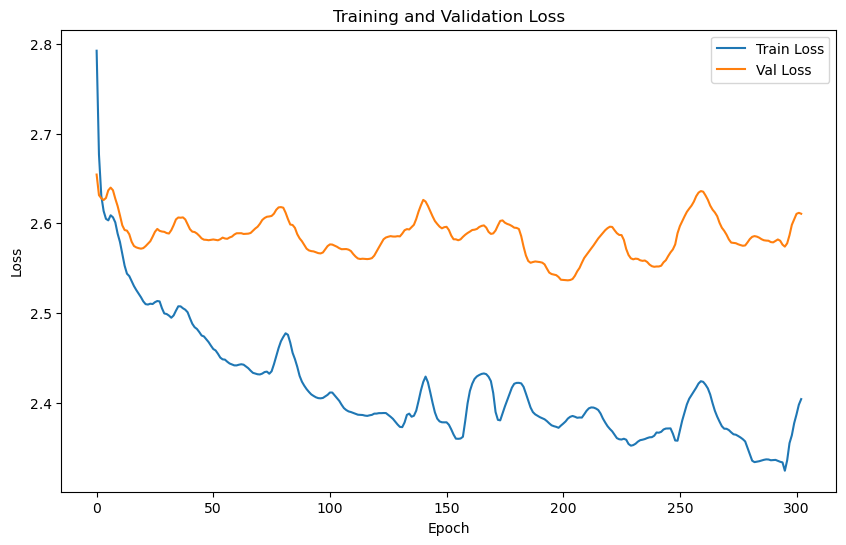

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 2.5312 | Test Accuracy: 7.32%


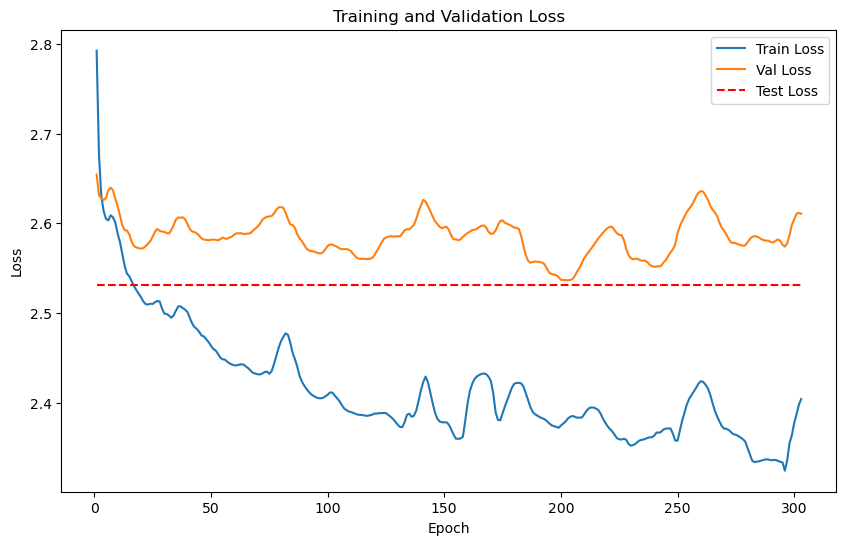

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5081 samples with 64 features each
LOG: Labels shape: (5081,)


Train embeddings shape: (65, 64), 
Train labels shape: (65,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (5081, 64), 
Test labels shape: (5081,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5}
Training batch size: 65


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 7.5231
Epoch [1/2000], Avg Train Loss: 7.5231
Epoch [1/2000], Avg Val Loss: 3.9905
Validation loss improved from inf to 3.9905. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 7.3710
Epoch [2/2000], Avg Train Loss: 7.3710
Epoch [2/2000], Avg Val Loss: 3.9888
Validation loss improved from 3.9905 to 3.9888. Saving model...

LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 7.4937
Epoch [3/2000], Avg Train Loss: 7.4937
Epoch [3/2000], Avg Val Loss: 3.9871
Validation loss improved from 3.9888 to 3.9871. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 7.1417
Epoch [4/2000], Avg Train Loss: 7.1417
Epoch [4/2000], Avg Val Loss: 3.9851
Validation loss improved from 3.9871 to 3.9851. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.2325
Epoch [5/2000], Avg Train Loss: 7.2325
Epoch [5/2000], Avg Val Loss: 3.9833
Validation loss improved from 3.9851 to 3.9833. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 7.2036
Epoch [6/2000], Avg Train Loss: 7.2036
Epoch [6/2000], Avg Val Loss: 3.9818
Validation loss improved from 3.9833 to 3.9818. Saving model...

LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 7.4025
Epoch [7/2000], Avg Train Loss: 7.4025
Epoch [7/2000], Avg Val Loss: 3.9801
Validation loss improved from 3.9818 to 3.9801. Saving m

    Batch [1/1], Train Loss: 6.5505
Epoch [20/2000], Avg Train Loss: 6.5505


Epoch [20/2000], Avg Val Loss: 3.9649
Validation loss improved from 3.9661 to 3.9649. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 6.2501
Epoch [21/2000], Avg Train Loss: 6.2501
Epoch [21/2000], Avg Val Loss: 3.9637
Validation loss improved from 3.9649 to 3.9637. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 6.4000
Epoch [22/2000], Avg Train Loss: 6.4000
Epoch [22/2000], Avg Val Loss: 3.9624
Validation loss improved from 3.9637 to 3.9624. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 6.3435
Epoch [23/2000], Avg Train Loss: 6.3435
Epoch [23/2000], Avg Val Loss: 3.9612
Validation loss improved from 3.9624 to 3.9612. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 6.2688
Epoch [24/2000], Avg Train Loss: 6.2688
Epoch [24/2000], Avg Val Loss: 3.9599
Validation loss improved from 3.9612 to 3.9599. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Trai

Epoch [31/2000], Avg Val Loss: 3.9485
Validation loss improved from 3.9505 to 3.9485. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 5.9040
Epoch [32/2000], Avg Train Loss: 5.9040
Epoch [32/2000], Avg Val Loss: 3.9466
Validation loss improved from 3.9485 to 3.9466. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 5.8715
Epoch [33/2000], Avg Train Loss: 5.8715
Epoch [33/2000], Avg Val Loss: 3.9446
Validation loss improved from 3.9466 to 3.9446. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 5.8624
Epoch [34/2000], Avg Train Loss: 5.8624
Epoch [34/2000], Avg Val Loss: 3.9426
Validation loss improved from 3.9446 to 3.9426. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 5.7617
Epoch [35/2000], Avg Train Loss: 5.7617
Epoch [35/2000], Avg Val Loss: 3.9405
Validation loss improved from 3.9426 to 3.9405. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.4161
Epoch [50/2000], Avg Train Loss: 5.4161
Epoch [50/2000], Avg Val Loss: 3.9065
Validation loss improved from 3.9090 to 3.9065. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 5.3633
Epoch [51/2000], Avg Train Loss: 5.3633
Epoch [51/2000], Avg Val Loss: 3.9040
Validation loss improved from 3.9065 to 3.9040. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 5.5310
Epoch [52/2000], Avg Train Loss: 5.5310
Epoch [52/2000], Avg Val Loss: 3.9016
Validation loss improved from 3.9040 to 3.9016. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 5.1959
Epoch [53/2000], Avg Train Loss: 5.1959
Epoch [53/2000], Avg Val Loss: 3.8991
Validation loss improved from 3.9016 to 3.8991. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 5.1267
Epoch [54/2000], Avg Train Loss: 5.1267
Epoch [54/2000], Avg Val Loss: 3.8965
Validation loss improved from 3.8991 to 3.

    Batch [1/1], Train Loss: 5.0144
Epoch [71/2000], Avg Train Loss: 5.0144
Epoch [71/2000], Avg Val Loss: 3.8510
Validation loss improved from 3.8535 to 3.8510. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 4.8550
Epoch [72/2000], Avg Train Loss: 4.8550
Epoch [72/2000], Avg Val Loss: 3.8483
Validation loss improved from 3.8510 to 3.8483. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 4.6619
Epoch [73/2000], Avg Train Loss: 4.6619
Epoch [73/2000], Avg Val Loss: 3.8457
Validation loss improved from 3.8483 to 3.8457. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 4.8994
Epoch [74/2000], Avg Train Loss: 4.8994
Epoch [74/2000], Avg Val Loss: 3.8430
Validation loss improved from 3.8457 to 3.8430. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 4.7568
Epoch [75/2000], Avg Train Loss: 4.7568
Epoch [75/2000], Avg Val Loss: 3.8403
Validation loss improved from 3.8430 to 3.

    Batch [1/1], Train Loss: 4.8445
Epoch [79/2000], Avg Train Loss: 4.8445
Epoch [79/2000], Avg Val Loss: 3.8297
Validation loss improved from 3.8324 to 3.8297. Saving model...

LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 4.6404
Epoch [80/2000], Avg Train Loss: 4.6404
Epoch [80/2000], Avg Val Loss: 3.8269
Validation loss improved from 3.8297 to 3.8269. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 4.6619
Epoch [81/2000], Avg Train Loss: 4.6619
Epoch [81/2000], Avg Val Loss: 3.8240
Validation loss improved from 3.8269 to 3.8240. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 4.7996
Epoch [82/2000], Avg Train Loss: 4.7996
Epoch [82/2000], Avg Val Loss: 3.8212
Validation loss improved from 3.8240 to 3.8212. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 4.7830
Epoch [83/2000], Avg Train Loss: 4.7830
Epoch [83/2000], Avg Val Loss: 3.8185
Validation loss improved from 3.8212 to 3.

Epoch [93/2000], Avg Val Loss: 3.7932
Validation loss improved from 3.7955 to 3.7932. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 4.6794
Epoch [94/2000], Avg Train Loss: 4.6794
Epoch [94/2000], Avg Val Loss: 3.7908
Validation loss improved from 3.7932 to 3.7908. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 4.6390
Epoch [95/2000], Avg Train Loss: 4.6390
Epoch [95/2000], Avg Val Loss: 3.7883
Validation loss improved from 3.7908 to 3.7883. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 4.5029
Epoch [96/2000], Avg Train Loss: 4.5029
Epoch [96/2000], Avg Val Loss: 3.7860
Validation loss improved from 3.7883 to 3.7860. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 4.6496
Epoch [97/2000], Avg Train Loss: 4.6496
Epoch [97/2000], Avg Val Loss: 3.7836
Validation loss improved from 3.7860 to 3.7836. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.2825
Epoch [118/2000], Avg Train Loss: 4.2825
Epoch [118/2000], Avg Val Loss: 3.7347
Validation loss improved from 3.7370 to 3.7347. Saving model...

LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 4.3680
Epoch [119/2000], Avg Train Loss: 4.3680
Epoch [119/2000], Avg Val Loss: 3.7324
Validation loss improved from 3.7347 to 3.7324. Saving model...

LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 4.3760
Epoch [120/2000], Avg Train Loss: 4.3760
Epoch [120/2000], Avg Val Loss: 3.7301
Validation loss improved from 3.7324 to 3.7301. Saving model...

LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 4.3483
Epoch [121/2000], Avg Train Loss: 4.3483
Epoch [121/2000], Avg Val Loss: 3.7277
Validation loss improved from 3.7301 to 3.7277. Saving model...

LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 4.2749
Epoch [122/2000], Avg Train Loss: 4.2749
Epoch [122/2000], Avg Val Loss: 3.7254
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3557
Epoch [127/2000], Avg Train Loss: 4.3557
Epoch [127/2000], Avg Val Loss: 3.7144
Validation loss improved from 3.7165 to 3.7144. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 4.2914
Epoch [128/2000], Avg Train Loss: 4.2914
Epoch [128/2000], Avg Val Loss: 3.7122
Validation loss improved from 3.7144 to 3.7122. Saving model...

LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 4.3897
Epoch [129/2000], Avg Train Loss: 4.3897
Epoch [129/2000], Avg Val Loss: 3.7102
Validation loss improved from 3.7122 to 3.7102. Saving model...

LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 4.3206
Epoch [130/2000], Avg Train Loss: 4.3206
Epoch [130/2000], Avg Val Loss: 3.7082
Validation loss improved from 3.7102 to 3.7082. Saving model...

LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 4.2680
Epoch [131/2000], Avg Train Loss: 4.2680
Epoch [131/2000], Avg Val Loss: 3.7063
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2794
Epoch [144/2000], Avg Train Loss: 4.2794
Epoch [144/2000], Avg Val Loss: 3.6810
Validation loss improved from 3.6828 to 3.6810. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 4.2799
Epoch [145/2000], Avg Train Loss: 4.2799
Epoch [145/2000], Avg Val Loss: 3.6792
Validation loss improved from 3.6810 to 3.6792. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 4.1992
Epoch [146/2000], Avg Train Loss: 4.1992
Epoch [146/2000], Avg Val Loss: 3.6774
Validation loss improved from 3.6792 to 3.6774. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 4.1933
Epoch [147/2000], Avg Train Loss: 4.1933
Epoch [147/2000], Avg Val Loss: 3.6756
Validation loss improved from 3.6774 to 3.6756. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 4.1584
Epoch [148/2000], Avg Train Loss: 4.1584
Epoch [148/2000], Avg Val Loss: 3.6738
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1114
Epoch [165/2000], Avg Train Loss: 4.1114
Epoch [165/2000], Avg Val Loss: 3.6420
Validation loss improved from 3.6438 to 3.6420. Saving model...

LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 4.1613
Epoch [166/2000], Avg Train Loss: 4.1613
Epoch [166/2000], Avg Val Loss: 3.6403
Validation loss improved from 3.6420 to 3.6403. Saving model...

LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 4.1415
Epoch [167/2000], Avg Train Loss: 4.1415
Epoch [167/2000], Avg Val Loss: 3.6386
Validation loss improved from 3.6403 to 3.6386. Saving model...

LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 4.0379
Epoch [168/2000], Avg Train Loss: 4.0379
Epoch [168/2000], Avg Val Loss: 3.6369
Validation loss improved from 3.6386 to 3.6369. Saving model...

LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 4.1039
Epoch [169/2000], Avg Train Loss: 4.1039
Epoch [169/2000], Avg Val Loss: 3.6351
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0747
Epoch [175/2000], Avg Train Loss: 4.0747
Epoch [175/2000], Avg Val Loss: 3.6251
Validation loss improved from 3.6267 to 3.6251. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 4.0819
Epoch [176/2000], Avg Train Loss: 4.0819
Epoch [176/2000], Avg Val Loss: 3.6234
Validation loss improved from 3.6251 to 3.6234. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 4.1517
Epoch [177/2000], Avg Train Loss: 4.1517
Epoch [177/2000], Avg Val Loss: 3.6218
Validation loss improved from 3.6234 to 3.6218. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 4.0758
Epoch [178/2000], Avg Train Loss: 4.0758
Epoch [178/2000], Avg Val Loss: 3.6202
Validation loss improved from 3.6218 to 3.6202. Saving model...

LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 3.9930
Epoch [179/2000], Avg Train Loss: 3.9930
Epoch [179/2000], Avg Val Loss: 3.6185
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0404
Epoch [192/2000], Avg Train Loss: 4.0404
Epoch [192/2000], Avg Val Loss: 3.5959
Validation loss improved from 3.5975 to 3.5959. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 3.9405
Epoch [193/2000], Avg Train Loss: 3.9405
Epoch [193/2000], Avg Val Loss: 3.5942
Validation loss improved from 3.5959 to 3.5942. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 3.8984
Epoch [194/2000], Avg Train Loss: 3.8984
Epoch [194/2000], Avg Val Loss: 3.5926
Validation loss improved from 3.5942 to 3.5926. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 3.9888
Epoch [195/2000], Avg Train Loss: 3.9888
Epoch [195/2000], Avg Val Loss: 3.5910
Validation loss improved from 3.5926 to 3.5910. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 3.9295
Epoch [196/2000], Avg Train Loss: 3.9295
Epoch [196/2000], Avg Val Loss: 3.5894
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9447
Epoch [213/2000], Avg Train Loss: 3.9447
Epoch [213/2000], Avg Val Loss: 3.5671
Validation loss improved from 3.5683 to 3.5671. Saving model...

LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 3.9340
Epoch [214/2000], Avg Train Loss: 3.9340
Epoch [214/2000], Avg Val Loss: 3.5659
Validation loss improved from 3.5671 to 3.5659. Saving model...

LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 3.8843
Epoch [215/2000], Avg Train Loss: 3.8843
Epoch [215/2000], Avg Val Loss: 3.5646
Validation loss improved from 3.5659 to 3.5646. Saving model...

LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 3.8518
Epoch [216/2000], Avg Train Loss: 3.8518
Epoch [216/2000], Avg Val Loss: 3.5634
Validation loss improved from 3.5646 to 3.5634. Saving model...

LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 3.8726
Epoch [217/2000], Avg Train Loss: 3.8726
Epoch [217/2000], Avg Val Loss: 3.5621
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0077
Epoch [221/2000], Avg Train Loss: 4.0077
Epoch [221/2000], Avg Val Loss: 3.5574
Validation loss improved from 3.5585 to 3.5574. Saving model...

LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 3.9153
Epoch [222/2000], Avg Train Loss: 3.9153
Epoch [222/2000], Avg Val Loss: 3.5563
Validation loss improved from 3.5574 to 3.5563. Saving model...

LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 3.8436
Epoch [223/2000], Avg Train Loss: 3.8436
Epoch [223/2000], Avg Val Loss: 3.5551
Validation loss improved from 3.5563 to 3.5551. Saving model...

LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 3.8787
Epoch [224/2000], Avg Train Loss: 3.8787
Epoch [224/2000], Avg Val Loss: 3.5538
Validation loss improved from 3.5551 to 3.5538. Saving model...

LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 3.8828
Epoch [225/2000], Avg Train Loss: 3.8828
Epoch [225/2000], Avg Val Loss: 3.5524
Validation loss improved fro

Epoch [237/2000], Avg Val Loss: 3.5386
Validation loss improved from 3.5396 to 3.5386. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 3.8591
Epoch [238/2000], Avg Train Loss: 3.8591
Epoch [238/2000], Avg Val Loss: 3.5375
Validation loss improved from 3.5386 to 3.5375. Saving model...

LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 3.8634
Epoch [239/2000], Avg Train Loss: 3.8634
Epoch [239/2000], Avg Val Loss: 3.5365
Validation loss improved from 3.5375 to 3.5365. Saving model...

LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 3.7924
Epoch [240/2000], Avg Train Loss: 3.7924
Epoch [240/2000], Avg Val Loss: 3.5354
Validation loss improved from 3.5365 to 3.5354. Saving model...

LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 3.8860
Epoch [241/2000], Avg Train Loss: 3.8860
Epoch [241/2000], Avg Val Loss: 3.5343
Validation loss improved from 3.5354 to 3.5343. Saving model...

LOG: Epoch [242/2000] - Training
    Bat

Epoch [261/2000], Avg Val Loss: 3.5126
Validation loss improved from 3.5136 to 3.5126. Saving model...

LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 3.7789
Epoch [262/2000], Avg Train Loss: 3.7789
Epoch [262/2000], Avg Val Loss: 3.5116
Validation loss improved from 3.5126 to 3.5116. Saving model...

LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 3.7767
Epoch [263/2000], Avg Train Loss: 3.7767
Epoch [263/2000], Avg Val Loss: 3.5105
Validation loss improved from 3.5116 to 3.5105. Saving model...

LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 3.8574
Epoch [264/2000], Avg Train Loss: 3.8574
Epoch [264/2000], Avg Val Loss: 3.5094
Validation loss improved from 3.5105 to 3.5094. Saving model...

LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 3.7698
Epoch [265/2000], Avg Train Loss: 3.7698
Epoch [265/2000], Avg Val Loss: 3.5083
Validation loss improved from 3.5094 to 3.5083. Saving model...

LOG: Epoch [266/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7627
Epoch [268/2000], Avg Train Loss: 3.7627
Epoch [268/2000], Avg Val Loss: 3.5050
Validation loss improved from 3.5061 to 3.5050. Saving model...

LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 3.7851
Epoch [269/2000], Avg Train Loss: 3.7851
Epoch [269/2000], Avg Val Loss: 3.5039
Validation loss improved from 3.5050 to 3.5039. Saving model...

LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 3.7485
Epoch [270/2000], Avg Train Loss: 3.7485
Epoch [270/2000], Avg Val Loss: 3.5028
Validation loss improved from 3.5039 to 3.5028. Saving model...

LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 3.7450
Epoch [271/2000], Avg Train Loss: 3.7450
Epoch [271/2000], Avg Val Loss: 3.5016
Validation loss improved from 3.5028 to 3.5016. Saving model...

LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 3.8359
Epoch [272/2000], Avg Train Loss: 3.8359
Epoch [272/2000], Avg Val Loss: 3.5006
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7712
Epoch [288/2000], Avg Train Loss: 3.7712
Epoch [288/2000], Avg Val Loss: 3.4853
Validation loss improved from 3.4863 to 3.4853. Saving model...

LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 3.7784
Epoch [289/2000], Avg Train Loss: 3.7784
Epoch [289/2000], Avg Val Loss: 3.4842
Validation loss improved from 3.4853 to 3.4842. Saving model...

LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 3.8449
Epoch [290/2000], Avg Train Loss: 3.8449
Epoch [290/2000], Avg Val Loss: 3.4833
Validation loss improved from 3.4842 to 3.4833. Saving model...

LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 3.7721
Epoch [291/2000], Avg Train Loss: 3.7721
Epoch [291/2000], Avg Val Loss: 3.4825
Validation loss improved from 3.4833 to 3.4825. Saving model...

LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 3.7926
Epoch [292/2000], Avg Train Loss: 3.7926
Epoch [292/2000], Avg Val Loss: 3.4817
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7865
Epoch [310/2000], Avg Train Loss: 3.7865
Epoch [310/2000], Avg Val Loss: 3.4717
Validation loss improved from 3.4722 to 3.4717. Saving model...

LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 3.6926
Epoch [311/2000], Avg Train Loss: 3.6926
Epoch [311/2000], Avg Val Loss: 3.4711
Validation loss improved from 3.4717 to 3.4711. Saving model...

LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 3.6847
Epoch [312/2000], Avg Train Loss: 3.6847
Epoch [312/2000], Avg Val Loss: 3.4706
Validation loss improved from 3.4711 to 3.4706. Saving model...

LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 3.7235
Epoch [313/2000], Avg Train Loss: 3.7235
Epoch [313/2000], Avg Val Loss: 3.4699
Validation loss improved from 3.4706 to 3.4699. Saving model...

LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 3.7045
Epoch [314/2000], Avg Train Loss: 3.7045
Epoch [314/2000], Avg Val Loss: 3.4693
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7233
Epoch [337/2000], Avg Train Loss: 3.7233
Epoch [337/2000], Avg Val Loss: 3.4576
Validation loss improved from 3.4581 to 3.4576. Saving model...

LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 3.6913
Epoch [338/2000], Avg Train Loss: 3.6913
Epoch [338/2000], Avg Val Loss: 3.4572
Validation loss improved from 3.4576 to 3.4572. Saving model...

LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 3.6863
Epoch [339/2000], Avg Train Loss: 3.6863
Epoch [339/2000], Avg Val Loss: 3.4567
Validation loss improved from 3.4572 to 3.4567. Saving model...

LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 3.6935
Epoch [340/2000], Avg Train Loss: 3.6935
Epoch [340/2000], Avg Val Loss: 3.4563
Validation loss improved from 3.4567 to 3.4563. Saving model...

LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 3.6850
Epoch [341/2000], Avg Train Loss: 3.6850
Epoch [341/2000], Avg Val Loss: 3.4559
Validation loss improved fro

Epoch [362/2000], Avg Val Loss: 3.4459
Validation loss improved from 3.4464 to 3.4459. Saving model...

LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 3.6686
Epoch [363/2000], Avg Train Loss: 3.6686
Epoch [363/2000], Avg Val Loss: 3.4455
Validation loss improved from 3.4459 to 3.4455. Saving model...

LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 3.6861
Epoch [364/2000], Avg Train Loss: 3.6861
Epoch [364/2000], Avg Val Loss: 3.4450
Validation loss improved from 3.4455 to 3.4450. Saving model...

LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 3.7023
Epoch [365/2000], Avg Train Loss: 3.7023
Epoch [365/2000], Avg Val Loss: 3.4445
Validation loss improved from 3.4450 to 3.4445. Saving model...

LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 3.6525
Epoch [366/2000], Avg Train Loss: 3.6525
Epoch [366/2000], Avg Val Loss: 3.4440
Validation loss improved from 3.4445 to 3.4440. Saving model...

LOG: Epoch [367/2000] - Training
    Bat

Epoch [390/2000], Avg Val Loss: 3.4326
Validation loss improved from 3.4330 to 3.4326. Saving model...

LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 3.7173
Epoch [391/2000], Avg Train Loss: 3.7173
Epoch [391/2000], Avg Val Loss: 3.4322
Validation loss improved from 3.4326 to 3.4322. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 3.6040
Epoch [392/2000], Avg Train Loss: 3.6040
Epoch [392/2000], Avg Val Loss: 3.4318
Validation loss improved from 3.4322 to 3.4318. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 3.6709
Epoch [393/2000], Avg Train Loss: 3.6709
Epoch [393/2000], Avg Val Loss: 3.4314
Validation loss improved from 3.4318 to 3.4314. Saving model...

LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 3.6445
Epoch [394/2000], Avg Train Loss: 3.6445
Epoch [394/2000], Avg Val Loss: 3.4310
Validation loss improved from 3.4314 to 3.4310. Saving model...

LOG: Epoch [395/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.5964
Epoch [412/2000], Avg Train Loss: 3.5964
Epoch [412/2000], Avg Val Loss: 3.4239
Validation loss improved from 3.4243 to 3.4239. Saving model...

LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 3.5709
Epoch [413/2000], Avg Train Loss: 3.5709
Epoch [413/2000], Avg Val Loss: 3.4234
Validation loss improved from 3.4239 to 3.4234. Saving model...

LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 3.6492
Epoch [414/2000], Avg Train Loss: 3.6492
Epoch [414/2000], Avg Val Loss: 3.4230
Validation loss improved from 3.4234 to 3.4230. Saving model...

LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 3.6200
Epoch [415/2000], Avg Train Loss: 3.6200
Epoch [415/2000], Avg Val Loss: 3.4226
Validation loss improved from 3.4230 to 3.4226. Saving model...

LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 3.6786
Epoch [416/2000], Avg Train Loss: 3.6786
Epoch [416/2000], Avg Val Loss: 3.4222
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6287
Epoch [438/2000], Avg Train Loss: 3.6287
Epoch [438/2000], Avg Val Loss: 3.4143
Validation loss improved from 3.4147 to 3.4143. Saving model...

LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 3.5995
Epoch [439/2000], Avg Train Loss: 3.5995
Epoch [439/2000], Avg Val Loss: 3.4140
Validation loss improved from 3.4143 to 3.4140. Saving model...

LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 3.5335
Epoch [440/2000], Avg Train Loss: 3.5335
Epoch [440/2000], Avg Val Loss: 3.4137
Validation loss improved from 3.4140 to 3.4137. Saving model...

LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 3.6624
Epoch [441/2000], Avg Train Loss: 3.6624
Epoch [441/2000], Avg Val Loss: 3.4134
Validation loss improved from 3.4137 to 3.4134. Saving model...

LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 3.5961
Epoch [442/2000], Avg Train Loss: 3.5961
Epoch [442/2000], Avg Val Loss: 3.4131
Validation loss improved fro

Epoch [461/2000], Avg Val Loss: 3.4062
Validation loss improved from 3.4065 to 3.4062. Saving model...

LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 3.5384
Epoch [462/2000], Avg Train Loss: 3.5384
Epoch [462/2000], Avg Val Loss: 3.4059
Validation loss improved from 3.4062 to 3.4059. Saving model...

LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 3.5382
Epoch [463/2000], Avg Train Loss: 3.5382
Epoch [463/2000], Avg Val Loss: 3.4056
Validation loss improved from 3.4059 to 3.4056. Saving model...

LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 3.5344
Epoch [464/2000], Avg Train Loss: 3.5344
Epoch [464/2000], Avg Val Loss: 3.4053
Validation loss improved from 3.4056 to 3.4053. Saving model...

LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 3.5488
Epoch [465/2000], Avg Train Loss: 3.5488
Epoch [465/2000], Avg Val Loss: 3.4050
Validation loss improved from 3.4053 to 3.4050. Saving model...

LOG: Epoch [466/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.5368
Epoch [482/2000], Avg Train Loss: 3.5368
Epoch [482/2000], Avg Val Loss: 3.3997
Validation loss improved from 3.4001 to 3.3997. Saving model...

LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 3.4864
Epoch [483/2000], Avg Train Loss: 3.4864
Epoch [483/2000], Avg Val Loss: 3.3994
Validation loss improved from 3.3997 to 3.3994. Saving model...

LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 3.5521
Epoch [484/2000], Avg Train Loss: 3.5521
Epoch [484/2000], Avg Val Loss: 3.3990
Validation loss improved from 3.3994 to 3.3990. Saving model...

LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 3.4772
Epoch [485/2000], Avg Train Loss: 3.4772
Epoch [485/2000], Avg Val Loss: 3.3986
Validation loss improved from 3.3990 to 3.3986. Saving model...

LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 3.5743
Epoch [486/2000], Avg Train Loss: 3.5743
Epoch [486/2000], Avg Val Loss: 3.3983
Validation loss improved fro

Epoch [506/2000], Avg Val Loss: 3.3947
Validation loss improved from 3.3950 to 3.3947. Saving model...

LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 3.5393
Epoch [507/2000], Avg Train Loss: 3.5393
Epoch [507/2000], Avg Val Loss: 3.3944
Validation loss improved from 3.3947 to 3.3944. Saving model...

LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 3.4730
Epoch [508/2000], Avg Train Loss: 3.4730
Epoch [508/2000], Avg Val Loss: 3.3941
Validation loss improved from 3.3944 to 3.3941. Saving model...

LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 3.5808
Epoch [509/2000], Avg Train Loss: 3.5808
Epoch [509/2000], Avg Val Loss: 3.3939
Validation loss improved from 3.3941 to 3.3939. Saving model...

LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 3.5636
Epoch [510/2000], Avg Train Loss: 3.5636
Epoch [510/2000], Avg Val Loss: 3.3937
Validation loss improved from 3.3939 to 3.3937. Saving model...

LOG: Epoch [511/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.4828
Epoch [527/2000], Avg Train Loss: 3.4828
Epoch [527/2000], Avg Val Loss: 3.3892
Validation loss improved from 3.3894 to 3.3892. Saving model...

LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 3.4922
Epoch [528/2000], Avg Train Loss: 3.4922
Epoch [528/2000], Avg Val Loss: 3.3888
Validation loss improved from 3.3892 to 3.3888. Saving model...

LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 3.5661
Epoch [529/2000], Avg Train Loss: 3.5661
Epoch [529/2000], Avg Val Loss: 3.3884
Validation loss improved from 3.3888 to 3.3884. Saving model...

LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 3.5069
Epoch [530/2000], Avg Train Loss: 3.5069
Epoch [530/2000], Avg Val Loss: 3.3881
Validation loss improved from 3.3884 to 3.3881. Saving model...

LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 3.5012
Epoch [531/2000], Avg Train Loss: 3.5012
Epoch [531/2000], Avg Val Loss: 3.3878
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4676
Epoch [558/2000], Avg Train Loss: 3.4676
Epoch [558/2000], Avg Val Loss: 3.3807
Validation loss improved from 3.3810 to 3.3807. Saving model...

LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 3.4394
Epoch [559/2000], Avg Train Loss: 3.4394
Epoch [559/2000], Avg Val Loss: 3.3804
Validation loss improved from 3.3807 to 3.3804. Saving model...

LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 3.4850
Epoch [560/2000], Avg Train Loss: 3.4850
Epoch [560/2000], Avg Val Loss: 3.3800
Validation loss improved from 3.3804 to 3.3800. Saving model...

LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 3.4954
Epoch [561/2000], Avg Train Loss: 3.4954
Epoch [561/2000], Avg Val Loss: 3.3797
Validation loss improved from 3.3800 to 3.3797. Saving model...

LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 3.4298
Epoch [562/2000], Avg Train Loss: 3.4298
Epoch [562/2000], Avg Val Loss: 3.3793
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4225
Epoch [582/2000], Avg Train Loss: 3.4225
Epoch [582/2000], Avg Val Loss: 3.3759
Validation loss did not improve. Patience: 2/100

LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 3.4997
Epoch [583/2000], Avg Train Loss: 3.4997
Epoch [583/2000], Avg Val Loss: 3.3759
Validation loss did not improve. Patience: 3/100

LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 3.4686
Epoch [584/2000], Avg Train Loss: 3.4686
Epoch [584/2000], Avg Val Loss: 3.3759
Validation loss did not improve. Patience: 4/100

LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 3.4555
Epoch [585/2000], Avg Train Loss: 3.4555
Epoch [585/2000], Avg Val Loss: 3.3759
Validation loss did not improve. Patience: 5/100

LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 3.4222
Epoch [586/2000], Avg Train Loss: 3.4222
Epoch [586/2000], Avg Val Loss: 3.3759
Validation loss did not improve. Patience: 6/100

LOG: Epoch [587/2000] - Training
    B

    Batch [1/1], Train Loss: 3.3654
Epoch [609/2000], Avg Train Loss: 3.3654
Epoch [609/2000], Avg Val Loss: 3.3717
Validation loss improved from 3.3720 to 3.3717. Saving model...

LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 3.5082
Epoch [610/2000], Avg Train Loss: 3.5082
Epoch [610/2000], Avg Val Loss: 3.3715
Validation loss improved from 3.3717 to 3.3715. Saving model...

LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 3.4554
Epoch [611/2000], Avg Train Loss: 3.4554
Epoch [611/2000], Avg Val Loss: 3.3713
Validation loss improved from 3.3715 to 3.3713. Saving model...

LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 3.4672
Epoch [612/2000], Avg Train Loss: 3.4672
Epoch [612/2000], Avg Val Loss: 3.3711
Validation loss improved from 3.3713 to 3.3711. Saving model...

LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 3.4329
Epoch [613/2000], Avg Train Loss: 3.4329
Epoch [613/2000], Avg Val Loss: 3.3709
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4161
Epoch [631/2000], Avg Train Loss: 3.4161
Epoch [631/2000], Avg Val Loss: 3.3673
Validation loss improved from 3.3674 to 3.3673. Saving model...

LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 3.4290
Epoch [632/2000], Avg Train Loss: 3.4290
Epoch [632/2000], Avg Val Loss: 3.3673
Validation loss improved from 3.3673 to 3.3673. Saving model...

LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 3.4176
Epoch [633/2000], Avg Train Loss: 3.4176
Epoch [633/2000], Avg Val Loss: 3.3672
Validation loss improved from 3.3673 to 3.3672. Saving model...

LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 3.3927
Epoch [634/2000], Avg Train Loss: 3.3927
Epoch [634/2000], Avg Val Loss: 3.3671
Validation loss improved from 3.3672 to 3.3671. Saving model...

LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 3.3135
Epoch [635/2000], Avg Train Loss: 3.3135
Epoch [635/2000], Avg Val Loss: 3.3671
Validation loss improved fro

Epoch [660/2000], Avg Val Loss: 3.3665
Validation loss improved from 3.3666 to 3.3665. Saving model...

LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 3.3438
Epoch [661/2000], Avg Train Loss: 3.3438
Epoch [661/2000], Avg Val Loss: 3.3663
Validation loss improved from 3.3665 to 3.3663. Saving model...

LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 3.3866
Epoch [662/2000], Avg Train Loss: 3.3866
Epoch [662/2000], Avg Val Loss: 3.3661
Validation loss improved from 3.3663 to 3.3661. Saving model...

LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 3.3505
Epoch [663/2000], Avg Train Loss: 3.3505
Epoch [663/2000], Avg Val Loss: 3.3661
Validation loss improved from 3.3661 to 3.3661. Saving model...

LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 3.3798
Epoch [664/2000], Avg Train Loss: 3.3798
Epoch [664/2000], Avg Val Loss: 3.3662
Validation loss did not improve. Patience: 1/100

LOG: Epoch [665/2000] - Training
    Batch [1/1], Train

Epoch [677/2000], Avg Val Loss: 3.3663
Validation loss did not improve. Patience: 14/100

LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 3.3728
Epoch [678/2000], Avg Train Loss: 3.3728
Epoch [678/2000], Avg Val Loss: 3.3659
Validation loss improved from 3.3661 to 3.3659. Saving model...

LOG: Epoch [679/2000] - Training
    Batch [1/1], Train Loss: 3.3332
Epoch [679/2000], Avg Train Loss: 3.3332
Epoch [679/2000], Avg Val Loss: 3.3655
Validation loss improved from 3.3659 to 3.3655. Saving model...

LOG: Epoch [680/2000] - Training
    Batch [1/1], Train Loss: 3.3827
Epoch [680/2000], Avg Train Loss: 3.3827
Epoch [680/2000], Avg Val Loss: 3.3650
Validation loss improved from 3.3655 to 3.3650. Saving model...

LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 3.2989
Epoch [681/2000], Avg Train Loss: 3.2989
Epoch [681/2000], Avg Val Loss: 3.3644
Validation loss improved from 3.3650 to 3.3644. Saving model...

LOG: Epoch [682/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 3.3853
Epoch [706/2000], Avg Train Loss: 3.3853
Epoch [706/2000], Avg Val Loss: 3.3587
Validation loss did not improve. Patience: 2/100

LOG: Epoch [707/2000] - Training
    Batch [1/1], Train Loss: 3.4046
Epoch [707/2000], Avg Train Loss: 3.4046
Epoch [707/2000], Avg Val Loss: 3.3590
Validation loss did not improve. Patience: 3/100

LOG: Epoch [708/2000] - Training
    Batch [1/1], Train Loss: 3.3560
Epoch [708/2000], Avg Train Loss: 3.3560
Epoch [708/2000], Avg Val Loss: 3.3593
Validation loss did not improve. Patience: 4/100

LOG: Epoch [709/2000] - Training
    Batch [1/1], Train Loss: 3.4116
Epoch [709/2000], Avg Train Loss: 3.4116
Epoch [709/2000], Avg Val Loss: 3.3595
Validation loss did not improve. Patience: 5/100

LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 3.2628
Epoch [710/2000], Avg Train Loss: 3.2628
Epoch [710/2000], Avg Val Loss: 3.3595
Validation loss did not improve. Patience: 6/100

LOG: Epoch [711/2000] - Training
    B

Epoch [726/2000], Avg Val Loss: 3.3612
Validation loss did not improve. Patience: 22/100

LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 3.3085
Epoch [727/2000], Avg Train Loss: 3.3085
Epoch [727/2000], Avg Val Loss: 3.3612
Validation loss did not improve. Patience: 23/100

LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 3.3150
Epoch [728/2000], Avg Train Loss: 3.3150
Epoch [728/2000], Avg Val Loss: 3.3612
Validation loss did not improve. Patience: 24/100

LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 3.3252
Epoch [729/2000], Avg Train Loss: 3.3252
Epoch [729/2000], Avg Val Loss: 3.3612
Validation loss did not improve. Patience: 25/100

LOG: Epoch [730/2000] - Training
    Batch [1/1], Train Loss: 3.3333
Epoch [730/2000], Avg Train Loss: 3.3333
Epoch [730/2000], Avg Val Loss: 3.3612
Validation loss did not improve. Patience: 26/100

LOG: Epoch [731/2000] - Training
    Batch [1/1], Train Loss: 3.2493
Epoch [731/2000], Avg Train Loss: 3.2493


Epoch [756/2000], Avg Val Loss: 3.3602
Validation loss did not improve. Patience: 52/100

LOG: Epoch [757/2000] - Training
    Batch [1/1], Train Loss: 3.3758
Epoch [757/2000], Avg Train Loss: 3.3758
Epoch [757/2000], Avg Val Loss: 3.3604
Validation loss did not improve. Patience: 53/100

LOG: Epoch [758/2000] - Training
    Batch [1/1], Train Loss: 3.3063
Epoch [758/2000], Avg Train Loss: 3.3063
Epoch [758/2000], Avg Val Loss: 3.3606
Validation loss did not improve. Patience: 54/100

LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 3.3045
Epoch [759/2000], Avg Train Loss: 3.3045
Epoch [759/2000], Avg Val Loss: 3.3608
Validation loss did not improve. Patience: 55/100

LOG: Epoch [760/2000] - Training
    Batch [1/1], Train Loss: 3.3151
Epoch [760/2000], Avg Train Loss: 3.3151
Epoch [760/2000], Avg Val Loss: 3.3610
Validation loss did not improve. Patience: 56/100

LOG: Epoch [761/2000] - Training
    Batch [1/1], Train Loss: 3.2406
Epoch [761/2000], Avg Train Loss: 3.2406


    Batch [1/1], Train Loss: 3.2360
Epoch [778/2000], Avg Train Loss: 3.2360
Epoch [778/2000], Avg Val Loss: 3.3603
Validation loss did not improve. Patience: 74/100

LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 3.2474
Epoch [779/2000], Avg Train Loss: 3.2474
Epoch [779/2000], Avg Val Loss: 3.3601
Validation loss did not improve. Patience: 75/100

LOG: Epoch [780/2000] - Training
    Batch [1/1], Train Loss: 3.2617
Epoch [780/2000], Avg Train Loss: 3.2617
Epoch [780/2000], Avg Val Loss: 3.3598
Validation loss did not improve. Patience: 76/100

LOG: Epoch [781/2000] - Training
    Batch [1/1], Train Loss: 3.2820
Epoch [781/2000], Avg Train Loss: 3.2820
Epoch [781/2000], Avg Val Loss: 3.3597
Validation loss did not improve. Patience: 77/100

LOG: Epoch [782/2000] - Training
    Batch [1/1], Train Loss: 3.2074
Epoch [782/2000], Avg Train Loss: 3.2074
Epoch [782/2000], Avg Val Loss: 3.3596
Validation loss did not improve. Patience: 78/100

LOG: Epoch [783/2000] - Training


    Batch [1/1], Train Loss: 3.2664
Epoch [803/2000], Avg Train Loss: 3.2664
Epoch [803/2000], Avg Val Loss: 3.3579
Validation loss did not improve. Patience: 1/100

LOG: Epoch [804/2000] - Training
    Batch [1/1], Train Loss: 3.1949
Epoch [804/2000], Avg Train Loss: 3.1949
Epoch [804/2000], Avg Val Loss: 3.3580
Validation loss did not improve. Patience: 2/100

LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 3.3457
Epoch [805/2000], Avg Train Loss: 3.3457
Epoch [805/2000], Avg Val Loss: 3.3581
Validation loss did not improve. Patience: 3/100

LOG: Epoch [806/2000] - Training
    Batch [1/1], Train Loss: 3.2985
Epoch [806/2000], Avg Train Loss: 3.2985
Epoch [806/2000], Avg Val Loss: 3.3584
Validation loss did not improve. Patience: 4/100

LOG: Epoch [807/2000] - Training
    Batch [1/1], Train Loss: 3.3219
Epoch [807/2000], Avg Train Loss: 3.3219
Epoch [807/2000], Avg Val Loss: 3.3584
Validation loss did not improve. Patience: 5/100

LOG: Epoch [808/2000] - Training
    B

    Batch [1/1], Train Loss: 3.2225
Epoch [825/2000], Avg Train Loss: 3.2225
Epoch [825/2000], Avg Val Loss: 3.3576
Validation loss did not improve. Patience: 5/100

LOG: Epoch [826/2000] - Training
    Batch [1/1], Train Loss: 3.1997
Epoch [826/2000], Avg Train Loss: 3.1997
Epoch [826/2000], Avg Val Loss: 3.3578
Validation loss did not improve. Patience: 6/100

LOG: Epoch [827/2000] - Training
    Batch [1/1], Train Loss: 3.2430
Epoch [827/2000], Avg Train Loss: 3.2430
Epoch [827/2000], Avg Val Loss: 3.3581
Validation loss did not improve. Patience: 7/100

LOG: Epoch [828/2000] - Training
    Batch [1/1], Train Loss: 3.2129
Epoch [828/2000], Avg Train Loss: 3.2129
Epoch [828/2000], Avg Val Loss: 3.3585
Validation loss did not improve. Patience: 8/100

LOG: Epoch [829/2000] - Training
    Batch [1/1], Train Loss: 3.1988
Epoch [829/2000], Avg Train Loss: 3.1988
Epoch [829/2000], Avg Val Loss: 3.3588
Validation loss did not improve. Patience: 9/100

LOG: Epoch [830/2000] - Training
    B

Epoch [855/2000], Avg Val Loss: 3.3589
Validation loss did not improve. Patience: 35/100

LOG: Epoch [856/2000] - Training
    Batch [1/1], Train Loss: 3.2352
Epoch [856/2000], Avg Train Loss: 3.2352
Epoch [856/2000], Avg Val Loss: 3.3590
Validation loss did not improve. Patience: 36/100

LOG: Epoch [857/2000] - Training
    Batch [1/1], Train Loss: 3.2551
Epoch [857/2000], Avg Train Loss: 3.2551
Epoch [857/2000], Avg Val Loss: 3.3589
Validation loss did not improve. Patience: 37/100

LOG: Epoch [858/2000] - Training
    Batch [1/1], Train Loss: 3.2465
Epoch [858/2000], Avg Train Loss: 3.2465
Epoch [858/2000], Avg Val Loss: 3.3588
Validation loss did not improve. Patience: 38/100

LOG: Epoch [859/2000] - Training
    Batch [1/1], Train Loss: 3.2218
Epoch [859/2000], Avg Train Loss: 3.2218
Epoch [859/2000], Avg Val Loss: 3.3587
Validation loss did not improve. Patience: 39/100

LOG: Epoch [860/2000] - Training
    Batch [1/1], Train Loss: 3.2386
Epoch [860/2000], Avg Train Loss: 3.2386


    Batch [1/1], Train Loss: 3.2861
Epoch [873/2000], Avg Train Loss: 3.2861
Epoch [873/2000], Avg Val Loss: 3.3623
Validation loss did not improve. Patience: 53/100

LOG: Epoch [874/2000] - Training
    Batch [1/1], Train Loss: 3.2342
Epoch [874/2000], Avg Train Loss: 3.2342
Epoch [874/2000], Avg Val Loss: 3.3628
Validation loss did not improve. Patience: 54/100

LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 3.2147
Epoch [875/2000], Avg Train Loss: 3.2147
Epoch [875/2000], Avg Val Loss: 3.3632
Validation loss did not improve. Patience: 55/100

LOG: Epoch [876/2000] - Training
    Batch [1/1], Train Loss: 3.1913
Epoch [876/2000], Avg Train Loss: 3.1913
Epoch [876/2000], Avg Val Loss: 3.3635
Validation loss did not improve. Patience: 56/100

LOG: Epoch [877/2000] - Training
    Batch [1/1], Train Loss: 3.2728
Epoch [877/2000], Avg Train Loss: 3.2728
Epoch [877/2000], Avg Val Loss: 3.3638
Validation loss did not improve. Patience: 57/100

LOG: Epoch [878/2000] - Training


    Batch [1/1], Train Loss: 3.1267
Epoch [903/2000], Avg Train Loss: 3.1267
Epoch [903/2000], Avg Val Loss: 3.3665
Validation loss did not improve. Patience: 83/100

LOG: Epoch [904/2000] - Training
    Batch [1/1], Train Loss: 3.2141
Epoch [904/2000], Avg Train Loss: 3.2141
Epoch [904/2000], Avg Val Loss: 3.3667
Validation loss did not improve. Patience: 84/100

LOG: Epoch [905/2000] - Training
    Batch [1/1], Train Loss: 3.1520
Epoch [905/2000], Avg Train Loss: 3.1520
Epoch [905/2000], Avg Val Loss: 3.3671
Validation loss did not improve. Patience: 85/100

LOG: Epoch [906/2000] - Training
    Batch [1/1], Train Loss: 3.1839
Epoch [906/2000], Avg Train Loss: 3.1839
Epoch [906/2000], Avg Val Loss: 3.3674
Validation loss did not improve. Patience: 86/100

LOG: Epoch [907/2000] - Training
    Batch [1/1], Train Loss: 3.1745
Epoch [907/2000], Avg Train Loss: 3.1745
Epoch [907/2000], Avg Val Loss: 3.3676
Validation loss did not improve. Patience: 87/100

LOG: Epoch [908/2000] - Training


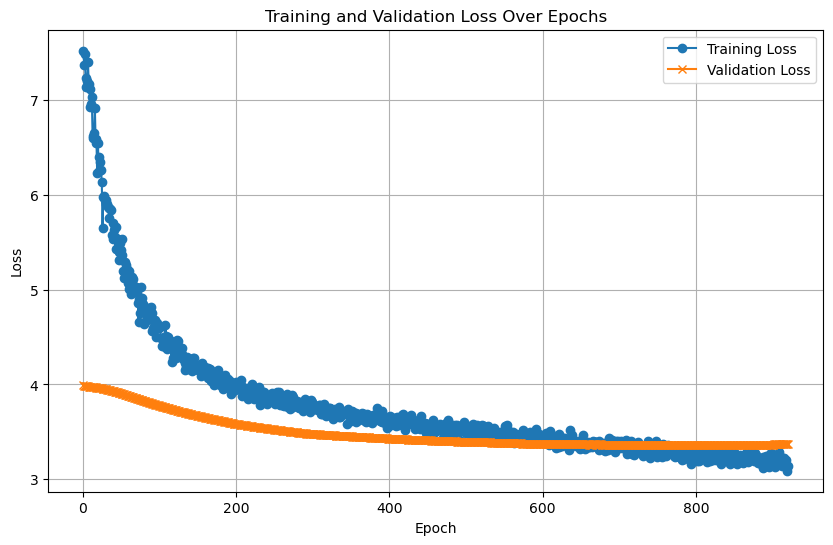

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/20], Loss: 5.1294
Test Batch [20/20], Loss: 4.9235

Test Loss: 4.8220


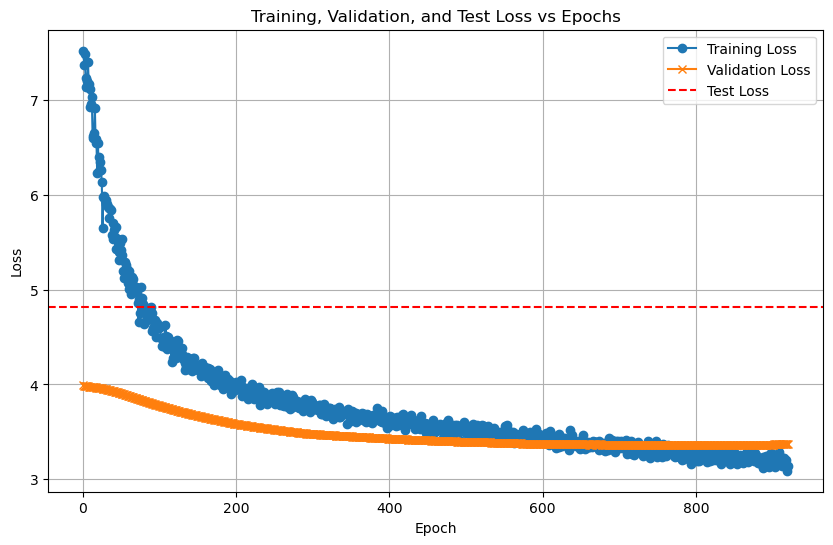

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.
  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (65, 128)
Train labels shape: (65,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5081, 128)
Test labels shape: (5081,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 38.46%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.33      0.20      0.25         5
           2       0.33      0.60      0.43         5
           3       0.00      0.00      0.00         5
           4       0.50      0.60      0.55         5
           5       0.17      0.40      0.24         5
           6       0.67      0.40      0.50         5
           7       0.17      0.40      0.24         5
           8       0.60      0.60      0.60         5
           9       0.00      0.00      0.00         5
          10       1.00      1.00      1.00         5
          11       0.00      0.00      0.00         5
          12       0.60      0.60      0.60         5

    accuracy         

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (65, 128)
Train labels shape: (65,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5081, 128)
Test labels shape: (5081,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6543  |  Val Loss: 2.5868
Validation loss improved from inf to 2.5868.
[Epoch 2/1000] Train Loss: 2.6396  |  Val Loss: 2.5851
Validation loss improved from 2.5868 to 2.5851.
[Epoch 3/1000] Train Loss: 2.6276  |  Val Loss: 2.5835
Validation loss improved from 2.5851 to 2.5835.
[Epoch 4/1000] Train Loss: 2.6162  |  Val Loss: 2.5820
Validation loss improved from 2.5835 to 2.5820.
[Epoch 5/1000] Train Loss: 2.6062  |  Val Loss: 2.5805
Validation loss improved from 2.5820 to 2.5805.
[Epoch 6/1000] Train Loss: 2.5980  |  Val Loss: 2.5791
Validation loss improved from 2.5805 to 2.5791.
[Epoch 7/1000] Train Loss: 2.5897  |  Val Loss: 2.5778
Validation loss improved from 2.5791 to 2.5778.
[Epoch 8/1000] Train Loss: 2.5820  |  Val Loss: 2.5766
Validation loss improved from 2.5778 to 2.5766.
[Epoch 9/1000] Train Loss: 2.5748  |  Val Loss: 2.5754
Validation loss improved from 2.5766 to 2.5754.
[Epoch 10/1000] Train Loss: 2.5679  |  Val Loss: 2.5744
Validation loss impr

[Epoch 27/1000] Train Loss: 2.4944  |  Val Loss: 2.5624
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 28/1000] Train Loss: 2.4920  |  Val Loss: 2.5622
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 29/1000] Train Loss: 2.4897  |  Val Loss: 2.5620
Validation loss improved from 2.5622 to 2.5620.
[Epoch 30/1000] Train Loss: 2.4875  |  Val Loss: 2.5617
Validation loss improved from 2.5620 to 2.5617.
[Epoch 31/1000] Train Loss: 2.4854  |  Val Loss: 2.5613
Validation loss improved from 2.5617 to 2.5613.
[Epoch 32/1000] Train Loss: 2.4834  |  Val Loss: 2.5608
Validation loss improved from 2.5613 to 2.5608.
[Epoch 33/1000] Train Loss: 2.4811  |  Val Loss: 2.5600
Validation loss improved from 2.5608 to 2.5600.
[Epoch 34/1000] Train Loss: 2.4788  |  Val Loss: 2.5593
Validation loss improved from 2.5600 to 2.5593.
[Epoch 35/1000] Train Loss: 2.4766  |  Val Loss: 2.5587
Validation loss improved from 2.5593 to 2.5587.
[Epoch 36/1000] Train Loss: 2.4742  |  Val Loss: 2.5

[Epoch 38/1000] Train Loss: 2.4675  |  Val Loss: 2.5556
Validation loss improved from 2.5567 to 2.5556.
[Epoch 39/1000] Train Loss: 2.4645  |  Val Loss: 2.5546
Validation loss improved from 2.5556 to 2.5546.
[Epoch 40/1000] Train Loss: 2.4622  |  Val Loss: 2.5538
Validation loss improved from 2.5546 to 2.5538.
[Epoch 41/1000] Train Loss: 2.4604  |  Val Loss: 2.5530
Validation loss improved from 2.5538 to 2.5530.
[Epoch 42/1000] Train Loss: 2.4588  |  Val Loss: 2.5524
Validation loss improved from 2.5530 to 2.5524.
[Epoch 43/1000] Train Loss: 2.4574  |  Val Loss: 2.5518
Validation loss improved from 2.5524 to 2.5518.
[Epoch 44/1000] Train Loss: 2.4561  |  Val Loss: 2.5514
Validation loss improved from 2.5518 to 2.5514.
[Epoch 45/1000] Train Loss: 2.4550  |  Val Loss: 2.5509
Validation loss improved from 2.5514 to 2.5509.
[Epoch 46/1000] Train Loss: 2.4538  |  Val Loss: 2.5502
Validation loss improved from 2.5509 to 2.5502.
[Epoch 47/1000] Train Loss: 2.4527  |  Val Loss: 2.5494
Validati

[Epoch 69/1000] Train Loss: 2.4306  |  Val Loss: 2.5451
Validation loss improved from 2.5454 to 2.5451.
[Epoch 70/1000] Train Loss: 2.4296  |  Val Loss: 2.5449
Validation loss improved from 2.5451 to 2.5449.
[Epoch 71/1000] Train Loss: 2.4286  |  Val Loss: 2.5446
Validation loss improved from 2.5449 to 2.5446.
[Epoch 72/1000] Train Loss: 2.4277  |  Val Loss: 2.5443
Validation loss improved from 2.5446 to 2.5443.
[Epoch 73/1000] Train Loss: 2.4268  |  Val Loss: 2.5441
Validation loss improved from 2.5443 to 2.5441.
[Epoch 74/1000] Train Loss: 2.4260  |  Val Loss: 2.5438
Validation loss improved from 2.5441 to 2.5438.
[Epoch 75/1000] Train Loss: 2.4251  |  Val Loss: 2.5436
Validation loss improved from 2.5438 to 2.5436.
[Epoch 76/1000] Train Loss: 2.4243  |  Val Loss: 2.5433
Validation loss improved from 2.5436 to 2.5433.
[Epoch 77/1000] Train Loss: 2.4235  |  Val Loss: 2.5431
Validation loss improved from 2.5433 to 2.5431.
[Epoch 78/1000] Train Loss: 2.4227  |  Val Loss: 2.5429
Validati

[Epoch 80/1000] Train Loss: 2.4212  |  Val Loss: 2.5425
Validation loss improved from 2.5427 to 2.5425.
[Epoch 81/1000] Train Loss: 2.4205  |  Val Loss: 2.5423
Validation loss improved from 2.5425 to 2.5423.
[Epoch 82/1000] Train Loss: 2.4197  |  Val Loss: 2.5421
Validation loss improved from 2.5423 to 2.5421.
[Epoch 83/1000] Train Loss: 2.4189  |  Val Loss: 2.5420
Validation loss improved from 2.5421 to 2.5420.
[Epoch 84/1000] Train Loss: 2.4181  |  Val Loss: 2.5419
Validation loss improved from 2.5420 to 2.5419.
[Epoch 85/1000] Train Loss: 2.4174  |  Val Loss: 2.5418
Validation loss improved from 2.5419 to 2.5418.
[Epoch 86/1000] Train Loss: 2.4165  |  Val Loss: 2.5418
Validation loss improved from 2.5418 to 2.5418.
[Epoch 87/1000] Train Loss: 2.4158  |  Val Loss: 2.5418
Validation loss improved from 2.5418 to 2.5418.
[Epoch 88/1000] Train Loss: 2.4150  |  Val Loss: 2.5417
Validation loss improved from 2.5418 to 2.5417.
[Epoch 89/1000] Train Loss: 2.4142  |  Val Loss: 2.5417
Validati

[Epoch 108/1000] Train Loss: 2.3989  |  Val Loss: 2.5433
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 109/1000] Train Loss: 2.3981  |  Val Loss: 2.5431
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 110/1000] Train Loss: 2.3972  |  Val Loss: 2.5428
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 111/1000] Train Loss: 2.3964  |  Val Loss: 2.5426
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 112/1000] Train Loss: 2.3955  |  Val Loss: 2.5424
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 113/1000] Train Loss: 2.3947  |  Val Loss: 2.5420
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 114/1000] Train Loss: 2.3939  |  Val Loss: 2.5416
Validation loss improved from 2.5417 to 2.5416.
[Epoch 115/1000] Train Loss: 2.3931  |  Val Loss: 2.5418
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 116/1000] Train Loss: 2.3923  |  Val Loss: 2.5424
!! Validation loss did NOT improve !! Patience: 2/100
[

[Epoch 125/1000] Train Loss: 2.3840  |  Val Loss: 2.5421
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 126/1000] Train Loss: 2.3824  |  Val Loss: 2.5416
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 127/1000] Train Loss: 2.3806  |  Val Loss: 2.5410
Validation loss improved from 2.5416 to 2.5410.
[Epoch 128/1000] Train Loss: 2.3791  |  Val Loss: 2.5405
Validation loss improved from 2.5410 to 2.5405.
[Epoch 129/1000] Train Loss: 2.3777  |  Val Loss: 2.5400
Validation loss improved from 2.5405 to 2.5400.
[Epoch 130/1000] Train Loss: 2.3765  |  Val Loss: 2.5395
Validation loss improved from 2.5400 to 2.5395.
[Epoch 131/1000] Train Loss: 2.3753  |  Val Loss: 2.5390
Validation loss improved from 2.5395 to 2.5390.
[Epoch 132/1000] Train Loss: 2.3743  |  Val Loss: 2.5385
Validation loss improved from 2.5390 to 2.5385.
[Epoch 133/1000] Train Loss: 2.3733  |  Val Loss: 2.5380
Validation loss improved from 2.5385 to 2.5380.
[Epoch 134/1000] Train Loss: 2.3724  |  V

[Epoch 153/1000] Train Loss: 2.3556  |  Val Loss: 2.5350
Validation loss improved from 2.5354 to 2.5350.
[Epoch 154/1000] Train Loss: 2.3548  |  Val Loss: 2.5345
Validation loss improved from 2.5350 to 2.5345.
[Epoch 155/1000] Train Loss: 2.3538  |  Val Loss: 2.5339
Validation loss improved from 2.5345 to 2.5339.
[Epoch 156/1000] Train Loss: 2.3526  |  Val Loss: 2.5334
Validation loss improved from 2.5339 to 2.5334.
[Epoch 157/1000] Train Loss: 2.3516  |  Val Loss: 2.5329
Validation loss improved from 2.5334 to 2.5329.
[Epoch 158/1000] Train Loss: 2.3507  |  Val Loss: 2.5323
Validation loss improved from 2.5329 to 2.5323.
[Epoch 159/1000] Train Loss: 2.3498  |  Val Loss: 2.5319
Validation loss improved from 2.5323 to 2.5319.
[Epoch 160/1000] Train Loss: 2.3489  |  Val Loss: 2.5314
Validation loss improved from 2.5319 to 2.5314.
[Epoch 161/1000] Train Loss: 2.3480  |  Val Loss: 2.5309
Validation loss improved from 2.5314 to 2.5309.
[Epoch 162/1000] Train Loss: 2.3472  |  Val Loss: 2.530

[Epoch 170/1000] Train Loss: 2.3409  |  Val Loss: 2.5271
Validation loss improved from 2.5275 to 2.5271.
[Epoch 171/1000] Train Loss: 2.3401  |  Val Loss: 2.5266
Validation loss improved from 2.5271 to 2.5266.
[Epoch 172/1000] Train Loss: 2.3392  |  Val Loss: 2.5261
Validation loss improved from 2.5266 to 2.5261.
[Epoch 173/1000] Train Loss: 2.3382  |  Val Loss: 2.5256
Validation loss improved from 2.5261 to 2.5256.
[Epoch 174/1000] Train Loss: 2.3374  |  Val Loss: 2.5250
Validation loss improved from 2.5256 to 2.5250.
[Epoch 175/1000] Train Loss: 2.3365  |  Val Loss: 2.5245
Validation loss improved from 2.5250 to 2.5245.
[Epoch 176/1000] Train Loss: 2.3357  |  Val Loss: 2.5239
Validation loss improved from 2.5245 to 2.5239.
[Epoch 177/1000] Train Loss: 2.3348  |  Val Loss: 2.5234
Validation loss improved from 2.5239 to 2.5234.
[Epoch 178/1000] Train Loss: 2.3340  |  Val Loss: 2.5229
Validation loss improved from 2.5234 to 2.5229.
[Epoch 179/1000] Train Loss: 2.3332  |  Val Loss: 2.522

[Epoch 199/1000] Train Loss: 2.3209  |  Val Loss: 2.5113
Validation loss improved from 2.5117 to 2.5113.
[Epoch 200/1000] Train Loss: 2.3201  |  Val Loss: 2.5109
Validation loss improved from 2.5113 to 2.5109.
[Epoch 201/1000] Train Loss: 2.3192  |  Val Loss: 2.5106
Validation loss improved from 2.5109 to 2.5106.
[Epoch 202/1000] Train Loss: 2.3184  |  Val Loss: 2.5103
Validation loss improved from 2.5106 to 2.5103.
[Epoch 203/1000] Train Loss: 2.3175  |  Val Loss: 2.5100
Validation loss improved from 2.5103 to 2.5100.
[Epoch 204/1000] Train Loss: 2.3167  |  Val Loss: 2.5097
Validation loss improved from 2.5100 to 2.5097.
[Epoch 205/1000] Train Loss: 2.3159  |  Val Loss: 2.5094
Validation loss improved from 2.5097 to 2.5094.
[Epoch 206/1000] Train Loss: 2.3150  |  Val Loss: 2.5090
Validation loss improved from 2.5094 to 2.5090.
[Epoch 207/1000] Train Loss: 2.3141  |  Val Loss: 2.5088
Validation loss improved from 2.5090 to 2.5088.
[Epoch 208/1000] Train Loss: 2.3131  |  Val Loss: 2.508

[Epoch 215/1000] Train Loss: 2.3079  |  Val Loss: 2.5037
Validation loss improved from 2.5049 to 2.5037.
[Epoch 216/1000] Train Loss: 2.3084  |  Val Loss: 2.5027
Validation loss improved from 2.5037 to 2.5027.
[Epoch 217/1000] Train Loss: 2.3091  |  Val Loss: 2.5020
Validation loss improved from 2.5027 to 2.5020.
[Epoch 218/1000] Train Loss: 2.3096  |  Val Loss: 2.5013
Validation loss improved from 2.5020 to 2.5013.
[Epoch 219/1000] Train Loss: 2.3099  |  Val Loss: 2.5007
Validation loss improved from 2.5013 to 2.5007.
[Epoch 220/1000] Train Loss: 2.3098  |  Val Loss: 2.5001
Validation loss improved from 2.5007 to 2.5001.
[Epoch 221/1000] Train Loss: 2.3094  |  Val Loss: 2.4995
Validation loss improved from 2.5001 to 2.4995.
[Epoch 222/1000] Train Loss: 2.3087  |  Val Loss: 2.4990
Validation loss improved from 2.4995 to 2.4990.
[Epoch 223/1000] Train Loss: 2.3077  |  Val Loss: 2.4985
Validation loss improved from 2.4990 to 2.4985.
[Epoch 224/1000] Train Loss: 2.3065  |  Val Loss: 2.498

[Epoch 241/1000] Train Loss: 2.2788  |  Val Loss: 2.5033
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 242/1000] Train Loss: 2.2784  |  Val Loss: 2.5038
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 243/1000] Train Loss: 2.2780  |  Val Loss: 2.5041
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 244/1000] Train Loss: 2.2774  |  Val Loss: 2.5042
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 245/1000] Train Loss: 2.2767  |  Val Loss: 2.5043
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 246/1000] Train Loss: 2.2760  |  Val Loss: 2.5044
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 247/1000] Train Loss: 2.2752  |  Val Loss: 2.5045
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 248/1000] Train Loss: 2.2744  |  Val Loss: 2.5038
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 249/1000] Train Loss: 2.2732  |  Val Loss: 2.5025
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 254/1000] Train Loss: 2.2658  |  Val Loss: 2.4942
Validation loss improved from 2.4958 to 2.4942.
[Epoch 255/1000] Train Loss: 2.2645  |  Val Loss: 2.4928
Validation loss improved from 2.4942 to 2.4928.
[Epoch 256/1000] Train Loss: 2.2634  |  Val Loss: 2.4917
Validation loss improved from 2.4928 to 2.4917.
[Epoch 257/1000] Train Loss: 2.2624  |  Val Loss: 2.4907
Validation loss improved from 2.4917 to 2.4907.
[Epoch 258/1000] Train Loss: 2.2615  |  Val Loss: 2.4898
Validation loss improved from 2.4907 to 2.4898.
[Epoch 259/1000] Train Loss: 2.2606  |  Val Loss: 2.4891
Validation loss improved from 2.4898 to 2.4891.
[Epoch 260/1000] Train Loss: 2.2596  |  Val Loss: 2.4883
Validation loss improved from 2.4891 to 2.4883.
[Epoch 261/1000] Train Loss: 2.2586  |  Val Loss: 2.4876
Validation loss improved from 2.4883 to 2.4876.
[Epoch 262/1000] Train Loss: 2.2576  |  Val Loss: 2.4869
Validation loss improved from 2.4876 to 2.4869.
[Epoch 263/1000] Train Loss: 2.2563  |  Val Loss: 2.486

[Epoch 282/1000] Train Loss: 2.2382  |  Val Loss: 2.4763
Validation loss improved from 2.4766 to 2.4763.
[Epoch 283/1000] Train Loss: 2.2371  |  Val Loss: 2.4760
Validation loss improved from 2.4763 to 2.4760.
[Epoch 284/1000] Train Loss: 2.2361  |  Val Loss: 2.4758
Validation loss improved from 2.4760 to 2.4758.
[Epoch 285/1000] Train Loss: 2.2351  |  Val Loss: 2.4756
Validation loss improved from 2.4758 to 2.4756.
[Epoch 286/1000] Train Loss: 2.2340  |  Val Loss: 2.4754
Validation loss improved from 2.4756 to 2.4754.
[Epoch 287/1000] Train Loss: 2.2331  |  Val Loss: 2.4751
Validation loss improved from 2.4754 to 2.4751.
[Epoch 288/1000] Train Loss: 2.2322  |  Val Loss: 2.4748
Validation loss improved from 2.4751 to 2.4748.
[Epoch 289/1000] Train Loss: 2.2313  |  Val Loss: 2.4744
Validation loss improved from 2.4748 to 2.4744.
[Epoch 290/1000] Train Loss: 2.2304  |  Val Loss: 2.4740
Validation loss improved from 2.4744 to 2.4740.
[Epoch 291/1000] Train Loss: 2.2295  |  Val Loss: 2.473

[Epoch 297/1000] Train Loss: 2.2237  |  Val Loss: 2.4702
Validation loss improved from 2.4706 to 2.4702.
[Epoch 298/1000] Train Loss: 2.2228  |  Val Loss: 2.4698
Validation loss improved from 2.4702 to 2.4698.
[Epoch 299/1000] Train Loss: 2.2218  |  Val Loss: 2.4693
Validation loss improved from 2.4698 to 2.4693.
[Epoch 300/1000] Train Loss: 2.2208  |  Val Loss: 2.4689
Validation loss improved from 2.4693 to 2.4689.
[Epoch 301/1000] Train Loss: 2.2200  |  Val Loss: 2.4687
Validation loss improved from 2.4689 to 2.4687.
[Epoch 302/1000] Train Loss: 2.2191  |  Val Loss: 2.4685
Validation loss improved from 2.4687 to 2.4685.
[Epoch 303/1000] Train Loss: 2.2181  |  Val Loss: 2.4683
Validation loss improved from 2.4685 to 2.4683.
[Epoch 304/1000] Train Loss: 2.2169  |  Val Loss: 2.4681
Validation loss improved from 2.4683 to 2.4681.
[Epoch 305/1000] Train Loss: 2.2158  |  Val Loss: 2.4678
Validation loss improved from 2.4681 to 2.4678.
[Epoch 306/1000] Train Loss: 2.2146  |  Val Loss: 2.467

[Epoch 317/1000] Train Loss: 2.2005  |  Val Loss: 2.4637
Validation loss improved from 2.4641 to 2.4637.
[Epoch 318/1000] Train Loss: 2.1995  |  Val Loss: 2.4634
Validation loss improved from 2.4637 to 2.4634.
[Epoch 319/1000] Train Loss: 2.1984  |  Val Loss: 2.4632
Validation loss improved from 2.4634 to 2.4632.
[Epoch 320/1000] Train Loss: 2.1974  |  Val Loss: 2.4628
Validation loss improved from 2.4632 to 2.4628.
[Epoch 321/1000] Train Loss: 2.1965  |  Val Loss: 2.4632
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 322/1000] Train Loss: 2.1961  |  Val Loss: 2.4643
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 323/1000] Train Loss: 2.1968  |  Val Loss: 2.4651
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 324/1000] Train Loss: 2.1979  |  Val Loss: 2.4656
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 325/1000] Train Loss: 2.1987  |  Val Loss: 2.4658
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 326/1000] Train Lo

[Epoch 337/1000] Train Loss: 2.1805  |  Val Loss: 2.4506
Validation loss improved from 2.4537 to 2.4506.
[Epoch 338/1000] Train Loss: 2.1798  |  Val Loss: 2.4484
Validation loss improved from 2.4506 to 2.4484.
[Epoch 339/1000] Train Loss: 2.1809  |  Val Loss: 2.4469
Validation loss improved from 2.4484 to 2.4469.
[Epoch 340/1000] Train Loss: 2.1840  |  Val Loss: 2.4457
Validation loss improved from 2.4469 to 2.4457.
[Epoch 341/1000] Train Loss: 2.1873  |  Val Loss: 2.4447
Validation loss improved from 2.4457 to 2.4447.
[Epoch 342/1000] Train Loss: 2.1902  |  Val Loss: 2.4438
Validation loss improved from 2.4447 to 2.4438.
[Epoch 343/1000] Train Loss: 2.1924  |  Val Loss: 2.4430
Validation loss improved from 2.4438 to 2.4430.
[Epoch 344/1000] Train Loss: 2.1939  |  Val Loss: 2.4423
Validation loss improved from 2.4430 to 2.4423.
[Epoch 345/1000] Train Loss: 2.1951  |  Val Loss: 2.4418
Validation loss improved from 2.4423 to 2.4418.
[Epoch 346/1000] Train Loss: 2.1957  |  Val Loss: 2.441

[Epoch 355/1000] Train Loss: 2.1718  |  Val Loss: 2.4415
Validation loss improved from 2.4418 to 2.4415.
[Epoch 356/1000] Train Loss: 2.1697  |  Val Loss: 2.4411
Validation loss improved from 2.4415 to 2.4411.
[Epoch 357/1000] Train Loss: 2.1678  |  Val Loss: 2.4405
Validation loss improved from 2.4411 to 2.4405.
[Epoch 358/1000] Train Loss: 2.1661  |  Val Loss: 2.4399
Validation loss improved from 2.4405 to 2.4399.
[Epoch 359/1000] Train Loss: 2.1646  |  Val Loss: 2.4393
Validation loss improved from 2.4399 to 2.4393.
[Epoch 360/1000] Train Loss: 2.1630  |  Val Loss: 2.4387
Validation loss improved from 2.4393 to 2.4387.
[Epoch 361/1000] Train Loss: 2.1615  |  Val Loss: 2.4381
Validation loss improved from 2.4387 to 2.4381.
[Epoch 362/1000] Train Loss: 2.1599  |  Val Loss: 2.4375
Validation loss improved from 2.4381 to 2.4375.
[Epoch 363/1000] Train Loss: 2.1582  |  Val Loss: 2.4369
Validation loss improved from 2.4375 to 2.4369.
[Epoch 364/1000] Train Loss: 2.1567  |  Val Loss: 2.436

[Epoch 376/1000] Train Loss: 2.1432  |  Val Loss: 2.4261
Validation loss improved from 2.4266 to 2.4261.
[Epoch 377/1000] Train Loss: 2.1418  |  Val Loss: 2.4257
Validation loss improved from 2.4261 to 2.4257.
[Epoch 378/1000] Train Loss: 2.1403  |  Val Loss: 2.4253
Validation loss improved from 2.4257 to 2.4253.
[Epoch 379/1000] Train Loss: 2.1388  |  Val Loss: 2.4248
Validation loss improved from 2.4253 to 2.4248.
[Epoch 380/1000] Train Loss: 2.1373  |  Val Loss: 2.4243
Validation loss improved from 2.4248 to 2.4243.
[Epoch 381/1000] Train Loss: 2.1357  |  Val Loss: 2.4237
Validation loss improved from 2.4243 to 2.4237.
[Epoch 382/1000] Train Loss: 2.1341  |  Val Loss: 2.4232
Validation loss improved from 2.4237 to 2.4232.
[Epoch 383/1000] Train Loss: 2.1326  |  Val Loss: 2.4226
Validation loss improved from 2.4232 to 2.4226.
[Epoch 384/1000] Train Loss: 2.1312  |  Val Loss: 2.4219
Validation loss improved from 2.4226 to 2.4219.
[Epoch 385/1000] Train Loss: 2.1299  |  Val Loss: 2.421

[Epoch 398/1000] Train Loss: 2.1156  |  Val Loss: 2.4092
Validation loss improved from 2.4107 to 2.4092.
[Epoch 399/1000] Train Loss: 2.1156  |  Val Loss: 2.4080
Validation loss improved from 2.4092 to 2.4080.
[Epoch 400/1000] Train Loss: 2.1155  |  Val Loss: 2.4071
Validation loss improved from 2.4080 to 2.4071.
[Epoch 401/1000] Train Loss: 2.1151  |  Val Loss: 2.4063
Validation loss improved from 2.4071 to 2.4063.
[Epoch 402/1000] Train Loss: 2.1145  |  Val Loss: 2.4057
Validation loss improved from 2.4063 to 2.4057.
[Epoch 403/1000] Train Loss: 2.1136  |  Val Loss: 2.4052
Validation loss improved from 2.4057 to 2.4052.
[Epoch 404/1000] Train Loss: 2.1124  |  Val Loss: 2.4049
Validation loss improved from 2.4052 to 2.4049.
[Epoch 405/1000] Train Loss: 2.1111  |  Val Loss: 2.4046
Validation loss improved from 2.4049 to 2.4046.
[Epoch 406/1000] Train Loss: 2.1096  |  Val Loss: 2.4042
Validation loss improved from 2.4046 to 2.4042.
[Epoch 407/1000] Train Loss: 2.1080  |  Val Loss: 2.404

[Epoch 423/1000] Train Loss: 2.0934  |  Val Loss: 2.4088
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 424/1000] Train Loss: 2.0942  |  Val Loss: 2.4102
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 425/1000] Train Loss: 2.0955  |  Val Loss: 2.4110
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 426/1000] Train Loss: 2.0962  |  Val Loss: 2.4113
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 427/1000] Train Loss: 2.0962  |  Val Loss: 2.4112
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 428/1000] Train Loss: 2.0956  |  Val Loss: 2.4109
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 429/1000] Train Loss: 2.0946  |  Val Loss: 2.4104
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 430/1000] Train Loss: 2.0933  |  Val Loss: 2.4098
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 431/1000] Train Loss: 2.0916  |  Val Loss: 2.4090
!! Validation loss did NOT improve !! Patience: 15

[Epoch 442/1000] Train Loss: 2.0671  |  Val Loss: 2.3962
Validation loss improved from 2.3976 to 2.3962.
[Epoch 443/1000] Train Loss: 2.0656  |  Val Loss: 2.3950
Validation loss improved from 2.3962 to 2.3950.
[Epoch 444/1000] Train Loss: 2.0642  |  Val Loss: 2.3938
Validation loss improved from 2.3950 to 2.3938.
[Epoch 445/1000] Train Loss: 2.0627  |  Val Loss: 2.3927
Validation loss improved from 2.3938 to 2.3927.
[Epoch 446/1000] Train Loss: 2.0613  |  Val Loss: 2.3915
Validation loss improved from 2.3927 to 2.3915.
[Epoch 447/1000] Train Loss: 2.0599  |  Val Loss: 2.3901
Validation loss improved from 2.3915 to 2.3901.
[Epoch 448/1000] Train Loss: 2.0587  |  Val Loss: 2.3885
Validation loss improved from 2.3901 to 2.3885.
[Epoch 449/1000] Train Loss: 2.0576  |  Val Loss: 2.3871
Validation loss improved from 2.3885 to 2.3871.
[Epoch 450/1000] Train Loss: 2.0564  |  Val Loss: 2.3858
Validation loss improved from 2.3871 to 2.3858.
[Epoch 451/1000] Train Loss: 2.0553  |  Val Loss: 2.384

[Epoch 462/1000] Train Loss: 2.0412  |  Val Loss: 2.3792
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 463/1000] Train Loss: 2.0415  |  Val Loss: 2.3791
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 464/1000] Train Loss: 2.0407  |  Val Loss: 2.3785
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 465/1000] Train Loss: 2.0396  |  Val Loss: 2.3779
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 466/1000] Train Loss: 2.0385  |  Val Loss: 2.3773
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 467/1000] Train Loss: 2.0373  |  Val Loss: 2.3766
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 468/1000] Train Loss: 2.0359  |  Val Loss: 2.3757
Validation loss improved from 2.3764 to 2.3757.
[Epoch 469/1000] Train Loss: 2.0344  |  Val Loss: 2.3745
Validation loss improved from 2.3757 to 2.3745.
[Epoch 470/1000] Train Loss: 2.0328  |  Val Loss: 2.3731
Validation loss improved from 2.3745 to 2.3731.
[Epoch 471/1000] Tr

[Epoch 482/1000] Train Loss: 2.0170  |  Val Loss: 2.3583
Validation loss improved from 2.3598 to 2.3583.
[Epoch 483/1000] Train Loss: 2.0165  |  Val Loss: 2.3570
Validation loss improved from 2.3583 to 2.3570.
[Epoch 484/1000] Train Loss: 2.0162  |  Val Loss: 2.3557
Validation loss improved from 2.3570 to 2.3557.
[Epoch 485/1000] Train Loss: 2.0158  |  Val Loss: 2.3543
Validation loss improved from 2.3557 to 2.3543.
[Epoch 486/1000] Train Loss: 2.0155  |  Val Loss: 2.3531
Validation loss improved from 2.3543 to 2.3531.
[Epoch 487/1000] Train Loss: 2.0150  |  Val Loss: 2.3532
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 488/1000] Train Loss: 2.0116  |  Val Loss: 2.3545
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 489/1000] Train Loss: 2.0084  |  Val Loss: 2.3554
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 490/1000] Train Loss: 2.0069  |  Val Loss: 2.3568
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 491/1000] Train Loss: 2.

[Epoch 499/1000] Train Loss: 2.0167  |  Val Loss: 2.3519
Validation loss improved from 2.3531 to 2.3519.
[Epoch 500/1000] Train Loss: 2.0137  |  Val Loss: 2.3499
Validation loss improved from 2.3519 to 2.3499.
[Epoch 501/1000] Train Loss: 2.0105  |  Val Loss: 2.3480
Validation loss improved from 2.3499 to 2.3480.
[Epoch 502/1000] Train Loss: 2.0072  |  Val Loss: 2.3463
Validation loss improved from 2.3480 to 2.3463.
[Epoch 503/1000] Train Loss: 2.0040  |  Val Loss: 2.3446
Validation loss improved from 2.3463 to 2.3446.
[Epoch 504/1000] Train Loss: 2.0010  |  Val Loss: 2.3427
Validation loss improved from 2.3446 to 2.3427.
[Epoch 505/1000] Train Loss: 1.9976  |  Val Loss: 2.3407
Validation loss improved from 2.3427 to 2.3407.
[Epoch 506/1000] Train Loss: 1.9943  |  Val Loss: 2.3390
Validation loss improved from 2.3407 to 2.3390.
[Epoch 507/1000] Train Loss: 1.9915  |  Val Loss: 2.3373
Validation loss improved from 2.3390 to 2.3373.
[Epoch 508/1000] Train Loss: 1.9890  |  Val Loss: 2.335

[Epoch 520/1000] Train Loss: 1.9708  |  Val Loss: 2.3239
Validation loss improved from 2.3246 to 2.3239.
[Epoch 521/1000] Train Loss: 1.9700  |  Val Loss: 2.3230
Validation loss improved from 2.3239 to 2.3230.
[Epoch 522/1000] Train Loss: 1.9691  |  Val Loss: 2.3222
Validation loss improved from 2.3230 to 2.3222.
[Epoch 523/1000] Train Loss: 1.9681  |  Val Loss: 2.3211
Validation loss improved from 2.3222 to 2.3211.
[Epoch 524/1000] Train Loss: 1.9668  |  Val Loss: 2.3201
Validation loss improved from 2.3211 to 2.3201.
[Epoch 525/1000] Train Loss: 1.9659  |  Val Loss: 2.3193
Validation loss improved from 2.3201 to 2.3193.
[Epoch 526/1000] Train Loss: 1.9658  |  Val Loss: 2.3190
Validation loss improved from 2.3193 to 2.3190.
[Epoch 527/1000] Train Loss: 1.9659  |  Val Loss: 2.3189
Validation loss improved from 2.3190 to 2.3189.
[Epoch 528/1000] Train Loss: 1.9656  |  Val Loss: 2.3187
Validation loss improved from 2.3189 to 2.3187.
[Epoch 529/1000] Train Loss: 1.9650  |  Val Loss: 2.318

[Epoch 535/1000] Train Loss: 1.9565  |  Val Loss: 2.3163
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 536/1000] Train Loss: 1.9525  |  Val Loss: 2.3178
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 537/1000] Train Loss: 1.9491  |  Val Loss: 2.3196
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 538/1000] Train Loss: 1.9485  |  Val Loss: 2.3211
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 539/1000] Train Loss: 1.9494  |  Val Loss: 2.3220
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 540/1000] Train Loss: 1.9508  |  Val Loss: 2.3226
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 541/1000] Train Loss: 1.9523  |  Val Loss: 2.3232
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 542/1000] Train Loss: 1.9537  |  Val Loss: 2.3235
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 543/1000] Train Loss: 1.9548  |  Val Loss: 2.3236
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 562/1000] Train Loss: 1.9219  |  Val Loss: 2.3007
Validation loss improved from 2.3018 to 2.3007.
[Epoch 563/1000] Train Loss: 1.9206  |  Val Loss: 2.2998
Validation loss improved from 2.3007 to 2.2998.
[Epoch 564/1000] Train Loss: 1.9193  |  Val Loss: 2.2990
Validation loss improved from 2.2998 to 2.2990.
[Epoch 565/1000] Train Loss: 1.9178  |  Val Loss: 2.2982
Validation loss improved from 2.2990 to 2.2982.
[Epoch 566/1000] Train Loss: 1.9164  |  Val Loss: 2.2975
Validation loss improved from 2.2982 to 2.2975.
[Epoch 567/1000] Train Loss: 1.9151  |  Val Loss: 2.2965
Validation loss improved from 2.2975 to 2.2965.
[Epoch 568/1000] Train Loss: 1.9138  |  Val Loss: 2.2966
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 569/1000] Train Loss: 1.9119  |  Val Loss: 2.2980
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 570/1000] Train Loss: 1.9105  |  Val Loss: 2.2994
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 571/1000] Train Loss: 1.9099  

[Epoch 579/1000] Train Loss: 1.9153  |  Val Loss: 2.3096
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 580/1000] Train Loss: 1.9136  |  Val Loss: 2.3094
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 581/1000] Train Loss: 1.9117  |  Val Loss: 2.3089
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 582/1000] Train Loss: 1.9095  |  Val Loss: 2.3080
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 583/1000] Train Loss: 1.9073  |  Val Loss: 2.3066
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 584/1000] Train Loss: 1.9048  |  Val Loss: 2.3051
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 585/1000] Train Loss: 1.9024  |  Val Loss: 2.3036
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 586/1000] Train Loss: 1.9000  |  Val Loss: 2.3022
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 587/1000] Train Loss: 1.8979  |  Val Loss: 2.3006
!! Validation loss did NOT improve !! Patience:

[Epoch 605/1000] Train Loss: 1.8707  |  Val Loss: 2.2735
Validation loss improved from 2.2757 to 2.2735.
[Epoch 606/1000] Train Loss: 1.8698  |  Val Loss: 2.2716
Validation loss improved from 2.2735 to 2.2716.
[Epoch 607/1000] Train Loss: 1.8690  |  Val Loss: 2.2700
Validation loss improved from 2.2716 to 2.2700.
[Epoch 608/1000] Train Loss: 1.8681  |  Val Loss: 2.2687
Validation loss improved from 2.2700 to 2.2687.
[Epoch 609/1000] Train Loss: 1.8671  |  Val Loss: 2.2677
Validation loss improved from 2.2687 to 2.2677.
[Epoch 610/1000] Train Loss: 1.8659  |  Val Loss: 2.2670
Validation loss improved from 2.2677 to 2.2670.
[Epoch 611/1000] Train Loss: 1.8647  |  Val Loss: 2.2667
Validation loss improved from 2.2670 to 2.2667.
[Epoch 612/1000] Train Loss: 1.8633  |  Val Loss: 2.2665
Validation loss improved from 2.2667 to 2.2665.
[Epoch 613/1000] Train Loss: 1.8621  |  Val Loss: 2.2661
Validation loss improved from 2.2665 to 2.2661.
[Epoch 614/1000] Train Loss: 1.8609  |  Val Loss: 2.265

[Epoch 622/1000] Train Loss: 1.8514  |  Val Loss: 2.2583
Validation loss improved from 2.2596 to 2.2583.
[Epoch 623/1000] Train Loss: 1.8502  |  Val Loss: 2.2566
Validation loss improved from 2.2583 to 2.2566.
[Epoch 624/1000] Train Loss: 1.8491  |  Val Loss: 2.2550
Validation loss improved from 2.2566 to 2.2550.
[Epoch 625/1000] Train Loss: 1.8478  |  Val Loss: 2.2536
Validation loss improved from 2.2550 to 2.2536.
[Epoch 626/1000] Train Loss: 1.8467  |  Val Loss: 2.2522
Validation loss improved from 2.2536 to 2.2522.
[Epoch 627/1000] Train Loss: 1.8454  |  Val Loss: 2.2508
Validation loss improved from 2.2522 to 2.2508.
[Epoch 628/1000] Train Loss: 1.8442  |  Val Loss: 2.2497
Validation loss improved from 2.2508 to 2.2497.
[Epoch 629/1000] Train Loss: 1.8429  |  Val Loss: 2.2487
Validation loss improved from 2.2497 to 2.2487.
[Epoch 630/1000] Train Loss: 1.8416  |  Val Loss: 2.2476
Validation loss improved from 2.2487 to 2.2476.
[Epoch 631/1000] Train Loss: 1.8403  |  Val Loss: 2.246

[Epoch 642/1000] Train Loss: 1.8298  |  Val Loss: 2.2389
Validation loss improved from 2.2405 to 2.2389.
[Epoch 643/1000] Train Loss: 1.8285  |  Val Loss: 2.2375
Validation loss improved from 2.2389 to 2.2375.
[Epoch 644/1000] Train Loss: 1.8272  |  Val Loss: 2.2362
Validation loss improved from 2.2375 to 2.2362.
[Epoch 645/1000] Train Loss: 1.8260  |  Val Loss: 2.2347
Validation loss improved from 2.2362 to 2.2347.
[Epoch 646/1000] Train Loss: 1.8248  |  Val Loss: 2.2331
Validation loss improved from 2.2347 to 2.2331.
[Epoch 647/1000] Train Loss: 1.8236  |  Val Loss: 2.2314
Validation loss improved from 2.2331 to 2.2314.
[Epoch 648/1000] Train Loss: 1.8223  |  Val Loss: 2.2297
Validation loss improved from 2.2314 to 2.2297.
[Epoch 649/1000] Train Loss: 1.8210  |  Val Loss: 2.2279
Validation loss improved from 2.2297 to 2.2279.
[Epoch 650/1000] Train Loss: 1.8197  |  Val Loss: 2.2272
Validation loss improved from 2.2279 to 2.2272.
[Epoch 651/1000] Train Loss: 1.8184  |  Val Loss: 2.228

[Epoch 665/1000] Train Loss: 1.8021  |  Val Loss: 2.2178
Validation loss improved from 2.2191 to 2.2178.
[Epoch 666/1000] Train Loss: 1.8008  |  Val Loss: 2.2166
Validation loss improved from 2.2178 to 2.2166.
[Epoch 667/1000] Train Loss: 1.7997  |  Val Loss: 2.2148
Validation loss improved from 2.2166 to 2.2148.
[Epoch 668/1000] Train Loss: 1.7983  |  Val Loss: 2.2128
Validation loss improved from 2.2148 to 2.2128.
[Epoch 669/1000] Train Loss: 1.7971  |  Val Loss: 2.2108
Validation loss improved from 2.2128 to 2.2108.
[Epoch 670/1000] Train Loss: 1.7960  |  Val Loss: 2.2093
Validation loss improved from 2.2108 to 2.2093.
[Epoch 671/1000] Train Loss: 1.7949  |  Val Loss: 2.2080
Validation loss improved from 2.2093 to 2.2080.
[Epoch 672/1000] Train Loss: 1.7938  |  Val Loss: 2.2071
Validation loss improved from 2.2080 to 2.2071.
[Epoch 673/1000] Train Loss: 1.7927  |  Val Loss: 2.2060
Validation loss improved from 2.2071 to 2.2060.
[Epoch 674/1000] Train Loss: 1.7915  |  Val Loss: 2.204

[Epoch 683/1000] Train Loss: 1.7809  |  Val Loss: 2.1908
Validation loss improved from 2.1921 to 2.1908.
[Epoch 684/1000] Train Loss: 1.7795  |  Val Loss: 2.1899
Validation loss improved from 2.1908 to 2.1899.
[Epoch 685/1000] Train Loss: 1.7780  |  Val Loss: 2.1894
Validation loss improved from 2.1899 to 2.1894.
[Epoch 686/1000] Train Loss: 1.7766  |  Val Loss: 2.1891
Validation loss improved from 2.1894 to 2.1891.
[Epoch 687/1000] Train Loss: 1.7752  |  Val Loss: 2.1887
Validation loss improved from 2.1891 to 2.1887.
[Epoch 688/1000] Train Loss: 1.7740  |  Val Loss: 2.1881
Validation loss improved from 2.1887 to 2.1881.
[Epoch 689/1000] Train Loss: 1.7727  |  Val Loss: 2.1893
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 690/1000] Train Loss: 1.7712  |  Val Loss: 2.1915
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 691/1000] Train Loss: 1.7698  |  Val Loss: 2.1932
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 692/1000] Train Loss: 1.7685  

[Epoch 706/1000] Train Loss: 1.7551  |  Val Loss: 2.1946
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 707/1000] Train Loss: 1.7537  |  Val Loss: 2.1935
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 708/1000] Train Loss: 1.7523  |  Val Loss: 2.1930
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 709/1000] Train Loss: 1.7510  |  Val Loss: 2.1926
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 710/1000] Train Loss: 1.7500  |  Val Loss: 2.1919
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 711/1000] Train Loss: 1.7489  |  Val Loss: 2.1908
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 712/1000] Train Loss: 1.7476  |  Val Loss: 2.1893
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 713/1000] Train Loss: 1.7462  |  Val Loss: 2.1874
Validation loss improved from 2.1881 to 2.1874.
[Epoch 714/1000] Train Loss: 1.7447  |  Val Loss: 2.1855
Validation loss improved from 2.1874 to 2.1855.
[Epoch

[Epoch 725/1000] Train Loss: 1.7302  |  Val Loss: 2.1747
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 726/1000] Train Loss: 1.7291  |  Val Loss: 2.1749
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 727/1000] Train Loss: 1.7279  |  Val Loss: 2.1747
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 728/1000] Train Loss: 1.7268  |  Val Loss: 2.1743
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 729/1000] Train Loss: 1.7256  |  Val Loss: 2.1741
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 730/1000] Train Loss: 1.7245  |  Val Loss: 2.1739
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 731/1000] Train Loss: 1.7234  |  Val Loss: 2.1735
Validation loss improved from 2.1737 to 2.1735.
[Epoch 732/1000] Train Loss: 1.7222  |  Val Loss: 2.1731
Validation loss improved from 2.1735 to 2.1731.
[Epoch 733/1000] Train Loss: 1.7210  |  Val Loss: 2.1731
Validation loss improved from 2.1731 to 2.1731.
[Epoch 734/1000] Tr

[Epoch 748/1000] Train Loss: 1.7073  |  Val Loss: 2.1704
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 749/1000] Train Loss: 1.7071  |  Val Loss: 2.1712
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 750/1000] Train Loss: 1.7067  |  Val Loss: 2.1704
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 751/1000] Train Loss: 1.7058  |  Val Loss: 2.1694
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 752/1000] Train Loss: 1.7046  |  Val Loss: 2.1684
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 753/1000] Train Loss: 1.7034  |  Val Loss: 2.1665
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 754/1000] Train Loss: 1.7013  |  Val Loss: 2.1623
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 755/1000] Train Loss: 1.6988  |  Val Loss: 2.1569
Validation loss improved from 2.1596 to 2.1569.
[Epoch 756/1000] Train Loss: 1.6968  |  Val Loss: 2.1522
Validation loss improved from 2.1569 to 2.1522.
[Epoch 757/

[Epoch 766/1000] Train Loss: 1.6867  |  Val Loss: 2.1480
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 767/1000] Train Loss: 1.6853  |  Val Loss: 2.1504
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 768/1000] Train Loss: 1.6842  |  Val Loss: 2.1527
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 769/1000] Train Loss: 1.6836  |  Val Loss: 2.1554
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 770/1000] Train Loss: 1.6834  |  Val Loss: 2.1572
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 771/1000] Train Loss: 1.6832  |  Val Loss: 2.1581
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 772/1000] Train Loss: 1.6827  |  Val Loss: 2.1586
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 773/1000] Train Loss: 1.6820  |  Val Loss: 2.1581
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 774/1000] Train Loss: 1.6809  |  Val Loss: 2.1568
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 790/1000] Train Loss: 1.6591  |  Val Loss: 2.1270
Validation loss improved from 2.1283 to 2.1270.
[Epoch 791/1000] Train Loss: 1.6580  |  Val Loss: 2.1262
Validation loss improved from 2.1270 to 2.1262.
[Epoch 792/1000] Train Loss: 1.6568  |  Val Loss: 2.1251
Validation loss improved from 2.1262 to 2.1251.
[Epoch 793/1000] Train Loss: 1.6557  |  Val Loss: 2.1241
Validation loss improved from 2.1251 to 2.1241.
[Epoch 794/1000] Train Loss: 1.6546  |  Val Loss: 2.1234
Validation loss improved from 2.1241 to 2.1234.
[Epoch 795/1000] Train Loss: 1.6536  |  Val Loss: 2.1226
Validation loss improved from 2.1234 to 2.1226.
[Epoch 796/1000] Train Loss: 1.6526  |  Val Loss: 2.1217
Validation loss improved from 2.1226 to 2.1217.
[Epoch 797/1000] Train Loss: 1.6517  |  Val Loss: 2.1210
Validation loss improved from 2.1217 to 2.1210.
[Epoch 798/1000] Train Loss: 1.6509  |  Val Loss: 2.1219
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 799/1000] Train Loss: 1.6501  |  Val Loss:

[Epoch 809/1000] Train Loss: 1.6447  |  Val Loss: 2.1378
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 810/1000] Train Loss: 1.6439  |  Val Loss: 2.1376
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 811/1000] Train Loss: 1.6429  |  Val Loss: 2.1360
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 812/1000] Train Loss: 1.6412  |  Val Loss: 2.1331
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 813/1000] Train Loss: 1.6392  |  Val Loss: 2.1303
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 814/1000] Train Loss: 1.6373  |  Val Loss: 2.1280
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 815/1000] Train Loss: 1.6358  |  Val Loss: 2.1256
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 816/1000] Train Loss: 1.6343  |  Val Loss: 2.1230
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 817/1000] Train Loss: 1.6329  |  Val Loss: 2.1209
Validation loss improved from 2.1210 to 2.1209.

[Epoch 833/1000] Train Loss: 1.6175  |  Val Loss: 2.1104
Validation loss improved from 2.1126 to 2.1104.
[Epoch 834/1000] Train Loss: 1.6165  |  Val Loss: 2.1077
Validation loss improved from 2.1104 to 2.1077.
[Epoch 835/1000] Train Loss: 1.6154  |  Val Loss: 2.1049
Validation loss improved from 2.1077 to 2.1049.
[Epoch 836/1000] Train Loss: 1.6144  |  Val Loss: 2.1025
Validation loss improved from 2.1049 to 2.1025.
[Epoch 837/1000] Train Loss: 1.6134  |  Val Loss: 2.1007
Validation loss improved from 2.1025 to 2.1007.
[Epoch 838/1000] Train Loss: 1.6125  |  Val Loss: 2.0986
Validation loss improved from 2.1007 to 2.0986.
[Epoch 839/1000] Train Loss: 1.6116  |  Val Loss: 2.0959
Validation loss improved from 2.0986 to 2.0959.
[Epoch 840/1000] Train Loss: 1.6104  |  Val Loss: 2.0930
Validation loss improved from 2.0959 to 2.0930.
[Epoch 841/1000] Train Loss: 1.6091  |  Val Loss: 2.0914
Validation loss improved from 2.0930 to 2.0914.
[Epoch 842/1000] Train Loss: 1.6076  |  Val Loss: 2.091

[Epoch 851/1000] Train Loss: 1.5966  |  Val Loss: 2.0830
Validation loss improved from 2.0835 to 2.0830.
[Epoch 852/1000] Train Loss: 1.5955  |  Val Loss: 2.0828
Validation loss improved from 2.0830 to 2.0828.
[Epoch 853/1000] Train Loss: 1.5944  |  Val Loss: 2.0833
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 854/1000] Train Loss: 1.5935  |  Val Loss: 2.0842
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 855/1000] Train Loss: 1.5926  |  Val Loss: 2.0841
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 856/1000] Train Loss: 1.5916  |  Val Loss: 2.0837
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 857/1000] Train Loss: 1.5904  |  Val Loss: 2.0838
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 858/1000] Train Loss: 1.5894  |  Val Loss: 2.0840
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 859/1000] Train Loss: 1.5883  |  Val Loss: 2.0840
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 860/10

[Epoch 871/1000] Train Loss: 1.5756  |  Val Loss: 2.0574
Validation loss improved from 2.0589 to 2.0574.
[Epoch 872/1000] Train Loss: 1.5753  |  Val Loss: 2.0566
Validation loss improved from 2.0574 to 2.0566.
[Epoch 873/1000] Train Loss: 1.5749  |  Val Loss: 2.0560
Validation loss improved from 2.0566 to 2.0560.
[Epoch 874/1000] Train Loss: 1.5744  |  Val Loss: 2.0555
Validation loss improved from 2.0560 to 2.0555.
[Epoch 875/1000] Train Loss: 1.5738  |  Val Loss: 2.0576
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 876/1000] Train Loss: 1.5721  |  Val Loss: 2.0612
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 877/1000] Train Loss: 1.5700  |  Val Loss: 2.0632
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 878/1000] Train Loss: 1.5680  |  Val Loss: 2.0639
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 879/1000] Train Loss: 1.5664  |  Val Loss: 2.0646
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 880/1000] Train Lo

[Epoch 887/1000] Train Loss: 1.5564  |  Val Loss: 2.0668
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 888/1000] Train Loss: 1.5555  |  Val Loss: 2.0664
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 889/1000] Train Loss: 1.5545  |  Val Loss: 2.0642
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 890/1000] Train Loss: 1.5532  |  Val Loss: 2.0615
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 891/1000] Train Loss: 1.5518  |  Val Loss: 2.0591
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 892/1000] Train Loss: 1.5504  |  Val Loss: 2.0566
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 893/1000] Train Loss: 1.5491  |  Val Loss: 2.0548
Validation loss improved from 2.0555 to 2.0548.
[Epoch 894/1000] Train Loss: 1.5480  |  Val Loss: 2.0537
Validation loss improved from 2.0548 to 2.0537.
[Epoch 895/1000] Train Loss: 1.5469  |  Val Loss: 2.0520
Validation loss improved from 2.0537 to 2.0520.
[Epoch 896/10

[Epoch 914/1000] Train Loss: 1.5282  |  Val Loss: 2.0303
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 915/1000] Train Loss: 1.5278  |  Val Loss: 2.0287
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 916/1000] Train Loss: 1.5267  |  Val Loss: 2.0265
Validation loss improved from 2.0277 to 2.0265.
[Epoch 917/1000] Train Loss: 1.5254  |  Val Loss: 2.0249
Validation loss improved from 2.0265 to 2.0249.
[Epoch 918/1000] Train Loss: 1.5242  |  Val Loss: 2.0234
Validation loss improved from 2.0249 to 2.0234.
[Epoch 919/1000] Train Loss: 1.5231  |  Val Loss: 2.0217
Validation loss improved from 2.0234 to 2.0217.
[Epoch 920/1000] Train Loss: 1.5222  |  Val Loss: 2.0202
Validation loss improved from 2.0217 to 2.0202.
[Epoch 921/1000] Train Loss: 1.5213  |  Val Loss: 2.0185
Validation loss improved from 2.0202 to 2.0185.
[Epoch 922/1000] Train Loss: 1.5202  |  Val Loss: 2.0168
Validation loss improved from 2.0185 to 2.0168.
[Epoch 923/1000] Train Loss: 1.5193  |  Val

[Epoch 927/1000] Train Loss: 1.5149  |  Val Loss: 2.0130
Validation loss improved from 2.0140 to 2.0130.
[Epoch 928/1000] Train Loss: 1.5140  |  Val Loss: 2.0117
Validation loss improved from 2.0130 to 2.0117.
[Epoch 929/1000] Train Loss: 1.5131  |  Val Loss: 2.0106
Validation loss improved from 2.0117 to 2.0106.
[Epoch 930/1000] Train Loss: 1.5122  |  Val Loss: 2.0094
Validation loss improved from 2.0106 to 2.0094.
[Epoch 931/1000] Train Loss: 1.5112  |  Val Loss: 2.0099
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 932/1000] Train Loss: 1.5102  |  Val Loss: 2.0117
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 933/1000] Train Loss: 1.5091  |  Val Loss: 2.0127
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 934/1000] Train Loss: 1.5081  |  Val Loss: 2.0121
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 935/1000] Train Loss: 1.5071  |  Val Loss: 2.0111
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 936/1000] Train Lo

[Epoch 956/1000] Train Loss: 1.4890  |  Val Loss: 1.9965
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 957/1000] Train Loss: 1.4883  |  Val Loss: 1.9961
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 958/1000] Train Loss: 1.4874  |  Val Loss: 1.9958
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 959/1000] Train Loss: 1.4865  |  Val Loss: 1.9954
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 960/1000] Train Loss: 1.4856  |  Val Loss: 1.9949
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 961/1000] Train Loss: 1.4847  |  Val Loss: 1.9934
Validation loss improved from 1.9941 to 1.9934.
[Epoch 962/1000] Train Loss: 1.4836  |  Val Loss: 1.9907
Validation loss improved from 1.9934 to 1.9907.
[Epoch 963/1000] Train Loss: 1.4823  |  Val Loss: 1.9881
Validation loss improved from 1.9907 to 1.9881.
[Epoch 964/1000] Train Loss: 1.4812  |  Val Loss: 1.9880
Validation loss improved from 1.9881 to 1.9880.
[Epoch 965/1000] Tra

[Epoch 975/1000] Train Loss: 1.4725  |  Val Loss: 1.9769
Validation loss improved from 1.9774 to 1.9769.
[Epoch 976/1000] Train Loss: 1.4720  |  Val Loss: 1.9773
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 977/1000] Train Loss: 1.4714  |  Val Loss: 1.9780
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 978/1000] Train Loss: 1.4709  |  Val Loss: 1.9791
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 979/1000] Train Loss: 1.4703  |  Val Loss: 1.9803
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 980/1000] Train Loss: 1.4698  |  Val Loss: 1.9818
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 981/1000] Train Loss: 1.4692  |  Val Loss: 1.9830
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 982/1000] Train Loss: 1.4685  |  Val Loss: 1.9836
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 983/1000] Train Loss: 1.4676  |  Val Loss: 1.9844
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 999/1000] Train Loss: 1.4521  |  Val Loss: 1.9798
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 1000/1000] Train Loss: 1.4501  |  Val Loss: 1.9759
Validation loss improved from 1.9769 to 1.9759.


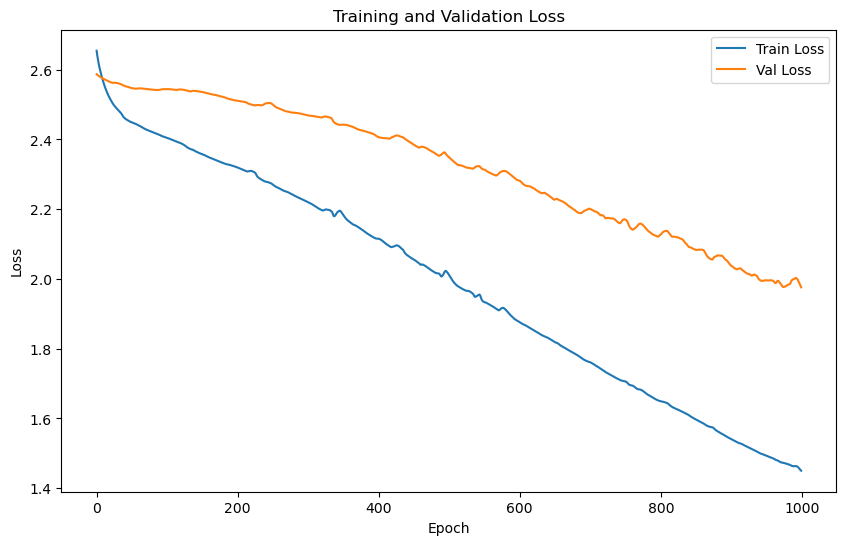

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 2.0766 | Test Accuracy: 33.56%


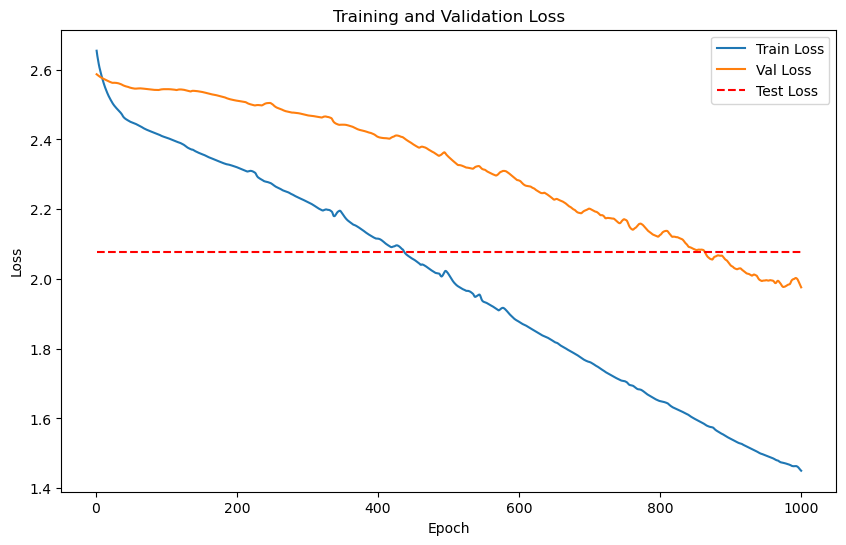

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5081 samples with 64 features each
LOG: Labels shape: (5081,)


Train embeddings shape: (65, 64), 
Train labels shape: (65,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (5081, 64), 
Test labels shape: (5081,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5}
Training batch size: 65


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.5409
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.5287
    Batch [2/2], Val Loss: 0.5000
Epoch [1/2000], Avg Train Loss: 0.5409, Avg Val Loss: 0.5144

Validation loss improved from inf to 0.5144. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 0.5385
LOG: Epoch [2/2000] - Validation


    Batch [1/2], Val Loss: 0.5287
    Batch [2/2], Val Loss: 0.5000
Epoch [2/2000], Avg Train Loss: 0.5385, Avg Val Loss: 0.5144

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 0.5303
LOG: Epoch [3/2000] - Validation


    Batch [1/2], Val Loss: 0.5283
    Batch [2/2], Val Loss: 0.5000
Epoch [3/2000], Avg Train Loss: 0.5303, Avg Val Loss: 0.5142

Validation loss improved from 0.5144 to 0.5142. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.5344
LOG: Epoch [4/2000] - Validation


    Batch [1/2], Val Loss: 0.5281
    Batch [2/2], Val Loss: 0.5000
Epoch [4/2000], Avg Train Loss: 0.5344, Avg Val Loss: 0.5141

Validation loss improved from 0.5142 to 0.5141. Saving model...
LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 0.5306
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.5285
    Batch [2/2], Val Loss: 0.5000
Epoch [5/2000], Avg Train Loss: 0.5306, Avg Val Loss: 0.5142

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.5371
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.5284
    Batch [2/2], Val Loss: 0.5000
Epoch [6/2000], Avg Train Loss: 0.5371, Avg Val Loss: 0.5142

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.5260
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.5285
    Batch [2/2], Val Loss: 0.5000
Epoch [7/2000], Avg Train Loss: 0.5260, Avg Val Loss: 0.5143

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.5236
LOG: Epoch [8/2000] - Validation


    Batch [1/2], Val Loss: 0.5287
    Batch [2/2], Val Loss: 0.5000
Epoch [8/2000], Avg Train Loss: 0.5236, Avg Val Loss: 0.5144

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.5249
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.5291
    Batch [2/2], Val Loss: 0.5000
Epoch [9/2000], Avg Train Loss: 0.5249, Avg Val Loss: 0.5145

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.5230
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.5287
    Batch [2/2], Val Loss: 0.5000
Epoch [10/2000], Avg Train Loss: 0.5230, Avg Val Loss: 0.5143

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.5277
LOG: Epoch [11/2000] - Validation


    Batch [1/2], Val Loss: 0.5281
    Batch [2/2], Val Loss: 0.5000
Epoch [11/2000], Avg Train Loss: 0.5277, Avg Val Loss: 0.5140

Validation loss improved from 0.5141 to 0.5140. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 0.5257
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.5280
    Batch [2/2], Val Loss: 0.5000
Epoch [12/2000], Avg Train Loss: 0.5257, Avg Val Loss: 0.5140

Validation loss improved from 0.5140 to 0.5140. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.5257
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.5279
    Batch [2/2], Val Loss: 0.5000
Epoch [13/2000], Avg Train Loss: 0.5257, Avg Val Loss: 0.5140

Validation loss improved from 0.5140 to 0.5140. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.5319
LOG: Epoch [14/2000] - Validation


    Batch [1/2], Val Loss: 0.5279
    Batch [2/2], Val Loss: 0.5000
Epoch [14/2000], Avg Train Loss: 0.5319, Avg Val Loss: 0.5139

Validation loss improved from 0.5140 to 0.5139. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.5212
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.5280
    Batch [2/2], Val Loss: 0.5000
Epoch [15/2000], Avg Train Loss: 0.5212, Avg Val Loss: 0.5140

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.5276
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.5285
    Batch [2/2], Val Loss: 0.5000
Epoch [16/2000], Avg Train Loss: 0.5276, Avg Val Loss: 0.5143

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 0.5258
LOG: Epoch [17/2000] - Validation


    Batch [1/2], Val Loss: 0.5291
    Batch [2/2], Val Loss: 0.5000
Epoch [17/2000], Avg Train Loss: 0.5258, Avg Val Loss: 0.5145

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.5198
LOG: Epoch [18/2000] - Validation


    Batch [1/2], Val Loss: 0.5287
    Batch [2/2], Val Loss: 0.5000
Epoch [18/2000], Avg Train Loss: 0.5198, Avg Val Loss: 0.5143

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.5221
LOG: Epoch [19/2000] - Validation


    Batch [1/2], Val Loss: 0.5284
    Batch [2/2], Val Loss: 0.5000
Epoch [19/2000], Avg Train Loss: 0.5221, Avg Val Loss: 0.5142

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.5211
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.5272
    Batch [2/2], Val Loss: 0.5000
Epoch [20/2000], Avg Train Loss: 0.5211, Avg Val Loss: 0.5136

Validation loss improved from 0.5139 to 0.5136. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.5268
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.5258
    Batch [2/2], Val Loss: 0.5000
Epoch [21/2000], Avg Train Loss: 0.5268, Avg Val Loss: 0.5129

Validation loss improved from 0.5136 to 0.5129. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.5242
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.5256
    Batch [2/2], Val Loss: 0.5000
Epoch [22/2000], Avg Train Loss: 0.5242, Avg Val Loss: 0.5128

Validation loss improved from 0.5129 to 0.5128. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 0.5214
LOG: Epoch [23/2000] - Validation


    Batch [1/2], Val Loss: 0.5253
    Batch [2/2], Val Loss: 0.5000
Epoch [23/2000], Avg Train Loss: 0.5214, Avg Val Loss: 0.5126

Validation loss improved from 0.5128 to 0.5126. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.5217
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.5248
    Batch [2/2], Val Loss: 0.5000
Epoch [24/2000], Avg Train Loss: 0.5217, Avg Val Loss: 0.5124

Validation loss improved from 0.5126 to 0.5124. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.5173
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.5249
    Batch [2/2], Val Loss: 0.5000
Epoch [25/2000], Avg Train Loss: 0.5173, Avg Val Loss: 0.5125

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.5202
LOG: Epoch [26/2000] - Validation


    Batch [1/2], Val Loss: 0.5251
    Batch [2/2], Val Loss: 0.5000
Epoch [26/2000], Avg Train Loss: 0.5202, Avg Val Loss: 0.5125

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.5198
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.5254
    Batch [2/2], Val Loss: 0.5000
Epoch [27/2000], Avg Train Loss: 0.5198, Avg Val Loss: 0.5127

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.5210
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.5256
    Batch [2/2], Val Loss: 0.5000
Epoch [28/2000], Avg Train Loss: 0.5210, Avg Val Loss: 0.5128

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.5204
LOG: Epoch [29/2000] - Validation


    Batch [1/2], Val Loss: 0.5257
    Batch [2/2], Val Loss: 0.5000
Epoch [29/2000], Avg Train Loss: 0.5204, Avg Val Loss: 0.5129

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.5189
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.5259
    Batch [2/2], Val Loss: 0.5000
Epoch [30/2000], Avg Train Loss: 0.5189, Avg Val Loss: 0.5130

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.5167
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.5264
    Batch [2/2], Val Loss: 0.5000
Epoch [31/2000], Avg Train Loss: 0.5167, Avg Val Loss: 0.5132

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.5194
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.5264
    Batch [2/2], Val Loss: 0.5000
Epoch [32/2000], Avg Train Loss: 0.5194, Avg Val Loss: 0.5132

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.5097
LOG: Epoch [33/2000] - Validation


    Batch [1/2], Val Loss: 0.5261
    Batch [2/2], Val Loss: 0.5000
Epoch [33/2000], Avg Train Loss: 0.5097, Avg Val Loss: 0.5130

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.5181
LOG: Epoch [34/2000] - Validation


    Batch [1/2], Val Loss: 0.5262
    Batch [2/2], Val Loss: 0.5000
Epoch [34/2000], Avg Train Loss: 0.5181, Avg Val Loss: 0.5131

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.5249
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.5261
    Batch [2/2], Val Loss: 0.5000
Epoch [35/2000], Avg Train Loss: 0.5249, Avg Val Loss: 0.5130

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.5124
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.5258
    Batch [2/2], Val Loss: 0.5000
Epoch [36/2000], Avg Train Loss: 0.5124, Avg Val Loss: 0.5129

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.5164
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.5255
    Batch [2/2], Val Loss: 0.5000
Epoch [37/2000], Avg Train Loss: 0.5164, Avg Val Loss: 0.5127

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.5206
LOG: Epoch [38/2000] - Validation


    Batch [1/2], Val Loss: 0.5251
    Batch [2/2], Val Loss: 0.5000
Epoch [38/2000], Avg Train Loss: 0.5206, Avg Val Loss: 0.5126

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.5171
LOG: Epoch [39/2000] - Validation


    Batch [1/2], Val Loss: 0.5248
    Batch [2/2], Val Loss: 0.5000
Epoch [39/2000], Avg Train Loss: 0.5171, Avg Val Loss: 0.5124

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.5139
LOG: Epoch [40/2000] - Validation


    Batch [1/2], Val Loss: 0.5244
    Batch [2/2], Val Loss: 0.5000
Epoch [40/2000], Avg Train Loss: 0.5139, Avg Val Loss: 0.5122

Validation loss improved from 0.5124 to 0.5122. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.5217
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.5239
    Batch [2/2], Val Loss: 0.5000
Epoch [41/2000], Avg Train Loss: 0.5217, Avg Val Loss: 0.5120

Validation loss improved from 0.5122 to 0.5120. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.5181
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.5235
    Batch [2/2], Val Loss: 0.5000
Epoch [42/2000], Avg Train Loss: 0.5181, Avg Val Loss: 0.5117

Validation loss improved from 0.5120 to 0.5117. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.5101
LOG: Epoch [43/2000] - Validation


    Batch [1/2], Val Loss: 0.5231
    Batch [2/2], Val Loss: 0.5000
Epoch [43/2000], Avg Train Loss: 0.5101, Avg Val Loss: 0.5116

Validation loss improved from 0.5117 to 0.5116. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 0.5099
LOG: Epoch [44/2000] - Validation


    Batch [1/2], Val Loss: 0.5230
    Batch [2/2], Val Loss: 0.5000
Epoch [44/2000], Avg Train Loss: 0.5099, Avg Val Loss: 0.5115

Validation loss improved from 0.5116 to 0.5115. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.5070
LOG: Epoch [45/2000] - Validation


    Batch [1/2], Val Loss: 0.5229
    Batch [2/2], Val Loss: 0.5000
Epoch [45/2000], Avg Train Loss: 0.5070, Avg Val Loss: 0.5114

Validation loss improved from 0.5115 to 0.5114. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.5153
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.5227
    Batch [2/2], Val Loss: 0.5000
Epoch [46/2000], Avg Train Loss: 0.5153, Avg Val Loss: 0.5113

Validation loss improved from 0.5114 to 0.5113. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.5096
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.5225
    Batch [2/2], Val Loss: 0.5000
Epoch [47/2000], Avg Train Loss: 0.5096, Avg Val Loss: 0.5113

Validation loss improved from 0.5113 to 0.5113. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.5082
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.5224
    Batch [2/2], Val Loss: 0.5000
Epoch [48/2000], Avg Train Loss: 0.5082, Avg Val Loss: 0.5112

Validation loss improved from 0.5113 to 0.5112. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.5105
LOG: Epoch [49/2000] - Validation


    Batch [1/2], Val Loss: 0.5223
    Batch [2/2], Val Loss: 0.5000
Epoch [49/2000], Avg Train Loss: 0.5105, Avg Val Loss: 0.5111

Validation loss improved from 0.5112 to 0.5111. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.5114
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.5223
    Batch [2/2], Val Loss: 0.5000
Epoch [50/2000], Avg Train Loss: 0.5114, Avg Val Loss: 0.5111

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.5165
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.5223
    Batch [2/2], Val Loss: 0.5000
Epoch [51/2000], Avg Train Loss: 0.5165, Avg Val Loss: 0.5111

Validation loss improved from 0.5111 to 0.5111. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.5096
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.5222
    Batch [2/2], Val Loss: 0.5000
Epoch [52/2000], Avg Train Loss: 0.5096, Avg Val Loss: 0.5111

Validation loss improved from 0.5111 to 0.5111. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.5114
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.5220
    Batch [2/2], Val Loss: 0.5000
Epoch [53/2000], Avg Train Loss: 0.5114, Avg Val Loss: 0.5110

Validation loss improved from 0.5111 to 0.5110. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.5076
LOG: Epoch [54/2000] - Validation


    Batch [1/2], Val Loss: 0.5220
    Batch [2/2], Val Loss: 0.5000
Epoch [54/2000], Avg Train Loss: 0.5076, Avg Val Loss: 0.5110

Validation loss improved from 0.5110 to 0.5110. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.5124
LOG: Epoch [55/2000] - Validation


    Batch [1/2], Val Loss: 0.5219
    Batch [2/2], Val Loss: 0.5000
Epoch [55/2000], Avg Train Loss: 0.5124, Avg Val Loss: 0.5110

Validation loss improved from 0.5110 to 0.5110. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 0.5127
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.5219
    Batch [2/2], Val Loss: 0.5000
Epoch [56/2000], Avg Train Loss: 0.5127, Avg Val Loss: 0.5109

Validation loss improved from 0.5110 to 0.5109. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.5059
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.5218
    Batch [2/2], Val Loss: 0.5000
Epoch [57/2000], Avg Train Loss: 0.5059, Avg Val Loss: 0.5109

Validation loss improved from 0.5109 to 0.5109. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.5080
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.5216
    Batch [2/2], Val Loss: 0.5000
Epoch [58/2000], Avg Train Loss: 0.5080, Avg Val Loss: 0.5108

Validation loss improved from 0.5109 to 0.5108. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.5159
LOG: Epoch [59/2000] - Validation


    Batch [1/2], Val Loss: 0.5214
    Batch [2/2], Val Loss: 0.5000
Epoch [59/2000], Avg Train Loss: 0.5159, Avg Val Loss: 0.5107

Validation loss improved from 0.5108 to 0.5107. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.5021
LOG: Epoch [60/2000] - Validation


    Batch [1/2], Val Loss: 0.5213
    Batch [2/2], Val Loss: 0.5000
Epoch [60/2000], Avg Train Loss: 0.5021, Avg Val Loss: 0.5107

Validation loss improved from 0.5107 to 0.5107. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.5073
LOG: Epoch [61/2000] - Validation


    Batch [1/2], Val Loss: 0.5213
    Batch [2/2], Val Loss: 0.5000
Epoch [61/2000], Avg Train Loss: 0.5073, Avg Val Loss: 0.5106

Validation loss improved from 0.5107 to 0.5106. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.5040
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.5212
    Batch [2/2], Val Loss: 0.5000
Epoch [62/2000], Avg Train Loss: 0.5040, Avg Val Loss: 0.5106

Validation loss improved from 0.5106 to 0.5106. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.5012
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.5210
    Batch [2/2], Val Loss: 0.5000
Epoch [63/2000], Avg Train Loss: 0.5012, Avg Val Loss: 0.5105

Validation loss improved from 0.5106 to 0.5105. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.5053
LOG: Epoch [64/2000] - Validation


    Batch [1/2], Val Loss: 0.5209
    Batch [2/2], Val Loss: 0.5000
Epoch [64/2000], Avg Train Loss: 0.5053, Avg Val Loss: 0.5105

Validation loss improved from 0.5105 to 0.5105. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.5094
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.5209
    Batch [2/2], Val Loss: 0.5000
Epoch [65/2000], Avg Train Loss: 0.5094, Avg Val Loss: 0.5104

Validation loss improved from 0.5105 to 0.5104. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.5062
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.5208
    Batch [2/2], Val Loss: 0.5000
Epoch [66/2000], Avg Train Loss: 0.5062, Avg Val Loss: 0.5104

Validation loss improved from 0.5104 to 0.5104. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.5034
LOG: Epoch [67/2000] - Validation


    Batch [1/2], Val Loss: 0.5208
    Batch [2/2], Val Loss: 0.5000
Epoch [67/2000], Avg Train Loss: 0.5034, Avg Val Loss: 0.5104

Validation loss improved from 0.5104 to 0.5104. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.5014
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.5207
    Batch [2/2], Val Loss: 0.5000
Epoch [68/2000], Avg Train Loss: 0.5014, Avg Val Loss: 0.5104

Validation loss improved from 0.5104 to 0.5104. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.5102
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.5208
    Batch [2/2], Val Loss: 0.5000
Epoch [69/2000], Avg Train Loss: 0.5102, Avg Val Loss: 0.5104

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.5003
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.5208
    Batch [2/2], Val Loss: 0.5000
Epoch [70/2000], Avg Train Loss: 0.5003, Avg Val Loss: 0.5104

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.4979
LOG: Epoch [71/2000] - Validation


    Batch [1/2], Val Loss: 0.5208
    Batch [2/2], Val Loss: 0.5000
Epoch [71/2000], Avg Train Loss: 0.4979, Avg Val Loss: 0.5104

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.4974
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.5209
    Batch [2/2], Val Loss: 0.5000
Epoch [72/2000], Avg Train Loss: 0.4974, Avg Val Loss: 0.5104

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.5037
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.5210
    Batch [2/2], Val Loss: 0.5000
Epoch [73/2000], Avg Train Loss: 0.5037, Avg Val Loss: 0.5105

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.5048
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.5211
    Batch [2/2], Val Loss: 0.5000
Epoch [74/2000], Avg Train Loss: 0.5048, Avg Val Loss: 0.5105

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.4975
LOG: Epoch [75/2000] - Validation


    Batch [1/2], Val Loss: 0.5211
    Batch [2/2], Val Loss: 0.5000
Epoch [75/2000], Avg Train Loss: 0.4975, Avg Val Loss: 0.5105

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.5008
LOG: Epoch [76/2000] - Validation


    Batch [1/2], Val Loss: 0.5210
    Batch [2/2], Val Loss: 0.5000
Epoch [76/2000], Avg Train Loss: 0.5008, Avg Val Loss: 0.5105

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.5026
LOG: Epoch [77/2000] - Validation


    Batch [1/2], Val Loss: 0.5210
    Batch [2/2], Val Loss: 0.5000
Epoch [77/2000], Avg Train Loss: 0.5026, Avg Val Loss: 0.5105

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.4950
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.5209
    Batch [2/2], Val Loss: 0.5000
Epoch [78/2000], Avg Train Loss: 0.4950, Avg Val Loss: 0.5104

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.5078
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.5206
    Batch [2/2], Val Loss: 0.5000
Epoch [79/2000], Avg Train Loss: 0.5078, Avg Val Loss: 0.5103

Validation loss improved from 0.5104 to 0.5103. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.5052
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.5204
    Batch [2/2], Val Loss: 0.5000
Epoch [80/2000], Avg Train Loss: 0.5052, Avg Val Loss: 0.5102

Validation loss improved from 0.5103 to 0.5102. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.4959
LOG: Epoch [81/2000] - Validation


    Batch [1/2], Val Loss: 0.5201
    Batch [2/2], Val Loss: 0.5000
Epoch [81/2000], Avg Train Loss: 0.4959, Avg Val Loss: 0.5100

Validation loss improved from 0.5102 to 0.5100. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.5009
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.5198
    Batch [2/2], Val Loss: 0.5000
Epoch [82/2000], Avg Train Loss: 0.5009, Avg Val Loss: 0.5099

Validation loss improved from 0.5100 to 0.5099. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4936
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.5194
    Batch [2/2], Val Loss: 0.5000
Epoch [83/2000], Avg Train Loss: 0.4936, Avg Val Loss: 0.5097

Validation loss improved from 0.5099 to 0.5097. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.4946
LOG: Epoch [84/2000] - Validation


    Batch [1/2], Val Loss: 0.5188
    Batch [2/2], Val Loss: 0.5000
Epoch [84/2000], Avg Train Loss: 0.4946, Avg Val Loss: 0.5094

Validation loss improved from 0.5097 to 0.5094. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.5087
LOG: Epoch [85/2000] - Validation


    Batch [1/2], Val Loss: 0.5184
    Batch [2/2], Val Loss: 0.5000
Epoch [85/2000], Avg Train Loss: 0.5087, Avg Val Loss: 0.5092

Validation loss improved from 0.5094 to 0.5092. Saving model...
LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [86/2000] - Validation


    Batch [1/2], Val Loss: 0.5181
    Batch [2/2], Val Loss: 0.5000
Epoch [86/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5090

Validation loss improved from 0.5092 to 0.5090. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.5180
    Batch [2/2], Val Loss: 0.5000
Epoch [87/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5090

Validation loss improved from 0.5090 to 0.5090. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4977
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.5179
    Batch [2/2], Val Loss: 0.5000
Epoch [88/2000], Avg Train Loss: 0.4977, Avg Val Loss: 0.5089

Validation loss improved from 0.5090 to 0.5089. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.4958
LOG: Epoch [89/2000] - Validation


    Batch [1/2], Val Loss: 0.5177
    Batch [2/2], Val Loss: 0.5000
Epoch [89/2000], Avg Train Loss: 0.4958, Avg Val Loss: 0.5089

Validation loss improved from 0.5089 to 0.5089. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.4970
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.5177
    Batch [2/2], Val Loss: 0.5000
Epoch [90/2000], Avg Train Loss: 0.4970, Avg Val Loss: 0.5089

Validation loss improved from 0.5089 to 0.5089. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4999
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.5177
    Batch [2/2], Val Loss: 0.5000
Epoch [91/2000], Avg Train Loss: 0.4999, Avg Val Loss: 0.5089

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [92/2000] - Validation


    Batch [1/2], Val Loss: 0.5177
    Batch [2/2], Val Loss: 0.5000
Epoch [92/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.5089

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.4975
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.5178
    Batch [2/2], Val Loss: 0.5000
Epoch [93/2000], Avg Train Loss: 0.4975, Avg Val Loss: 0.5089

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4959
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.5179
    Batch [2/2], Val Loss: 0.5000
Epoch [94/2000], Avg Train Loss: 0.4959, Avg Val Loss: 0.5089

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [95/2000] - Validation


    Batch [1/2], Val Loss: 0.5177
    Batch [2/2], Val Loss: 0.5000
Epoch [95/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5089

Validation loss improved from 0.5089 to 0.5089. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.5176
    Batch [2/2], Val Loss: 0.5000
Epoch [96/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5088

Validation loss improved from 0.5089 to 0.5088. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.5174
    Batch [2/2], Val Loss: 0.5000
Epoch [97/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.5087

Validation loss improved from 0.5088 to 0.5087. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4937
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.5171
    Batch [2/2], Val Loss: 0.5000
Epoch [98/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.5086

Validation loss improved from 0.5087 to 0.5086. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.5172
    Batch [2/2], Val Loss: 0.5000
Epoch [99/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [100/2000] - Validation


    Batch [1/2], Val Loss: 0.5174
    Batch [2/2], Val Loss: 0.5000
Epoch [100/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5087

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.4960
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.5177
    Batch [2/2], Val Loss: 0.5000
Epoch [101/2000], Avg Train Loss: 0.4960, Avg Val Loss: 0.5088

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4965
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.5177
    Batch [2/2], Val Loss: 0.5000
Epoch [102/2000], Avg Train Loss: 0.4965, Avg Val Loss: 0.5088

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.5178
    Batch [2/2], Val Loss: 0.5000
Epoch [103/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.5089

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [104/2000] - Validation


    Batch [1/2], Val Loss: 0.5178
    Batch [2/2], Val Loss: 0.5000
Epoch [104/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.5089

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.5177
    Batch [2/2], Val Loss: 0.5000
Epoch [105/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.5088

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.5175
    Batch [2/2], Val Loss: 0.5000
Epoch [106/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.5087

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.5013
LOG: Epoch [107/2000] - Validation


    Batch [1/2], Val Loss: 0.5174
    Batch [2/2], Val Loss: 0.5000
Epoch [107/2000], Avg Train Loss: 0.5013, Avg Val Loss: 0.5087

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.4954
LOG: Epoch [108/2000] - Validation


    Batch [1/2], Val Loss: 0.5173
    Batch [2/2], Val Loss: 0.5000
Epoch [108/2000], Avg Train Loss: 0.4954, Avg Val Loss: 0.5087

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [109/2000] - Validation


    Batch [1/2], Val Loss: 0.5171
    Batch [2/2], Val Loss: 0.5000
Epoch [109/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.5086

Validation loss improved from 0.5086 to 0.5086. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.4842
LOG: Epoch [110/2000] - Validation


    Batch [1/2], Val Loss: 0.5168
    Batch [2/2], Val Loss: 0.5000
Epoch [110/2000], Avg Train Loss: 0.4842, Avg Val Loss: 0.5084

Validation loss improved from 0.5086 to 0.5084. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.5011
LOG: Epoch [111/2000] - Validation


    Batch [1/2], Val Loss: 0.5167
    Batch [2/2], Val Loss: 0.5000
Epoch [111/2000], Avg Train Loss: 0.5011, Avg Val Loss: 0.5084

Validation loss improved from 0.5084 to 0.5084. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.5166
    Batch [2/2], Val Loss: 0.5000
Epoch [112/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.5083

Validation loss improved from 0.5084 to 0.5083. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.5165
    Batch [2/2], Val Loss: 0.5000
Epoch [113/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5082

Validation loss improved from 0.5083 to 0.5082. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4955
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.5163
    Batch [2/2], Val Loss: 0.5000
Epoch [114/2000], Avg Train Loss: 0.4955, Avg Val Loss: 0.5081

Validation loss improved from 0.5082 to 0.5081. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.5161
    Batch [2/2], Val Loss: 0.5000
Epoch [115/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.5080

Validation loss improved from 0.5081 to 0.5080. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [116/2000] - Validation


    Batch [1/2], Val Loss: 0.5160
    Batch [2/2], Val Loss: 0.5000
Epoch [116/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.5080

Validation loss improved from 0.5080 to 0.5080. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [117/2000] - Validation


    Batch [1/2], Val Loss: 0.5160
    Batch [2/2], Val Loss: 0.5000
Epoch [117/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.5080

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [118/2000] - Validation


    Batch [1/2], Val Loss: 0.5159
    Batch [2/2], Val Loss: 0.5000
Epoch [118/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.5079

Validation loss improved from 0.5080 to 0.5079. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.5156
    Batch [2/2], Val Loss: 0.5000
Epoch [119/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5078

Validation loss improved from 0.5079 to 0.5078. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.5153
    Batch [2/2], Val Loss: 0.5000
Epoch [120/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5077

Validation loss improved from 0.5078 to 0.5077. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.4846
LOG: Epoch [121/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [121/2000], Avg Train Loss: 0.4846, Avg Val Loss: 0.5074

Validation loss improved from 0.5077 to 0.5074. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.5143
    Batch [2/2], Val Loss: 0.5000
Epoch [122/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.5071

Validation loss improved from 0.5074 to 0.5071. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.5137
    Batch [2/2], Val Loss: 0.5000
Epoch [123/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5069

Validation loss improved from 0.5071 to 0.5069. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4779
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [124/2000], Avg Train Loss: 0.4779, Avg Val Loss: 0.5066

Validation loss improved from 0.5069 to 0.5066. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.5129
    Batch [2/2], Val Loss: 0.5000
Epoch [125/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.5064

Validation loss improved from 0.5066 to 0.5064. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 0.4851
LOG: Epoch [126/2000] - Validation


    Batch [1/2], Val Loss: 0.5127
    Batch [2/2], Val Loss: 0.5000
Epoch [126/2000], Avg Train Loss: 0.4851, Avg Val Loss: 0.5063

Validation loss improved from 0.5064 to 0.5063. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.5125
    Batch [2/2], Val Loss: 0.5000
Epoch [127/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5063

Validation loss improved from 0.5063 to 0.5063. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.5125
    Batch [2/2], Val Loss: 0.5000
Epoch [128/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.5063

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [129/2000] - Validation


    Batch [1/2], Val Loss: 0.5126
    Batch [2/2], Val Loss: 0.5000
Epoch [129/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.5063

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.4857
LOG: Epoch [130/2000] - Validation


    Batch [1/2], Val Loss: 0.5126
    Batch [2/2], Val Loss: 0.5000
Epoch [130/2000], Avg Train Loss: 0.4857, Avg Val Loss: 0.5063

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.5125
    Batch [2/2], Val Loss: 0.5000
Epoch [131/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.5062

Validation loss improved from 0.5063 to 0.5062. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.4855
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.5124
    Batch [2/2], Val Loss: 0.5000
Epoch [132/2000], Avg Train Loss: 0.4855, Avg Val Loss: 0.5062

Validation loss improved from 0.5062 to 0.5062. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4776
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.5123
    Batch [2/2], Val Loss: 0.5000
Epoch [133/2000], Avg Train Loss: 0.4776, Avg Val Loss: 0.5062

Validation loss improved from 0.5062 to 0.5062. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.5122
    Batch [2/2], Val Loss: 0.5000
Epoch [134/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.5061

Validation loss improved from 0.5062 to 0.5061. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.5122
    Batch [2/2], Val Loss: 0.5000
Epoch [135/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5061

Validation loss improved from 0.5061 to 0.5061. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.5122
    Batch [2/2], Val Loss: 0.5000
Epoch [136/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.5061

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [137/2000] - Validation


    Batch [1/2], Val Loss: 0.5126
    Batch [2/2], Val Loss: 0.5000
Epoch [137/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.5063

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [138/2000] - Validation


    Batch [1/2], Val Loss: 0.5130
    Batch [2/2], Val Loss: 0.5000
Epoch [138/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.5065

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [139/2000] - Validation


    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [139/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.4841
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.5136
    Batch [2/2], Val Loss: 0.5000
Epoch [140/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.5068

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4840
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [141/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [142/2000] - Validation


    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [142/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.5131
    Batch [2/2], Val Loss: 0.5000
Epoch [143/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.4783
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.5130
    Batch [2/2], Val Loss: 0.5000
Epoch [144/2000], Avg Train Loss: 0.4783, Avg Val Loss: 0.5065

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.4855
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.5129
    Batch [2/2], Val Loss: 0.5000
Epoch [145/2000], Avg Train Loss: 0.4855, Avg Val Loss: 0.5064

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.5127
    Batch [2/2], Val Loss: 0.5000
Epoch [146/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.5064

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.5125
    Batch [2/2], Val Loss: 0.5000
Epoch [147/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.5063

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4736
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.5125
    Batch [2/2], Val Loss: 0.5000
Epoch [148/2000], Avg Train Loss: 0.4736, Avg Val Loss: 0.5062

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.4776
LOG: Epoch [149/2000] - Validation


    Batch [1/2], Val Loss: 0.5124
    Batch [2/2], Val Loss: 0.5000
Epoch [149/2000], Avg Train Loss: 0.4776, Avg Val Loss: 0.5062

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [150/2000] - Validation


    Batch [1/2], Val Loss: 0.5123
    Batch [2/2], Val Loss: 0.5000
Epoch [150/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.5061

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [151/2000] - Validation


    Batch [1/2], Val Loss: 0.5121
    Batch [2/2], Val Loss: 0.5000
Epoch [151/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.5061

Validation loss improved from 0.5061 to 0.5061. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.4776
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.5119
    Batch [2/2], Val Loss: 0.5000
Epoch [152/2000], Avg Train Loss: 0.4776, Avg Val Loss: 0.5060

Validation loss improved from 0.5061 to 0.5060. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.4774
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.5117
    Batch [2/2], Val Loss: 0.5000
Epoch [153/2000], Avg Train Loss: 0.4774, Avg Val Loss: 0.5059

Validation loss improved from 0.5060 to 0.5059. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.4747
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.5116
    Batch [2/2], Val Loss: 0.5000
Epoch [154/2000], Avg Train Loss: 0.4747, Avg Val Loss: 0.5058

Validation loss improved from 0.5059 to 0.5058. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.4781
LOG: Epoch [155/2000] - Validation


    Batch [1/2], Val Loss: 0.5115
    Batch [2/2], Val Loss: 0.5000
Epoch [155/2000], Avg Train Loss: 0.4781, Avg Val Loss: 0.5058

Validation loss improved from 0.5058 to 0.5058. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [156/2000] - Validation


    Batch [1/2], Val Loss: 0.5113
    Batch [2/2], Val Loss: 0.5000
Epoch [156/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.5056

Validation loss improved from 0.5058 to 0.5056. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.4725
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.5111
    Batch [2/2], Val Loss: 0.5000
Epoch [157/2000], Avg Train Loss: 0.4725, Avg Val Loss: 0.5056

Validation loss improved from 0.5056 to 0.5056. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.5109
    Batch [2/2], Val Loss: 0.5000
Epoch [158/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.5054

Validation loss improved from 0.5056 to 0.5054. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.4706
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.5107
    Batch [2/2], Val Loss: 0.5000
Epoch [159/2000], Avg Train Loss: 0.4706, Avg Val Loss: 0.5053

Validation loss improved from 0.5054 to 0.5053. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.4715
LOG: Epoch [160/2000] - Validation


    Batch [1/2], Val Loss: 0.5106
    Batch [2/2], Val Loss: 0.5000
Epoch [160/2000], Avg Train Loss: 0.4715, Avg Val Loss: 0.5053

Validation loss improved from 0.5053 to 0.5053. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.4841
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.5107
    Batch [2/2], Val Loss: 0.5000
Epoch [161/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.5053

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.5107
    Batch [2/2], Val Loss: 0.5000
Epoch [162/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.5054

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.4753
LOG: Epoch [163/2000] - Validation


    Batch [1/2], Val Loss: 0.5109
    Batch [2/2], Val Loss: 0.5000
Epoch [163/2000], Avg Train Loss: 0.4753, Avg Val Loss: 0.5055

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.4773
LOG: Epoch [164/2000] - Validation


    Batch [1/2], Val Loss: 0.5110
    Batch [2/2], Val Loss: 0.5000
Epoch [164/2000], Avg Train Loss: 0.4773, Avg Val Loss: 0.5055

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.4754
LOG: Epoch [165/2000] - Validation


    Batch [1/2], Val Loss: 0.5110
    Batch [2/2], Val Loss: 0.5000
Epoch [165/2000], Avg Train Loss: 0.4754, Avg Val Loss: 0.5055

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [166/2000] - Validation


    Batch [1/2], Val Loss: 0.5110
    Batch [2/2], Val Loss: 0.5000
Epoch [166/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.5055

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.4698
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.5110
    Batch [2/2], Val Loss: 0.5000
Epoch [167/2000], Avg Train Loss: 0.4698, Avg Val Loss: 0.5055

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4727
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.5110
    Batch [2/2], Val Loss: 0.5000
Epoch [168/2000], Avg Train Loss: 0.4727, Avg Val Loss: 0.5055

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.4776
LOG: Epoch [169/2000] - Validation


    Batch [1/2], Val Loss: 0.5110
    Batch [2/2], Val Loss: 0.5000
Epoch [169/2000], Avg Train Loss: 0.4776, Avg Val Loss: 0.5055

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 0.4738
LOG: Epoch [170/2000] - Validation


    Batch [1/2], Val Loss: 0.5111
    Batch [2/2], Val Loss: 0.5000
Epoch [170/2000], Avg Train Loss: 0.4738, Avg Val Loss: 0.5055

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.4737
LOG: Epoch [171/2000] - Validation


    Batch [1/2], Val Loss: 0.5111
    Batch [2/2], Val Loss: 0.5000
Epoch [171/2000], Avg Train Loss: 0.4737, Avg Val Loss: 0.5056

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.5111
    Batch [2/2], Val Loss: 0.5000
Epoch [172/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.5056

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.4776
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.5108
    Batch [2/2], Val Loss: 0.5000
Epoch [173/2000], Avg Train Loss: 0.4776, Avg Val Loss: 0.5054

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.4743
LOG: Epoch [174/2000] - Validation


    Batch [1/2], Val Loss: 0.5105
    Batch [2/2], Val Loss: 0.5000
Epoch [174/2000], Avg Train Loss: 0.4743, Avg Val Loss: 0.5053

Validation loss improved from 0.5053 to 0.5053. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.4721
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.5101
    Batch [2/2], Val Loss: 0.5000
Epoch [175/2000], Avg Train Loss: 0.4721, Avg Val Loss: 0.5051

Validation loss improved from 0.5053 to 0.5051. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4702
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.5098
    Batch [2/2], Val Loss: 0.5000
Epoch [176/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.5049

Validation loss improved from 0.5051 to 0.5049. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.4718
LOG: Epoch [177/2000] - Validation


    Batch [1/2], Val Loss: 0.5094
    Batch [2/2], Val Loss: 0.5000
Epoch [177/2000], Avg Train Loss: 0.4718, Avg Val Loss: 0.5047

Validation loss improved from 0.5049 to 0.5047. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.4670
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.5091
    Batch [2/2], Val Loss: 0.5000
Epoch [178/2000], Avg Train Loss: 0.4670, Avg Val Loss: 0.5045

Validation loss improved from 0.5047 to 0.5045. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.5088
    Batch [2/2], Val Loss: 0.5000
Epoch [179/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.5044

Validation loss improved from 0.5045 to 0.5044. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.4764
LOG: Epoch [180/2000] - Validation


    Batch [1/2], Val Loss: 0.5086
    Batch [2/2], Val Loss: 0.5000
Epoch [180/2000], Avg Train Loss: 0.4764, Avg Val Loss: 0.5043

Validation loss improved from 0.5044 to 0.5043. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.4737
LOG: Epoch [181/2000] - Validation


    Batch [1/2], Val Loss: 0.5086
    Batch [2/2], Val Loss: 0.5000
Epoch [181/2000], Avg Train Loss: 0.4737, Avg Val Loss: 0.5043

Validation loss improved from 0.5043 to 0.5043. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.4744
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.5086
    Batch [2/2], Val Loss: 0.5000
Epoch [182/2000], Avg Train Loss: 0.4744, Avg Val Loss: 0.5043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.4711
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.5087
    Batch [2/2], Val Loss: 0.5000
Epoch [183/2000], Avg Train Loss: 0.4711, Avg Val Loss: 0.5043

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.4622
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.5088
    Batch [2/2], Val Loss: 0.5000
Epoch [184/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.5044

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.4702
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.5090
    Batch [2/2], Val Loss: 0.5000
Epoch [185/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.5045

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.4731
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.5090
    Batch [2/2], Val Loss: 0.5000
Epoch [186/2000], Avg Train Loss: 0.4731, Avg Val Loss: 0.5045

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.4758
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.5091
    Batch [2/2], Val Loss: 0.5000
Epoch [187/2000], Avg Train Loss: 0.4758, Avg Val Loss: 0.5046

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.4728
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.5092
    Batch [2/2], Val Loss: 0.5000
Epoch [188/2000], Avg Train Loss: 0.4728, Avg Val Loss: 0.5046

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.4710
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.5092
    Batch [2/2], Val Loss: 0.5000
Epoch [189/2000], Avg Train Loss: 0.4710, Avg Val Loss: 0.5046

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.4756
LOG: Epoch [190/2000] - Validation


    Batch [1/2], Val Loss: 0.5091
    Batch [2/2], Val Loss: 0.5000
Epoch [190/2000], Avg Train Loss: 0.4756, Avg Val Loss: 0.5046

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [191/2000] - Validation


    Batch [1/2], Val Loss: 0.5090
    Batch [2/2], Val Loss: 0.5000
Epoch [191/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.5045

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.4687
LOG: Epoch [192/2000] - Validation


    Batch [1/2], Val Loss: 0.5089
    Batch [2/2], Val Loss: 0.5000
Epoch [192/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.5044

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.4706
LOG: Epoch [193/2000] - Validation


    Batch [1/2], Val Loss: 0.5089
    Batch [2/2], Val Loss: 0.5000
Epoch [193/2000], Avg Train Loss: 0.4706, Avg Val Loss: 0.5045

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.4622
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.5090
    Batch [2/2], Val Loss: 0.5000
Epoch [194/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.5045

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.4738
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.5091
    Batch [2/2], Val Loss: 0.5000
Epoch [195/2000], Avg Train Loss: 0.4738, Avg Val Loss: 0.5046

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.4722
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.5090
    Batch [2/2], Val Loss: 0.5000
Epoch [196/2000], Avg Train Loss: 0.4722, Avg Val Loss: 0.5045

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.4581
LOG: Epoch [197/2000] - Validation


    Batch [1/2], Val Loss: 0.5090
    Batch [2/2], Val Loss: 0.5000
Epoch [197/2000], Avg Train Loss: 0.4581, Avg Val Loss: 0.5045

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.4698
LOG: Epoch [198/2000] - Validation


    Batch [1/2], Val Loss: 0.5088
    Batch [2/2], Val Loss: 0.5000
Epoch [198/2000], Avg Train Loss: 0.4698, Avg Val Loss: 0.5044

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.5086
    Batch [2/2], Val Loss: 0.5000
Epoch [199/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.5043

Validation loss improved from 0.5043 to 0.5043. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4652
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.5083
    Batch [2/2], Val Loss: 0.5000
Epoch [200/2000], Avg Train Loss: 0.4652, Avg Val Loss: 0.5041

Validation loss improved from 0.5043 to 0.5041. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.4679
LOG: Epoch [201/2000] - Validation


    Batch [1/2], Val Loss: 0.5080
    Batch [2/2], Val Loss: 0.5000
Epoch [201/2000], Avg Train Loss: 0.4679, Avg Val Loss: 0.5040

Validation loss improved from 0.5041 to 0.5040. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.5077
    Batch [2/2], Val Loss: 0.5000
Epoch [202/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.5039

Validation loss improved from 0.5040 to 0.5039. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.4715
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.5076
    Batch [2/2], Val Loss: 0.5000
Epoch [203/2000], Avg Train Loss: 0.4715, Avg Val Loss: 0.5038

Validation loss improved from 0.5039 to 0.5038. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.4641
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.5072
    Batch [2/2], Val Loss: 0.5000
Epoch [204/2000], Avg Train Loss: 0.4641, Avg Val Loss: 0.5036

Validation loss improved from 0.5038 to 0.5036. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [205/2000] - Validation


    Batch [1/2], Val Loss: 0.5068
    Batch [2/2], Val Loss: 0.5000
Epoch [205/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.5034

Validation loss improved from 0.5036 to 0.5034. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 0.4621
LOG: Epoch [206/2000] - Validation


    Batch [1/2], Val Loss: 0.5068
    Batch [2/2], Val Loss: 0.5000
Epoch [206/2000], Avg Train Loss: 0.4621, Avg Val Loss: 0.5034

Validation loss improved from 0.5034 to 0.5034. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [207/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.4615
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.5072
    Batch [2/2], Val Loss: 0.5000
Epoch [208/2000], Avg Train Loss: 0.4615, Avg Val Loss: 0.5036

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.4536
LOG: Epoch [209/2000] - Validation


    Batch [1/2], Val Loss: 0.5073
    Batch [2/2], Val Loss: 0.5000
Epoch [209/2000], Avg Train Loss: 0.4536, Avg Val Loss: 0.5037

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.4708
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.5077
    Batch [2/2], Val Loss: 0.5000
Epoch [210/2000], Avg Train Loss: 0.4708, Avg Val Loss: 0.5038

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.4600
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.5079
    Batch [2/2], Val Loss: 0.5000
Epoch [211/2000], Avg Train Loss: 0.4600, Avg Val Loss: 0.5039

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.4650
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.5082
    Batch [2/2], Val Loss: 0.5000
Epoch [212/2000], Avg Train Loss: 0.4650, Avg Val Loss: 0.5041

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.4679
LOG: Epoch [213/2000] - Validation


    Batch [1/2], Val Loss: 0.5087
    Batch [2/2], Val Loss: 0.5000
Epoch [213/2000], Avg Train Loss: 0.4679, Avg Val Loss: 0.5043

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.4700
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.5091
    Batch [2/2], Val Loss: 0.5000
Epoch [214/2000], Avg Train Loss: 0.4700, Avg Val Loss: 0.5046

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.4711
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.5096
    Batch [2/2], Val Loss: 0.5000
Epoch [215/2000], Avg Train Loss: 0.4711, Avg Val Loss: 0.5048

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.4589
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.5099
    Batch [2/2], Val Loss: 0.5000
Epoch [216/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.5050

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.5102
    Batch [2/2], Val Loss: 0.5000
Epoch [217/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.5051

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.4579
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.5103
    Batch [2/2], Val Loss: 0.5000
Epoch [218/2000], Avg Train Loss: 0.4579, Avg Val Loss: 0.5052

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.4630
LOG: Epoch [219/2000] - Validation


    Batch [1/2], Val Loss: 0.5104
    Batch [2/2], Val Loss: 0.5000
Epoch [219/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.5052

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.4627
LOG: Epoch [220/2000] - Validation


    Batch [1/2], Val Loss: 0.5101
    Batch [2/2], Val Loss: 0.5000
Epoch [220/2000], Avg Train Loss: 0.4627, Avg Val Loss: 0.5051

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 0.4546
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.5095
    Batch [2/2], Val Loss: 0.5000
Epoch [221/2000], Avg Train Loss: 0.4546, Avg Val Loss: 0.5047

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.4670
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.5088
    Batch [2/2], Val Loss: 0.5000
Epoch [222/2000], Avg Train Loss: 0.4670, Avg Val Loss: 0.5044

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.4590
LOG: Epoch [223/2000] - Validation


    Batch [1/2], Val Loss: 0.5081
    Batch [2/2], Val Loss: 0.5000
Epoch [223/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.5041

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [224/2000] - Validation


    Batch [1/2], Val Loss: 0.5073
    Batch [2/2], Val Loss: 0.5000
Epoch [224/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.5037

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.5066
    Batch [2/2], Val Loss: 0.5000
Epoch [225/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.5033

Validation loss improved from 0.5034 to 0.5033. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.4601
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.5062
    Batch [2/2], Val Loss: 0.5000
Epoch [226/2000], Avg Train Loss: 0.4601, Avg Val Loss: 0.5031

Validation loss improved from 0.5033 to 0.5031. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.4643
LOG: Epoch [227/2000] - Validation


    Batch [1/2], Val Loss: 0.5060
    Batch [2/2], Val Loss: 0.5000
Epoch [227/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.5030

Validation loss improved from 0.5031 to 0.5030. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.4626
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.5059
    Batch [2/2], Val Loss: 0.5000
Epoch [228/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.5030

Validation loss improved from 0.5030 to 0.5030. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.4600
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.5060
    Batch [2/2], Val Loss: 0.5000
Epoch [229/2000], Avg Train Loss: 0.4600, Avg Val Loss: 0.5030

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.4559
LOG: Epoch [230/2000] - Validation


    Batch [1/2], Val Loss: 0.5062
    Batch [2/2], Val Loss: 0.5000
Epoch [230/2000], Avg Train Loss: 0.4559, Avg Val Loss: 0.5031

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 0.4612
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.5066
    Batch [2/2], Val Loss: 0.5000
Epoch [231/2000], Avg Train Loss: 0.4612, Avg Val Loss: 0.5033

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.5071
    Batch [2/2], Val Loss: 0.5000
Epoch [232/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.5036

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.4581
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.5076
    Batch [2/2], Val Loss: 0.5000
Epoch [233/2000], Avg Train Loss: 0.4581, Avg Val Loss: 0.5038

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.5080
    Batch [2/2], Val Loss: 0.5000
Epoch [234/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.5040

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.4592
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.5083
    Batch [2/2], Val Loss: 0.5000
Epoch [235/2000], Avg Train Loss: 0.4592, Avg Val Loss: 0.5042

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.5085
    Batch [2/2], Val Loss: 0.5000
Epoch [236/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.5043

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.4519
LOG: Epoch [237/2000] - Validation


    Batch [1/2], Val Loss: 0.5087
    Batch [2/2], Val Loss: 0.5000
Epoch [237/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.5043

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.4531
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.5087
    Batch [2/2], Val Loss: 0.5000
Epoch [238/2000], Avg Train Loss: 0.4531, Avg Val Loss: 0.5044

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.4608
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.5087
    Batch [2/2], Val Loss: 0.5000
Epoch [239/2000], Avg Train Loss: 0.4608, Avg Val Loss: 0.5044

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.4557
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.5087
    Batch [2/2], Val Loss: 0.5000
Epoch [240/2000], Avg Train Loss: 0.4557, Avg Val Loss: 0.5043

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.4524
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.5087
    Batch [2/2], Val Loss: 0.5000
Epoch [241/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.5043

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.4589
LOG: Epoch [242/2000] - Validation


    Batch [1/2], Val Loss: 0.5086
    Batch [2/2], Val Loss: 0.5000
Epoch [242/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.5043

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 0.4591
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.5086
    Batch [2/2], Val Loss: 0.5000
Epoch [243/2000], Avg Train Loss: 0.4591, Avg Val Loss: 0.5043

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.4546
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.5085
    Batch [2/2], Val Loss: 0.5000
Epoch [244/2000], Avg Train Loss: 0.4546, Avg Val Loss: 0.5043

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [245/2000] - Validation


    Batch [1/2], Val Loss: 0.5087
    Batch [2/2], Val Loss: 0.5000
Epoch [245/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.5044

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.4534
LOG: Epoch [246/2000] - Validation


    Batch [1/2], Val Loss: 0.5087
    Batch [2/2], Val Loss: 0.5000
Epoch [246/2000], Avg Train Loss: 0.4534, Avg Val Loss: 0.5043

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.4516
LOG: Epoch [247/2000] - Validation


    Batch [1/2], Val Loss: 0.5086
    Batch [2/2], Val Loss: 0.5000
Epoch [247/2000], Avg Train Loss: 0.4516, Avg Val Loss: 0.5043

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 0.4526
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.5086
    Batch [2/2], Val Loss: 0.5000
Epoch [248/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.5043

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.4549
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.5090
    Batch [2/2], Val Loss: 0.5000
Epoch [249/2000], Avg Train Loss: 0.4549, Avg Val Loss: 0.5045

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.4542
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.5093
    Batch [2/2], Val Loss: 0.5000
Epoch [250/2000], Avg Train Loss: 0.4542, Avg Val Loss: 0.5046

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.4551
LOG: Epoch [251/2000] - Validation


    Batch [1/2], Val Loss: 0.5094
    Batch [2/2], Val Loss: 0.5000
Epoch [251/2000], Avg Train Loss: 0.4551, Avg Val Loss: 0.5047

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.4623
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.5096
    Batch [2/2], Val Loss: 0.5000
Epoch [252/2000], Avg Train Loss: 0.4623, Avg Val Loss: 0.5048

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.4612
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.5099
    Batch [2/2], Val Loss: 0.5000
Epoch [253/2000], Avg Train Loss: 0.4612, Avg Val Loss: 0.5049

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.4581
LOG: Epoch [254/2000] - Validation


    Batch [1/2], Val Loss: 0.5089
    Batch [2/2], Val Loss: 0.5000
Epoch [254/2000], Avg Train Loss: 0.4581, Avg Val Loss: 0.5045

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.4522
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.5078
    Batch [2/2], Val Loss: 0.5000
Epoch [255/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.5039

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.4561
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.5066
    Batch [2/2], Val Loss: 0.5000
Epoch [256/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.5033

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.4587
LOG: Epoch [257/2000] - Validation


    Batch [1/2], Val Loss: 0.5056
    Batch [2/2], Val Loss: 0.5000
Epoch [257/2000], Avg Train Loss: 0.4587, Avg Val Loss: 0.5028

Validation loss improved from 0.5030 to 0.5028. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [258/2000] - Validation


    Batch [1/2], Val Loss: 0.5048
    Batch [2/2], Val Loss: 0.5000
Epoch [258/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.5024

Validation loss improved from 0.5028 to 0.5024. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.4587
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [259/2000], Avg Train Loss: 0.4587, Avg Val Loss: 0.5020

Validation loss improved from 0.5024 to 0.5020. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.4566
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.5033
    Batch [2/2], Val Loss: 0.5000
Epoch [260/2000], Avg Train Loss: 0.4566, Avg Val Loss: 0.5017

Validation loss improved from 0.5020 to 0.5017. Saving model...
LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 0.4551
LOG: Epoch [261/2000] - Validation


    Batch [1/2], Val Loss: 0.5028
    Batch [2/2], Val Loss: 0.5000
Epoch [261/2000], Avg Train Loss: 0.4551, Avg Val Loss: 0.5014

Validation loss improved from 0.5017 to 0.5014. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.4551
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.5022
    Batch [2/2], Val Loss: 0.5000
Epoch [262/2000], Avg Train Loss: 0.4551, Avg Val Loss: 0.5011

Validation loss improved from 0.5014 to 0.5011. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.4573
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.5016
    Batch [2/2], Val Loss: 0.5000
Epoch [263/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.5008

Validation loss improved from 0.5011 to 0.5008. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.4591
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.5012
    Batch [2/2], Val Loss: 0.5000
Epoch [264/2000], Avg Train Loss: 0.4591, Avg Val Loss: 0.5006

Validation loss improved from 0.5008 to 0.5006. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.4547
LOG: Epoch [265/2000] - Validation


    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.5000
Epoch [265/2000], Avg Train Loss: 0.4547, Avg Val Loss: 0.5004

Validation loss improved from 0.5006 to 0.5004. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.4608
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.5003
    Batch [2/2], Val Loss: 0.5000
Epoch [266/2000], Avg Train Loss: 0.4608, Avg Val Loss: 0.5002

Validation loss improved from 0.5004 to 0.5002. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.4489
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.4999
    Batch [2/2], Val Loss: 0.5000
Epoch [267/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.5000

Validation loss improved from 0.5002 to 0.5000. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.4558
LOG: Epoch [268/2000] - Validation


    Batch [1/2], Val Loss: 0.4996
    Batch [2/2], Val Loss: 0.5000
Epoch [268/2000], Avg Train Loss: 0.4558, Avg Val Loss: 0.4998

Validation loss improved from 0.5000 to 0.4998. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [269/2000] - Validation


    Batch [1/2], Val Loss: 0.4992
    Batch [2/2], Val Loss: 0.5000
Epoch [269/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.4996

Validation loss improved from 0.4998 to 0.4996. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.4617
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.4989
    Batch [2/2], Val Loss: 0.5000
Epoch [270/2000], Avg Train Loss: 0.4617, Avg Val Loss: 0.4995

Validation loss improved from 0.4996 to 0.4995. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.4986
    Batch [2/2], Val Loss: 0.5000
Epoch [271/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.4993

Validation loss improved from 0.4995 to 0.4993. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [272/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [272/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.4992

Validation loss improved from 0.4993 to 0.4992. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [273/2000] - Validation


    Batch [1/2], Val Loss: 0.4982
    Batch [2/2], Val Loss: 0.5000
Epoch [273/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.4991

Validation loss improved from 0.4992 to 0.4991. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.4507
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.4980
    Batch [2/2], Val Loss: 0.5000
Epoch [274/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.4990

Validation loss improved from 0.4991 to 0.4990. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.4586
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.4978
    Batch [2/2], Val Loss: 0.5000
Epoch [275/2000], Avg Train Loss: 0.4586, Avg Val Loss: 0.4989

Validation loss improved from 0.4990 to 0.4989. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [276/2000] - Validation


    Batch [1/2], Val Loss: 0.4976
    Batch [2/2], Val Loss: 0.5000
Epoch [276/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.4988

Validation loss improved from 0.4989 to 0.4988. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [277/2000] - Validation


    Batch [1/2], Val Loss: 0.4975
    Batch [2/2], Val Loss: 0.5000
Epoch [277/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.4987

Validation loss improved from 0.4988 to 0.4987. Saving model...
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.4621
LOG: Epoch [278/2000] - Validation


    Batch [1/2], Val Loss: 0.4974
    Batch [2/2], Val Loss: 0.5000
Epoch [278/2000], Avg Train Loss: 0.4621, Avg Val Loss: 0.4987

Validation loss improved from 0.4987 to 0.4987. Saving model...
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.4609
LOG: Epoch [279/2000] - Validation


    Batch [1/2], Val Loss: 0.4972
    Batch [2/2], Val Loss: 0.5000
Epoch [279/2000], Avg Train Loss: 0.4609, Avg Val Loss: 0.4986

Validation loss improved from 0.4987 to 0.4986. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.4603
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.4971
    Batch [2/2], Val Loss: 0.5000
Epoch [280/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.4986

Validation loss improved from 0.4986 to 0.4986. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.4970
    Batch [2/2], Val Loss: 0.5000
Epoch [281/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.4985

Validation loss improved from 0.4986 to 0.4985. Saving model...
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.4629
LOG: Epoch [282/2000] - Validation


    Batch [1/2], Val Loss: 0.4970
    Batch [2/2], Val Loss: 0.5000
Epoch [282/2000], Avg Train Loss: 0.4629, Avg Val Loss: 0.4985

Validation loss improved from 0.4985 to 0.4985. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.4621
LOG: Epoch [283/2000] - Validation


    Batch [1/2], Val Loss: 0.4969
    Batch [2/2], Val Loss: 0.5000
Epoch [283/2000], Avg Train Loss: 0.4621, Avg Val Loss: 0.4985

Validation loss improved from 0.4985 to 0.4985. Saving model...
LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [284/2000] - Validation


    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [284/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.4984

Validation loss improved from 0.4985 to 0.4984. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.4512
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.4968


    Batch [2/2], Val Loss: 0.5000
Epoch [285/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.4984

Validation loss improved from 0.4984 to 0.4984. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.4595
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.4967
    Batch [2/2], Val Loss: 0.5000
Epoch [286/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.4984

Validation loss improved from 0.4984 to 0.4984. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.4967
    Batch [2/2], Val Loss: 0.5000
Epoch [287/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.4983

Validation loss improved from 0.4984 to 0.4983. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [288/2000] - Validation


    Batch [1/2], Val Loss: 0.4966
    Batch [2/2], Val Loss: 0.5000
Epoch [288/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.4983

Validation loss improved from 0.4983 to 0.4983. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.4526
LOG: Epoch [289/2000] - Validation


    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [289/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.4983

Validation loss improved from 0.4983 to 0.4983. Saving model...
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.4536
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [290/2000], Avg Train Loss: 0.4536, Avg Val Loss: 0.4982

Validation loss improved from 0.4983 to 0.4982. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.4511
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [291/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.4526
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.4963
    Batch [2/2], Val Loss: 0.5000
Epoch [292/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [293/2000] - Validation


    Batch [1/2], Val Loss: 0.4963
    Batch [2/2], Val Loss: 0.5000
Epoch [293/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.4981

Validation loss improved from 0.4982 to 0.4981. Saving model...
LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 0.4602
LOG: Epoch [294/2000] - Validation


    Batch [1/2], Val Loss: 0.4962
    Batch [2/2], Val Loss: 0.5000
Epoch [294/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.4981

Validation loss improved from 0.4981 to 0.4981. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.4961
    Batch [2/2], Val Loss: 0.5000
Epoch [295/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.4981

Validation loss improved from 0.4981 to 0.4981. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.4557
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.4961
    Batch [2/2], Val Loss: 0.5000
Epoch [296/2000], Avg Train Loss: 0.4557, Avg Val Loss: 0.4980

Validation loss improved from 0.4981 to 0.4980. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.4539
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.4960
    Batch [2/2], Val Loss: 0.5000
Epoch [297/2000], Avg Train Loss: 0.4539, Avg Val Loss: 0.4980

Validation loss improved from 0.4980 to 0.4980. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.4600
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.4960
    Batch [2/2], Val Loss: 0.5000
Epoch [298/2000], Avg Train Loss: 0.4600, Avg Val Loss: 0.4980

Validation loss improved from 0.4980 to 0.4980. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.4554
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.4959
    Batch [2/2], Val Loss: 0.5000
Epoch [299/2000], Avg Train Loss: 0.4554, Avg Val Loss: 0.4979

Validation loss improved from 0.4980 to 0.4979. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.4512
LOG: Epoch [300/2000] - Validation


    Batch [1/2], Val Loss: 0.4959
    Batch [2/2], Val Loss: 0.5000
Epoch [300/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.4979

Validation loss improved from 0.4979 to 0.4979. Saving model...
LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 0.4646
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.5000
Epoch [301/2000], Avg Train Loss: 0.4646, Avg Val Loss: 0.4979

Validation loss improved from 0.4979 to 0.4979. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.4569
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.5000
Epoch [302/2000], Avg Train Loss: 0.4569, Avg Val Loss: 0.4979

Validation loss improved from 0.4979 to 0.4979. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.5000
Epoch [303/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.4979

Validation loss improved from 0.4979 to 0.4979. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.4562
LOG: Epoch [304/2000] - Validation


    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.5000
Epoch [304/2000], Avg Train Loss: 0.4562, Avg Val Loss: 0.4979

Validation loss improved from 0.4979 to 0.4979. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [305/2000] - Validation


    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.5000
Epoch [305/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.4979

Validation loss improved from 0.4979 to 0.4979. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.4579
LOG: Epoch [306/2000] - Validation


    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.5000
Epoch [306/2000], Avg Train Loss: 0.4579, Avg Val Loss: 0.4979

Validation loss improved from 0.4979 to 0.4979. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.4453
LOG: Epoch [307/2000] - Validation


    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.5000
Epoch [307/2000], Avg Train Loss: 0.4453, Avg Val Loss: 0.4979

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.4548
LOG: Epoch [308/2000] - Validation


    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.5000
Epoch [308/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.4979

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.4560
LOG: Epoch [309/2000] - Validation


    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.5000
Epoch [309/2000], Avg Train Loss: 0.4560, Avg Val Loss: 0.4979

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [310/2000] - Validation


    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.5000
Epoch [310/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.4979

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.4520
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.5000
Epoch [311/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.4979

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.4579
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.4959
    Batch [2/2], Val Loss: 0.5000
Epoch [312/2000], Avg Train Loss: 0.4579, Avg Val Loss: 0.4979

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.4539
LOG: Epoch [313/2000] - Validation


    Batch [1/2], Val Loss: 0.4959
    Batch [2/2], Val Loss: 0.5000
Epoch [313/2000], Avg Train Loss: 0.4539, Avg Val Loss: 0.4979

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.4959
    Batch [2/2], Val Loss: 0.5000
Epoch [314/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.4979

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.4470
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.4959
    Batch [2/2], Val Loss: 0.5000
Epoch [315/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.4979

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.4607
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.5000
Epoch [316/2000], Avg Train Loss: 0.4607, Avg Val Loss: 0.4979

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.4549
LOG: Epoch [317/2000] - Validation


    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.5000
Epoch [317/2000], Avg Train Loss: 0.4549, Avg Val Loss: 0.4979

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.4553
LOG: Epoch [318/2000] - Validation


    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.5000
Epoch [318/2000], Avg Train Loss: 0.4553, Avg Val Loss: 0.4979

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [319/2000] - Validation


    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.5000
Epoch [319/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.4979

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.4522
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.5000
Epoch [320/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.4979

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.5000
Epoch [321/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.4979

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [322/2000] - Validation


    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.5000
Epoch [322/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.4979

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.5000
Epoch [323/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.4979

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.5000
Epoch [324/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.4979

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.4531
LOG: Epoch [325/2000] - Validation


    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.5000
Epoch [325/2000], Avg Train Loss: 0.4531, Avg Val Loss: 0.4979

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [326/2000] - Validation


    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.5000
Epoch [326/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.4979

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.4527
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.5000
Epoch [327/2000], Avg Train Loss: 0.4527, Avg Val Loss: 0.4979

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.4556
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.5000
Epoch [328/2000], Avg Train Loss: 0.4556, Avg Val Loss: 0.4979

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 0.4572
LOG: Epoch [329/2000] - Validation


    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.5000
Epoch [329/2000], Avg Train Loss: 0.4572, Avg Val Loss: 0.4979

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [330/2000] - Validation


    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.5000
Epoch [330/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.4979

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.4957
    Batch [2/2], Val Loss: 0.5000
Epoch [331/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.4979

Validation loss improved from 0.4979 to 0.4979. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.4511
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.4957
    Batch [2/2], Val Loss: 0.5000
Epoch [332/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.4978

Validation loss improved from 0.4979 to 0.4978. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.4570
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.4957
    Batch [2/2], Val Loss: 0.5000
Epoch [333/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.4978

Validation loss improved from 0.4978 to 0.4978. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.4563
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.4956
    Batch [2/2], Val Loss: 0.5000
Epoch [334/2000], Avg Train Loss: 0.4563, Avg Val Loss: 0.4978

Validation loss improved from 0.4978 to 0.4978. Saving model...
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [335/2000] - Validation


    Batch [1/2], Val Loss: 0.4956
    Batch [2/2], Val Loss: 0.5000
Epoch [335/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.4978

Validation loss improved from 0.4978 to 0.4978. Saving model...
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.4559
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.4956
    Batch [2/2], Val Loss: 0.5000
Epoch [336/2000], Avg Train Loss: 0.4559, Avg Val Loss: 0.4978

Validation loss improved from 0.4978 to 0.4978. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.4590
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.4955
    Batch [2/2], Val Loss: 0.5000
Epoch [337/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.4978

Validation loss improved from 0.4978 to 0.4978. Saving model...
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.4602
LOG: Epoch [338/2000] - Validation


    Batch [1/2], Val Loss: 0.4955
    Batch [2/2], Val Loss: 0.5000
Epoch [338/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.4978

Validation loss improved from 0.4978 to 0.4978. Saving model...
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.4609
LOG: Epoch [339/2000] - Validation


    Batch [1/2], Val Loss: 0.4955
    Batch [2/2], Val Loss: 0.5000
Epoch [339/2000], Avg Train Loss: 0.4609, Avg Val Loss: 0.4977

Validation loss improved from 0.4978 to 0.4977. Saving model...
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.4955
    Batch [2/2], Val Loss: 0.5000
Epoch [340/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.4977

Validation loss improved from 0.4977 to 0.4977. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.4954
    Batch [2/2], Val Loss: 0.5000
Epoch [341/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.4977

Validation loss improved from 0.4977 to 0.4977. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.4954
    Batch [2/2], Val Loss: 0.5000
Epoch [342/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.4977

Validation loss improved from 0.4977 to 0.4977. Saving model...
LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 0.4560
LOG: Epoch [343/2000] - Validation


    Batch [1/2], Val Loss: 0.4954
    Batch [2/2], Val Loss: 0.5000
Epoch [343/2000], Avg Train Loss: 0.4560, Avg Val Loss: 0.4977

Validation loss improved from 0.4977 to 0.4977. Saving model...
LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 0.4556
LOG: Epoch [344/2000] - Validation


    Batch [1/2], Val Loss: 0.4954
    Batch [2/2], Val Loss: 0.5000
Epoch [344/2000], Avg Train Loss: 0.4556, Avg Val Loss: 0.4977

Validation loss improved from 0.4977 to 0.4977. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.4470
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.4954
    Batch [2/2], Val Loss: 0.5000
Epoch [345/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.4977

Validation loss improved from 0.4977 to 0.4977. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.4954
    Batch [2/2], Val Loss: 0.5000
Epoch [346/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.4977

Validation loss improved from 0.4977 to 0.4977. Saving model...
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.4505
LOG: Epoch [347/2000] - Validation


    Batch [1/2], Val Loss: 0.4954
    Batch [2/2], Val Loss: 0.5000
Epoch [347/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.4977

Validation loss improved from 0.4977 to 0.4977. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.4579
LOG: Epoch [348/2000] - Validation


    Batch [1/2], Val Loss: 0.4954
    Batch [2/2], Val Loss: 0.5000
Epoch [348/2000], Avg Train Loss: 0.4579, Avg Val Loss: 0.4977

Validation loss improved from 0.4977 to 0.4977. Saving model...
LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [349/2000] - Validation


    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [349/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.4977

Validation loss improved from 0.4977 to 0.4977. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [350/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.4977

Validation loss improved from 0.4977 to 0.4977. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.4525
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [351/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.4977

Validation loss improved from 0.4977 to 0.4977. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.4529
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [352/2000], Avg Train Loss: 0.4529, Avg Val Loss: 0.4977

Validation loss improved from 0.4977 to 0.4977. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [353/2000] - Validation


    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [353/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.4977

Validation loss improved from 0.4977 to 0.4977. Saving model...
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [354/2000] - Validation


    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [354/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.4977

Validation loss improved from 0.4977 to 0.4977. Saving model...
LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 0.4630
LOG: Epoch [355/2000] - Validation


    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [355/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.4977

Validation loss improved from 0.4977 to 0.4977. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [356/2000] - Validation


    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [356/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.4977

Validation loss improved from 0.4977 to 0.4977. Saving model...
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.4561
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [357/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.4976

Validation loss improved from 0.4977 to 0.4976. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [358/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.4574
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [359/2000], Avg Train Loss: 0.4574, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [360/2000] - Validation


    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [360/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.4542
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [361/2000], Avg Train Loss: 0.4542, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.4632
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [362/2000], Avg Train Loss: 0.4632, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 0.4606
LOG: Epoch [363/2000] - Validation


    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [363/2000], Avg Train Loss: 0.4606, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [364/2000] - Validation


    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [364/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [365/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.4567
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [366/2000], Avg Train Loss: 0.4567, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [367/2000] - Validation


    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [367/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 0.4529
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [368/2000], Avg Train Loss: 0.4529, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.4567
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [369/2000], Avg Train Loss: 0.4567, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.4570
LOG: Epoch [370/2000] - Validation


    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [370/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.4580
LOG: Epoch [371/2000] - Validation


    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [371/2000], Avg Train Loss: 0.4580, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.4595
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [372/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.4532
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [373/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.4511
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [374/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.4564
LOG: Epoch [375/2000] - Validation


    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [375/2000], Avg Train Loss: 0.4564, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.4572
LOG: Epoch [376/2000] - Validation


    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [376/2000], Avg Train Loss: 0.4572, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.4575
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [377/2000], Avg Train Loss: 0.4575, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.4441
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [378/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 0.4546
LOG: Epoch [379/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [379/2000], Avg Train Loss: 0.4546, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 0.4594
LOG: Epoch [380/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [380/2000], Avg Train Loss: 0.4594, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 0.4433
LOG: Epoch [381/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [381/2000], Avg Train Loss: 0.4433, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.4622
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [382/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [383/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.4467
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [384/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.4457
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [385/2000], Avg Train Loss: 0.4457, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.4563
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [386/2000], Avg Train Loss: 0.4563, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 0.4586
LOG: Epoch [387/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [387/2000], Avg Train Loss: 0.4586, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.4592
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [388/2000], Avg Train Loss: 0.4592, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [389/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [390/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [390/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 0.4521
LOG: Epoch [391/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [391/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [392/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [393/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [394/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.4528
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [395/2000], Avg Train Loss: 0.4528, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.4567
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [396/2000], Avg Train Loss: 0.4567, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [397/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [398/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [398/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [399/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [399/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.4561
LOG: Epoch [400/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [400/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [401/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [401/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.4604
LOG: Epoch [402/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [402/2000], Avg Train Loss: 0.4604, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.4632
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [403/2000], Avg Train Loss: 0.4632, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.4579
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [404/2000], Avg Train Loss: 0.4579, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 0.4610
LOG: Epoch [405/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [405/2000], Avg Train Loss: 0.4610, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.4565
LOG: Epoch [406/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [406/2000], Avg Train Loss: 0.4565, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.4604
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [407/2000], Avg Train Loss: 0.4604, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.4507
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [408/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 0.4567
LOG: Epoch [409/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [409/2000], Avg Train Loss: 0.4567, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [410/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [411/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.4473
LOG: Epoch [412/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [412/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.4416
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.4952


    Batch [2/2], Val Loss: 0.5000
Epoch [413/2000], Avg Train Loss: 0.4416, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [414/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.4560
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [415/2000], Avg Train Loss: 0.4560, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.4582
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [416/2000], Avg Train Loss: 0.4582, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.4581
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [417/2000], Avg Train Loss: 0.4581, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.4534
LOG: Epoch [418/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [418/2000], Avg Train Loss: 0.4534, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [419/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.4590
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [420/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.4571
LOG: Epoch [421/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [421/2000], Avg Train Loss: 0.4571, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 0.4565
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [422/2000], Avg Train Loss: 0.4565, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.4555
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [423/2000], Avg Train Loss: 0.4555, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 0.4649
LOG: Epoch [424/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [424/2000], Avg Train Loss: 0.4649, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [425/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.4520
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [426/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [427/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [427/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [428/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.4574
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [429/2000], Avg Train Loss: 0.4574, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [430/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.4542
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [431/2000], Avg Train Loss: 0.4542, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [432/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.4528
LOG: Epoch [433/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [433/2000], Avg Train Loss: 0.4528, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [434/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [434/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 0.4546
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [435/2000], Avg Train Loss: 0.4546, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.4560
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [436/2000], Avg Train Loss: 0.4560, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.4622
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [437/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 0.4472
LOG: Epoch [438/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [438/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [439/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [439/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 0.4527
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [440/2000], Avg Train Loss: 0.4527, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.4586
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [441/2000], Avg Train Loss: 0.4586, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.4525
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [442/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.4527
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [443/2000], Avg Train Loss: 0.4527, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [444/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 0.4530
LOG: Epoch [445/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [445/2000], Avg Train Loss: 0.4530, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.4554
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [446/2000], Avg Train Loss: 0.4554, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.4595
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [447/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.4557
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [448/2000], Avg Train Loss: 0.4557, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.4571
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [449/2000], Avg Train Loss: 0.4571, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.4558
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [450/2000], Avg Train Loss: 0.4558, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [451/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [451/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 0.4548
LOG: Epoch [452/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [452/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 0.4483
LOG: Epoch [453/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [453/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [454/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [455/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 0.4559
LOG: Epoch [456/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [456/2000], Avg Train Loss: 0.4559, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 0.4567
LOG: Epoch [457/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [457/2000], Avg Train Loss: 0.4567, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [458/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [459/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.4465
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [460/2000], Avg Train Loss: 0.4465, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 0.4481
LOG: Epoch [461/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [461/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 0.4610
LOG: Epoch [462/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [462/2000], Avg Train Loss: 0.4610, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [463/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.4553
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [464/2000], Avg Train Loss: 0.4553, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.4523
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [465/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.4511
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [466/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [467/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [468/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 0.4512
LOG: Epoch [469/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [469/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [470/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [471/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 0.4532
LOG: Epoch [472/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [472/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 0.4524
LOG: Epoch [473/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [473/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 0.4577
LOG: Epoch [474/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [474/2000], Avg Train Loss: 0.4577, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [475/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [475/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [476/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [476/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 0.4573
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [477/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.4507
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [478/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.4596
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [479/2000], Avg Train Loss: 0.4596, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.4597
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [480/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 0.4571
LOG: Epoch [481/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [481/2000], Avg Train Loss: 0.4571, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 0.4606
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [482/2000], Avg Train Loss: 0.4606, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [483/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [484/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [484/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 0.4498
LOG: Epoch [485/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [485/2000], Avg Train Loss: 0.4498, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 0.4482
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [486/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.4507
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [487/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 0.4613
LOG: Epoch [488/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [488/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [489/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [490/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 0.4536
LOG: Epoch [491/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [491/2000], Avg Train Loss: 0.4536, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [492/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.4531
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [493/2000], Avg Train Loss: 0.4531, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.4534
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [494/2000], Avg Train Loss: 0.4534, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.4628
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [495/2000], Avg Train Loss: 0.4628, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 0.4569
LOG: Epoch [496/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [496/2000], Avg Train Loss: 0.4569, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [497/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [497/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 0.4560
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [498/2000], Avg Train Loss: 0.4560, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [499/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 0.4608
LOG: Epoch [500/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [500/2000], Avg Train Loss: 0.4608, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 0.4539
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.4952


    Batch [2/2], Val Loss: 0.5000
Epoch [501/2000], Avg Train Loss: 0.4539, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [502/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [502/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 0.4552
LOG: Epoch [503/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [503/2000], Avg Train Loss: 0.4552, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 0.4551
LOG: Epoch [504/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [504/2000], Avg Train Loss: 0.4551, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [505/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [506/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [507/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 0.4590
LOG: Epoch [508/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [508/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 0.4572
LOG: Epoch [509/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [509/2000], Avg Train Loss: 0.4572, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 0.4561
LOG: Epoch [510/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [510/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [511/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [511/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 0.4418
LOG: Epoch [512/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [512/2000], Avg Train Loss: 0.4418, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 0.4518
LOG: Epoch [513/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [513/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [514/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [514/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 0.4612
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [515/2000], Avg Train Loss: 0.4612, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.4555
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [516/2000], Avg Train Loss: 0.4555, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 0.4616
LOG: Epoch [517/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [517/2000], Avg Train Loss: 0.4616, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [518/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [518/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 0.4637
LOG: Epoch [519/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [519/2000], Avg Train Loss: 0.4637, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [520/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.4559
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [521/2000], Avg Train Loss: 0.4559, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 0.4504
LOG: Epoch [522/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [522/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [523/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [524/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.4561
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [525/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 0.4522
LOG: Epoch [526/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [526/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 0.4573
LOG: Epoch [527/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [527/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 0.4559
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [528/2000], Avg Train Loss: 0.4559, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [529/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.4594
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [530/2000], Avg Train Loss: 0.4594, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.4583
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [531/2000], Avg Train Loss: 0.4583, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 0.4583
LOG: Epoch [532/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [532/2000], Avg Train Loss: 0.4583, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [533/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [533/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 0.4354
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [534/2000], Avg Train Loss: 0.4354, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.4529
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [535/2000], Avg Train Loss: 0.4529, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [536/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [537/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [537/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [538/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [538/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.4976

Validation loss improved from 0.4976 to 0.4976. Saving model...
LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 0.4616
LOG: Epoch [539/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [539/2000], Avg Train Loss: 0.4616, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 0.4563
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [540/2000], Avg Train Loss: 0.4563, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.4527
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [541/2000], Avg Train Loss: 0.4527, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [542/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [542/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 0.4549
LOG: Epoch [543/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [543/2000], Avg Train Loss: 0.4549, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 0.4528
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [544/2000], Avg Train Loss: 0.4528, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.4520
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [545/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 0.4582
LOG: Epoch [546/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [546/2000], Avg Train Loss: 0.4582, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [547/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.4548
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [548/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [549/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 0.4528
LOG: Epoch [550/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [550/2000], Avg Train Loss: 0.4528, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [551/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.4569
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [552/2000], Avg Train Loss: 0.4569, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 0.4541
LOG: Epoch [553/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [553/2000], Avg Train Loss: 0.4541, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 0.4585
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [554/2000], Avg Train Loss: 0.4585, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [555/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [556/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [556/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [557/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [557/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 0.4579
LOG: Epoch [558/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [558/2000], Avg Train Loss: 0.4579, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 0.4535
LOG: Epoch [559/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [559/2000], Avg Train Loss: 0.4535, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 0.4609
LOG: Epoch [560/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [560/2000], Avg Train Loss: 0.4609, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 0.4523
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [561/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.4586
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [562/2000], Avg Train Loss: 0.4586, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 0.4520
LOG: Epoch [563/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [563/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 0.4562
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [564/2000], Avg Train Loss: 0.4562, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [565/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [566/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [567/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 0.4518
LOG: Epoch [568/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [568/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 0.4512
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [569/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [570/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [571/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [571/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 0.4562
LOG: Epoch [572/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [572/2000], Avg Train Loss: 0.4562, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 0.4531
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [573/2000], Avg Train Loss: 0.4531, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [574/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.4526
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [575/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 0.4523
LOG: Epoch [576/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [576/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 0.4568
LOG: Epoch [577/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [577/2000], Avg Train Loss: 0.4568, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 0.4511
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [578/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.4518
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [579/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.4577
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [580/2000], Avg Train Loss: 0.4577, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [581/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 0.4535
LOG: Epoch [582/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [582/2000], Avg Train Loss: 0.4535, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 0.4466
LOG: Epoch [583/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [583/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [584/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [585/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 0.4581
LOG: Epoch [586/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [586/2000], Avg Train Loss: 0.4581, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 0.4562
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [587/2000], Avg Train Loss: 0.4562, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.4524
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [588/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 0.4516
LOG: Epoch [589/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [589/2000], Avg Train Loss: 0.4516, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 0.4566
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [590/2000], Avg Train Loss: 0.4566, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [591/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [592/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [592/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 0.4535
LOG: Epoch [593/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [593/2000], Avg Train Loss: 0.4535, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [594/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [594/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [595/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.4524
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [596/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [597/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 0.4603
LOG: Epoch [598/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [598/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [599/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [599/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [600/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.4521
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [601/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 0.4569
LOG: Epoch [602/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [602/2000], Avg Train Loss: 0.4569, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 0.4580
LOG: Epoch [603/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [603/2000], Avg Train Loss: 0.4580, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 0.4552
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [604/2000], Avg Train Loss: 0.4552, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.4441
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [605/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.4539
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [606/2000], Avg Train Loss: 0.4539, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [607/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [607/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [608/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [608/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 0.4464
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [609/2000], Avg Train Loss: 0.4464, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [610/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.4599
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [611/2000], Avg Train Loss: 0.4599, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 0.4546
LOG: Epoch [612/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [612/2000], Avg Train Loss: 0.4546, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 0.4542
LOG: Epoch [613/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [613/2000], Avg Train Loss: 0.4542, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 0.4518
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.4952


    Batch [2/2], Val Loss: 0.5000
Epoch [614/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 0.4610
LOG: Epoch [615/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [615/2000], Avg Train Loss: 0.4610, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 0.4580
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [616/2000], Avg Train Loss: 0.4580, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.4590
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [617/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.4592
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [618/2000], Avg Train Loss: 0.4592, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.4426
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [619/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 0.4518
LOG: Epoch [620/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [620/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [621/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [622/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [623/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [623/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 0.4564
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [624/2000], Avg Train Loss: 0.4564, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [625/2000] - Training


    Batch [1/1], Train Loss: 0.4582
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [625/2000], Avg Train Loss: 0.4582, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [626/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [626/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 0.4465
LOG: Epoch [627/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [627/2000], Avg Train Loss: 0.4465, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [628/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [628/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [629/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.4560
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [630/2000], Avg Train Loss: 0.4560, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [631/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [631/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 0.4551
LOG: Epoch [632/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [632/2000], Avg Train Loss: 0.4551, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 0.4507
LOG: Epoch [633/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [633/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [634/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [634/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 0.4563
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [635/2000], Avg Train Loss: 0.4563, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.4536
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [636/2000], Avg Train Loss: 0.4536, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 0.4443
LOG: Epoch [637/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [637/2000], Avg Train Loss: 0.4443, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [638/2000] - Validation


    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [638/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.4976

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 638!!
No improvement for 100 epochs


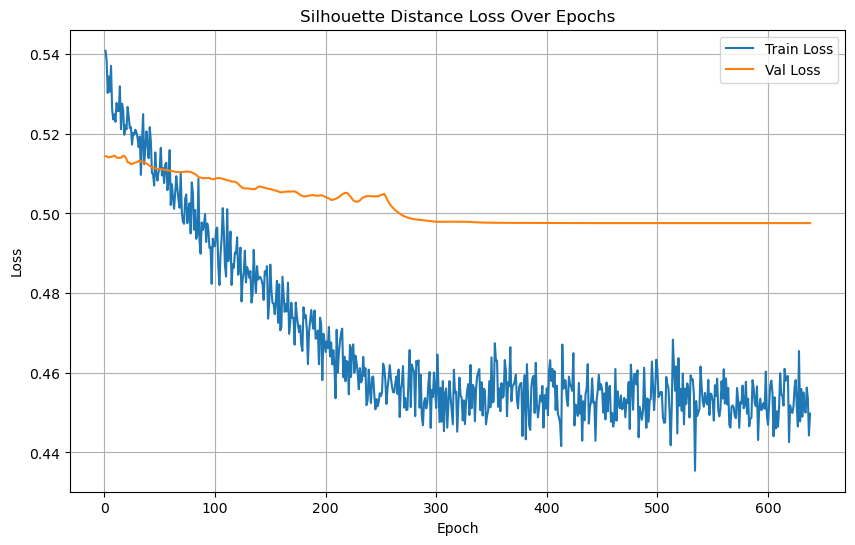

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/80], Loss: 0.2993
Test Batch [20/80], Loss: 0.5000
Test Batch [30/80], Loss: 0.3562


Test Batch [40/80], Loss: 0.2715
Test Batch [50/80], Loss: 0.3195
Test Batch [60/80], Loss: 0.3317


Test Batch [70/80], Loss: 0.4796
Test Batch [80/80], Loss: 0.5000

Test Loss: 0.3212


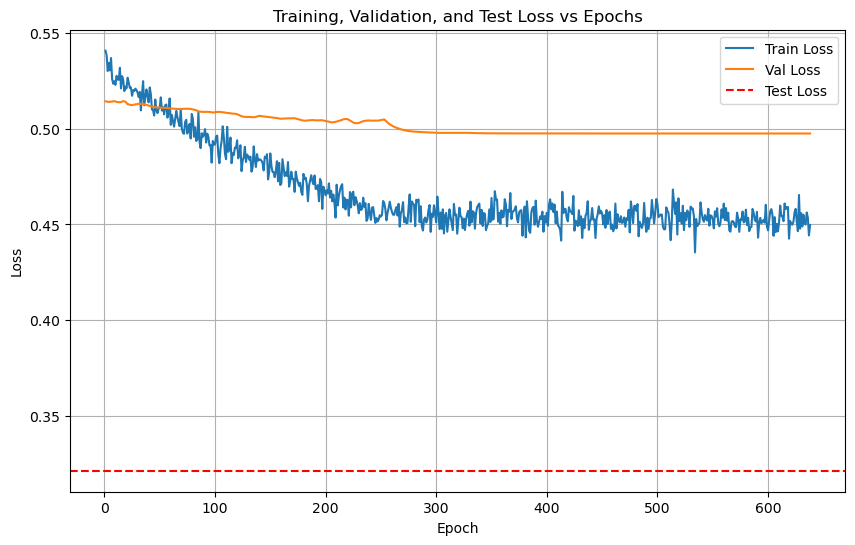

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/80 for test dataset.
  Processed batch 20/80 for test dataset.
  Processed batch 30/80 for test dataset.


  Processed batch 40/80 for test dataset.
  Processed batch 50/80 for test dataset.
  Processed batch 60/80 for test dataset.


  Processed batch 70/80 for test dataset.
  Processed batch 80/80 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (65, 128)
Train labels shape: (65,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5081, 128)
Test labels shape: (5081,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 38.46%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.60      0.50         5
           1       0.00      0.00      0.00         5
           2       0.25      0.40      0.31         5
           3       0.00      0.00      0.00         5
           4       0.40      0.40      0.40         5
           5       0.00      0.00      0.00         5
           6       0.67      0.80      0.73         5
           7       0.18      0.40      0.25         5
           8       0.50      0.80      0.62         5
           9       0.00      0.00      0.00         5
          10       1.00      1.00      1.00         5
          11       0.00      0.00      0.00         5
          12       0.75      0.60      0.67         5

    accuracy         

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (65, 128)
Train labels shape: (65,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5081, 128)
Test labels shape: (5081,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6214  |  Val Loss: 2.5611
Validation loss improved from inf to 2.5611.
[Epoch 2/1000] Train Loss: 2.6133  |  Val Loss: 2.5609
Validation loss improved from 2.5611 to 2.5609.
[Epoch 3/1000] Train Loss: 2.6062  |  Val Loss: 2.5607
Validation loss improved from 2.5609 to 2.5607.
[Epoch 4/1000] Train Loss: 2.6004  |  Val Loss: 2.5606
Validation loss improved from 2.5607 to 2.5606.
[Epoch 5/1000] Train Loss: 2.5953  |  Val Loss: 2.5605
Validation loss improved from 2.5606 to 2.5605.
[Epoch 6/1000] Train Loss: 2.5902  |  Val Loss: 2.5604
Validation loss improved from 2.5605 to 2.5604.
[Epoch 7/1000] Train Loss: 2.5856  |  Val Loss: 2.5602
Validation loss improved from 2.5604 to 2.5602.
[Epoch 8/1000] Train Loss: 2.5814  |  Val Loss: 2.5600
Validation loss improved from 2.5602 to 2.5600.
[Epoch 9/1000] Train Loss: 2.5773  |  Val Loss: 2.5598
Validation loss improved from 2.5600 to 2.5598.
[Epoch 10/1000] Train Loss: 2.5735  |  Val Loss: 2.5597
Validation loss impr

[Epoch 22/1000] Train Loss: 2.5356  |  Val Loss: 2.5579
Validation loss improved from 2.5580 to 2.5579.
[Epoch 23/1000] Train Loss: 2.5329  |  Val Loss: 2.5578
Validation loss improved from 2.5579 to 2.5578.
[Epoch 24/1000] Train Loss: 2.5303  |  Val Loss: 2.5577
Validation loss improved from 2.5578 to 2.5577.
[Epoch 25/1000] Train Loss: 2.5277  |  Val Loss: 2.5577
Validation loss improved from 2.5577 to 2.5577.
[Epoch 26/1000] Train Loss: 2.5253  |  Val Loss: 2.5576
Validation loss improved from 2.5577 to 2.5576.
[Epoch 27/1000] Train Loss: 2.5230  |  Val Loss: 2.5575
Validation loss improved from 2.5576 to 2.5575.
[Epoch 28/1000] Train Loss: 2.5204  |  Val Loss: 2.5576
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 29/1000] Train Loss: 2.5179  |  Val Loss: 2.5577
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 30/1000] Train Loss: 2.5150  |  Val Loss: 2.5578
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 31/1000] Train Loss: 2.5123  |  Val Los

[Epoch 33/1000] Train Loss: 2.5077  |  Val Loss: 2.5579
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 34/1000] Train Loss: 2.5056  |  Val Loss: 2.5579
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 35/1000] Train Loss: 2.5036  |  Val Loss: 2.5578
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 36/1000] Train Loss: 2.5018  |  Val Loss: 2.5577
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 37/1000] Train Loss: 2.5000  |  Val Loss: 2.5577
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 38/1000] Train Loss: 2.4983  |  Val Loss: 2.5575
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 39/1000] Train Loss: 2.4967  |  Val Loss: 2.5574
Validation loss improved from 2.5575 to 2.5574.
[Epoch 40/1000] Train Loss: 2.4952  |  Val Loss: 2.5573
Validation loss improved from 2.5574 to 2.5573.
[Epoch 41/1000] Train Loss: 2.4936  |  Val Loss: 2.5572
Validation loss improved from 2.5573 to 2.5572.
[Epoch 42/1000] Train Loss: 2.4921  |  Val Loss: 2.5570
Validation loss improved from 2.5572 to 2.5570.
[Epoch 43/1000] Train Loss: 2.49

[Epoch 60/1000] Train Loss: 2.4612  |  Val Loss: 2.5525
Validation loss improved from 2.5527 to 2.5525.
[Epoch 61/1000] Train Loss: 2.4589  |  Val Loss: 2.5522
Validation loss improved from 2.5525 to 2.5522.
[Epoch 62/1000] Train Loss: 2.4561  |  Val Loss: 2.5518
Validation loss improved from 2.5522 to 2.5518.
[Epoch 63/1000] Train Loss: 2.4534  |  Val Loss: 2.5513
Validation loss improved from 2.5518 to 2.5513.
[Epoch 64/1000] Train Loss: 2.4506  |  Val Loss: 2.5509
Validation loss improved from 2.5513 to 2.5509.
[Epoch 65/1000] Train Loss: 2.4481  |  Val Loss: 2.5505
Validation loss improved from 2.5509 to 2.5505.
[Epoch 66/1000] Train Loss: 2.4458  |  Val Loss: 2.5502
Validation loss improved from 2.5505 to 2.5502.
[Epoch 67/1000] Train Loss: 2.4435  |  Val Loss: 2.5499
Validation loss improved from 2.5502 to 2.5499.
[Epoch 68/1000] Train Loss: 2.4410  |  Val Loss: 2.5497
Validation loss improved from 2.5499 to 2.5497.
[Epoch 69/1000] Train Loss: 2.4388  |  Val Loss: 2.5495
Validati

[Epoch 75/1000] Train Loss: 2.4256  |  Val Loss: 2.5483
Validation loss improved from 2.5484 to 2.5483.
[Epoch 76/1000] Train Loss: 2.4235  |  Val Loss: 2.5481
Validation loss improved from 2.5483 to 2.5481.
[Epoch 77/1000] Train Loss: 2.4216  |  Val Loss: 2.5479
Validation loss improved from 2.5481 to 2.5479.
[Epoch 78/1000] Train Loss: 2.4198  |  Val Loss: 2.5477
Validation loss improved from 2.5479 to 2.5477.
[Epoch 79/1000] Train Loss: 2.4181  |  Val Loss: 2.5475
Validation loss improved from 2.5477 to 2.5475.
[Epoch 80/1000] Train Loss: 2.4165  |  Val Loss: 2.5473
Validation loss improved from 2.5475 to 2.5473.
[Epoch 81/1000] Train Loss: 2.4151  |  Val Loss: 2.5471
Validation loss improved from 2.5473 to 2.5471.
[Epoch 82/1000] Train Loss: 2.4137  |  Val Loss: 2.5470
Validation loss improved from 2.5471 to 2.5470.
[Epoch 83/1000] Train Loss: 2.4124  |  Val Loss: 2.5468
Validation loss improved from 2.5470 to 2.5468.
[Epoch 84/1000] Train Loss: 2.4112  |  Val Loss: 2.5467
Validati

[Epoch 104/1000] Train Loss: 2.3822  |  Val Loss: 2.5418
Validation loss improved from 2.5422 to 2.5418.
[Epoch 105/1000] Train Loss: 2.3804  |  Val Loss: 2.5414
Validation loss improved from 2.5418 to 2.5414.
[Epoch 106/1000] Train Loss: 2.3784  |  Val Loss: 2.5411
Validation loss improved from 2.5414 to 2.5411.
[Epoch 107/1000] Train Loss: 2.3766  |  Val Loss: 2.5409
Validation loss improved from 2.5411 to 2.5409.
[Epoch 108/1000] Train Loss: 2.3750  |  Val Loss: 2.5407
Validation loss improved from 2.5409 to 2.5407.
[Epoch 109/1000] Train Loss: 2.3735  |  Val Loss: 2.5406
Validation loss improved from 2.5407 to 2.5406.
[Epoch 110/1000] Train Loss: 2.3717  |  Val Loss: 2.5406
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 111/1000] Train Loss: 2.3694  |  Val Loss: 2.5406
Validation loss improved from 2.5406 to 2.5406.
[Epoch 112/1000] Train Loss: 2.3674  |  Val Loss: 2.5405
Validation loss improved from 2.5406 to 2.5405.
[Epoch 113/1000] Train Loss: 2.3653  |  Val Loss:

[Epoch 119/1000] Train Loss: 2.3544  |  Val Loss: 2.5399
Validation loss improved from 2.5400 to 2.5399.
[Epoch 120/1000] Train Loss: 2.3529  |  Val Loss: 2.5398
Validation loss improved from 2.5399 to 2.5398.
[Epoch 121/1000] Train Loss: 2.3516  |  Val Loss: 2.5397
Validation loss improved from 2.5398 to 2.5397.
[Epoch 122/1000] Train Loss: 2.3503  |  Val Loss: 2.5395
Validation loss improved from 2.5397 to 2.5395.
[Epoch 123/1000] Train Loss: 2.3492  |  Val Loss: 2.5394
Validation loss improved from 2.5395 to 2.5394.
[Epoch 124/1000] Train Loss: 2.3481  |  Val Loss: 2.5393
Validation loss improved from 2.5394 to 2.5393.
[Epoch 125/1000] Train Loss: 2.3471  |  Val Loss: 2.5392
Validation loss improved from 2.5393 to 2.5392.
[Epoch 126/1000] Train Loss: 2.3461  |  Val Loss: 2.5390
Validation loss improved from 2.5392 to 2.5390.
[Epoch 127/1000] Train Loss: 2.3451  |  Val Loss: 2.5389
Validation loss improved from 2.5390 to 2.5389.
[Epoch 128/1000] Train Loss: 2.3440  |  Val Loss: 2.538

[Epoch 148/1000] Train Loss: 2.3191  |  Val Loss: 2.5333
Validation loss improved from 2.5337 to 2.5333.
[Epoch 149/1000] Train Loss: 2.3177  |  Val Loss: 2.5329
Validation loss improved from 2.5333 to 2.5329.
[Epoch 150/1000] Train Loss: 2.3163  |  Val Loss: 2.5324
Validation loss improved from 2.5329 to 2.5324.
[Epoch 151/1000] Train Loss: 2.3150  |  Val Loss: 2.5320
Validation loss improved from 2.5324 to 2.5320.
[Epoch 152/1000] Train Loss: 2.3137  |  Val Loss: 2.5316
Validation loss improved from 2.5320 to 2.5316.
[Epoch 153/1000] Train Loss: 2.3124  |  Val Loss: 2.5313
Validation loss improved from 2.5316 to 2.5313.
[Epoch 154/1000] Train Loss: 2.3113  |  Val Loss: 2.5310
Validation loss improved from 2.5313 to 2.5310.
[Epoch 155/1000] Train Loss: 2.3102  |  Val Loss: 2.5307
Validation loss improved from 2.5310 to 2.5307.
[Epoch 156/1000] Train Loss: 2.3092  |  Val Loss: 2.5305
Validation loss improved from 2.5307 to 2.5305.
[Epoch 157/1000] Train Loss: 2.3082  |  Val Loss: 2.530

[Epoch 161/1000] Train Loss: 2.3047  |  Val Loss: 2.5295
Validation loss improved from 2.5297 to 2.5295.
[Epoch 162/1000] Train Loss: 2.3038  |  Val Loss: 2.5293
Validation loss improved from 2.5295 to 2.5293.
[Epoch 163/1000] Train Loss: 2.3029  |  Val Loss: 2.5290
Validation loss improved from 2.5293 to 2.5290.
[Epoch 164/1000] Train Loss: 2.3019  |  Val Loss: 2.5286
Validation loss improved from 2.5290 to 2.5286.
[Epoch 165/1000] Train Loss: 2.3008  |  Val Loss: 2.5282
Validation loss improved from 2.5286 to 2.5282.
[Epoch 166/1000] Train Loss: 2.2998  |  Val Loss: 2.5279
Validation loss improved from 2.5282 to 2.5279.
[Epoch 167/1000] Train Loss: 2.2988  |  Val Loss: 2.5275
Validation loss improved from 2.5279 to 2.5275.
[Epoch 168/1000] Train Loss: 2.2979  |  Val Loss: 2.5273
Validation loss improved from 2.5275 to 2.5273.
[Epoch 169/1000] Train Loss: 2.2971  |  Val Loss: 2.5271
Validation loss improved from 2.5273 to 2.5271.
[Epoch 170/1000] Train Loss: 2.2960  |  Val Loss: 2.526

[Epoch 186/1000] Train Loss: 2.2784  |  Val Loss: 2.5233
Validation loss improved from 2.5235 to 2.5233.
[Epoch 187/1000] Train Loss: 2.2776  |  Val Loss: 2.5231
Validation loss improved from 2.5233 to 2.5231.
[Epoch 188/1000] Train Loss: 2.2768  |  Val Loss: 2.5229
Validation loss improved from 2.5231 to 2.5229.
[Epoch 189/1000] Train Loss: 2.2759  |  Val Loss: 2.5226
Validation loss improved from 2.5229 to 2.5226.
[Epoch 190/1000] Train Loss: 2.2750  |  Val Loss: 2.5222
Validation loss improved from 2.5226 to 2.5222.
[Epoch 191/1000] Train Loss: 2.2739  |  Val Loss: 2.5218
Validation loss improved from 2.5222 to 2.5218.
[Epoch 192/1000] Train Loss: 2.2729  |  Val Loss: 2.5214
Validation loss improved from 2.5218 to 2.5214.
[Epoch 193/1000] Train Loss: 2.2720  |  Val Loss: 2.5210
Validation loss improved from 2.5214 to 2.5210.


[Epoch 194/1000] Train Loss: 2.2711  |  Val Loss: 2.5207
Validation loss improved from 2.5210 to 2.5207.
[Epoch 195/1000] Train Loss: 2.2702  |  Val Loss: 2.5204
Validation loss improved from 2.5207 to 2.5204.
[Epoch 196/1000] Train Loss: 2.2694  |  Val Loss: 2.5201
Validation loss improved from 2.5204 to 2.5201.
[Epoch 197/1000] Train Loss: 2.2686  |  Val Loss: 2.5198
Validation loss improved from 2.5201 to 2.5198.
[Epoch 198/1000] Train Loss: 2.2678  |  Val Loss: 2.5195
Validation loss improved from 2.5198 to 2.5195.
[Epoch 199/1000] Train Loss: 2.2671  |  Val Loss: 2.5192
Validation loss improved from 2.5195 to 2.5192.
[Epoch 200/1000] Train Loss: 2.2662  |  Val Loss: 2.5188
Validation loss improved from 2.5192 to 2.5188.
[Epoch 201/1000] Train Loss: 2.2652  |  Val Loss: 2.5184
Validation loss improved from 2.5188 to 2.5184.
[Epoch 202/1000] Train Loss: 2.2640  |  Val Loss: 2.5182
Validation loss improved from 2.5184 to 2.5182.
[Epoch 203/1000] Train Loss: 2.2628  |  Val Loss: 2.518

[Epoch 226/1000] Train Loss: 2.2420  |  Val Loss: 2.5138
Validation loss improved from 2.5140 to 2.5138.
[Epoch 227/1000] Train Loss: 2.2412  |  Val Loss: 2.5136
Validation loss improved from 2.5138 to 2.5136.
[Epoch 228/1000] Train Loss: 2.2403  |  Val Loss: 2.5134
Validation loss improved from 2.5136 to 2.5134.
[Epoch 229/1000] Train Loss: 2.2395  |  Val Loss: 2.5132
Validation loss improved from 2.5134 to 2.5132.
[Epoch 230/1000] Train Loss: 2.2387  |  Val Loss: 2.5130
Validation loss improved from 2.5132 to 2.5130.
[Epoch 231/1000] Train Loss: 2.2380  |  Val Loss: 2.5127
Validation loss improved from 2.5130 to 2.5127.
[Epoch 232/1000] Train Loss: 2.2373  |  Val Loss: 2.5125
Validation loss improved from 2.5127 to 2.5125.
[Epoch 233/1000] Train Loss: 2.2366  |  Val Loss: 2.5122
Validation loss improved from 2.5125 to 2.5122.
[Epoch 234/1000] Train Loss: 2.2360  |  Val Loss: 2.5119
Validation loss improved from 2.5122 to 2.5119.
[Epoch 235/1000] Train Loss: 2.2353  |  Val Loss: 2.511

[Epoch 240/1000] Train Loss: 2.2294  |  Val Loss: 2.5078
Validation loss improved from 2.5087 to 2.5078.
[Epoch 241/1000] Train Loss: 2.2280  |  Val Loss: 2.5070
Validation loss improved from 2.5078 to 2.5070.
[Epoch 242/1000] Train Loss: 2.2266  |  Val Loss: 2.5062
Validation loss improved from 2.5070 to 2.5062.
[Epoch 243/1000] Train Loss: 2.2252  |  Val Loss: 2.5054
Validation loss improved from 2.5062 to 2.5054.
[Epoch 244/1000] Train Loss: 2.2236  |  Val Loss: 2.5047
Validation loss improved from 2.5054 to 2.5047.
[Epoch 245/1000] Train Loss: 2.2221  |  Val Loss: 2.5041
Validation loss improved from 2.5047 to 2.5041.
[Epoch 246/1000] Train Loss: 2.2207  |  Val Loss: 2.5034
Validation loss improved from 2.5041 to 2.5034.
[Epoch 247/1000] Train Loss: 2.2193  |  Val Loss: 2.5026
Validation loss improved from 2.5034 to 2.5026.
[Epoch 248/1000] Train Loss: 2.2177  |  Val Loss: 2.5019
Validation loss improved from 2.5026 to 2.5019.
[Epoch 249/1000] Train Loss: 2.2163  |  Val Loss: 2.501

[Epoch 270/1000] Train Loss: 2.1972  |  Val Loss: 2.4927
Validation loss improved from 2.4932 to 2.4927.
[Epoch 271/1000] Train Loss: 2.1961  |  Val Loss: 2.4922
Validation loss improved from 2.4927 to 2.4922.
[Epoch 272/1000] Train Loss: 2.1951  |  Val Loss: 2.4919
Validation loss improved from 2.4922 to 2.4919.
[Epoch 273/1000] Train Loss: 2.1941  |  Val Loss: 2.4916
Validation loss improved from 2.4919 to 2.4916.
[Epoch 274/1000] Train Loss: 2.1932  |  Val Loss: 2.4913
Validation loss improved from 2.4916 to 2.4913.
[Epoch 275/1000] Train Loss: 2.1922  |  Val Loss: 2.4911
Validation loss improved from 2.4913 to 2.4911.
[Epoch 276/1000] Train Loss: 2.1913  |  Val Loss: 2.4908
Validation loss improved from 2.4911 to 2.4908.
[Epoch 277/1000] Train Loss: 2.1905  |  Val Loss: 2.4906
Validation loss improved from 2.4908 to 2.4906.
[Epoch 278/1000] Train Loss: 2.1897  |  Val Loss: 2.4904
Validation loss improved from 2.4906 to 2.4904.
[Epoch 279/1000] Train Loss: 2.1890  |  Val Loss: 2.490

[Epoch 285/1000] Train Loss: 2.1835  |  Val Loss: 2.4878
Validation loss improved from 2.4880 to 2.4878.
[Epoch 286/1000] Train Loss: 2.1828  |  Val Loss: 2.4875
Validation loss improved from 2.4878 to 2.4875.
[Epoch 287/1000] Train Loss: 2.1820  |  Val Loss: 2.4874
Validation loss improved from 2.4875 to 2.4874.
[Epoch 288/1000] Train Loss: 2.1811  |  Val Loss: 2.4874
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 289/1000] Train Loss: 2.1801  |  Val Loss: 2.4874
Validation loss improved from 2.4874 to 2.4874.
[Epoch 290/1000] Train Loss: 2.1791  |  Val Loss: 2.4873
Validation loss improved from 2.4874 to 2.4873.
[Epoch 291/1000] Train Loss: 2.1783  |  Val Loss: 2.4871
Validation loss improved from 2.4873 to 2.4871.
[Epoch 292/1000] Train Loss: 2.1774  |  Val Loss: 2.4870
Validation loss improved from 2.4871 to 2.4870.
[Epoch 293/1000] Train Loss: 2.1766  |  Val Loss: 2.4869
Validation loss improved from 2.4870 to 2.4869.
[Epoch 294/1000] Train Loss: 2.1759  |  Val Loss:

[Epoch 313/1000] Train Loss: 2.1618  |  Val Loss: 2.4826
Validation loss improved from 2.4828 to 2.4826.
[Epoch 314/1000] Train Loss: 2.1611  |  Val Loss: 2.4823
Validation loss improved from 2.4826 to 2.4823.
[Epoch 315/1000] Train Loss: 2.1604  |  Val Loss: 2.4821
Validation loss improved from 2.4823 to 2.4821.
[Epoch 316/1000] Train Loss: 2.1597  |  Val Loss: 2.4818
Validation loss improved from 2.4821 to 2.4818.
[Epoch 317/1000] Train Loss: 2.1590  |  Val Loss: 2.4815
Validation loss improved from 2.4818 to 2.4815.
[Epoch 318/1000] Train Loss: 2.1582  |  Val Loss: 2.4812
Validation loss improved from 2.4815 to 2.4812.
[Epoch 319/1000] Train Loss: 2.1575  |  Val Loss: 2.4809
Validation loss improved from 2.4812 to 2.4809.
[Epoch 320/1000] Train Loss: 2.1567  |  Val Loss: 2.4805
Validation loss improved from 2.4809 to 2.4805.
[Epoch 321/1000] Train Loss: 2.1559  |  Val Loss: 2.4800
Validation loss improved from 2.4805 to 2.4800.
[Epoch 322/1000] Train Loss: 2.1550  |  Val Loss: 2.479

[Epoch 328/1000] Train Loss: 2.1483  |  Val Loss: 2.4755
Validation loss improved from 2.4761 to 2.4755.
[Epoch 329/1000] Train Loss: 2.1473  |  Val Loss: 2.4751
Validation loss improved from 2.4755 to 2.4751.
[Epoch 330/1000] Train Loss: 2.1463  |  Val Loss: 2.4746
Validation loss improved from 2.4751 to 2.4746.
[Epoch 331/1000] Train Loss: 2.1454  |  Val Loss: 2.4743
Validation loss improved from 2.4746 to 2.4743.
[Epoch 332/1000] Train Loss: 2.1445  |  Val Loss: 2.4739
Validation loss improved from 2.4743 to 2.4739.
[Epoch 333/1000] Train Loss: 2.1437  |  Val Loss: 2.4736
Validation loss improved from 2.4739 to 2.4736.
[Epoch 334/1000] Train Loss: 2.1429  |  Val Loss: 2.4733
Validation loss improved from 2.4736 to 2.4733.
[Epoch 335/1000] Train Loss: 2.1421  |  Val Loss: 2.4731
Validation loss improved from 2.4733 to 2.4731.
[Epoch 336/1000] Train Loss: 2.1414  |  Val Loss: 2.4728
Validation loss improved from 2.4731 to 2.4728.
[Epoch 337/1000] Train Loss: 2.1406  |  Val Loss: 2.472

[Epoch 353/1000] Train Loss: 2.1258  |  Val Loss: 2.4661
Validation loss improved from 2.4667 to 2.4661.
[Epoch 354/1000] Train Loss: 2.1248  |  Val Loss: 2.4655
Validation loss improved from 2.4661 to 2.4655.
[Epoch 355/1000] Train Loss: 2.1238  |  Val Loss: 2.4650
Validation loss improved from 2.4655 to 2.4650.
[Epoch 356/1000] Train Loss: 2.1228  |  Val Loss: 2.4646
Validation loss improved from 2.4650 to 2.4646.
[Epoch 357/1000] Train Loss: 2.1219  |  Val Loss: 2.4640
Validation loss improved from 2.4646 to 2.4640.
[Epoch 358/1000] Train Loss: 2.1209  |  Val Loss: 2.4633
Validation loss improved from 2.4640 to 2.4633.
[Epoch 359/1000] Train Loss: 2.1197  |  Val Loss: 2.4627
Validation loss improved from 2.4633 to 2.4627.
[Epoch 360/1000] Train Loss: 2.1186  |  Val Loss: 2.4621
Validation loss improved from 2.4627 to 2.4621.
[Epoch 361/1000] Train Loss: 2.1176  |  Val Loss: 2.4616
Validation loss improved from 2.4621 to 2.4616.
[Epoch 362/1000] Train Loss: 2.1167  |  Val Loss: 2.461

[Epoch 367/1000] Train Loss: 2.1128  |  Val Loss: 2.4596
Validation loss improved from 2.4599 to 2.4596.
[Epoch 368/1000] Train Loss: 2.1122  |  Val Loss: 2.4593
Validation loss improved from 2.4596 to 2.4593.
[Epoch 369/1000] Train Loss: 2.1115  |  Val Loss: 2.4590
Validation loss improved from 2.4593 to 2.4590.
[Epoch 370/1000] Train Loss: 2.1108  |  Val Loss: 2.4587
Validation loss improved from 2.4590 to 2.4587.
[Epoch 371/1000] Train Loss: 2.1100  |  Val Loss: 2.4586
Validation loss improved from 2.4587 to 2.4586.
[Epoch 372/1000] Train Loss: 2.1092  |  Val Loss: 2.4587
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 373/1000] Train Loss: 2.1083  |  Val Loss: 2.4586
Validation loss improved from 2.4586 to 2.4586.
[Epoch 374/1000] Train Loss: 2.1074  |  Val Loss: 2.4585
Validation loss improved from 2.4586 to 2.4585.
[Epoch 375/1000] Train Loss: 2.1065  |  Val Loss: 2.4583
Validation loss improved from 2.4585 to 2.4583.
[Epoch 376/1000] Train Loss: 2.1055  |  Val Loss:

[Epoch 388/1000] Train Loss: 2.0959  |  Val Loss: 2.4575
Validation loss improved from 2.4576 to 2.4575.
[Epoch 389/1000] Train Loss: 2.0952  |  Val Loss: 2.4573
Validation loss improved from 2.4575 to 2.4573.
[Epoch 390/1000] Train Loss: 2.0945  |  Val Loss: 2.4571
Validation loss improved from 2.4573 to 2.4571.
[Epoch 391/1000] Train Loss: 2.0939  |  Val Loss: 2.4569
Validation loss improved from 2.4571 to 2.4569.
[Epoch 392/1000] Train Loss: 2.0932  |  Val Loss: 2.4566
Validation loss improved from 2.4569 to 2.4566.
[Epoch 393/1000] Train Loss: 2.0926  |  Val Loss: 2.4564
Validation loss improved from 2.4566 to 2.4564.
[Epoch 394/1000] Train Loss: 2.0920  |  Val Loss: 2.4562
Validation loss improved from 2.4564 to 2.4562.
[Epoch 395/1000] Train Loss: 2.0914  |  Val Loss: 2.4560
Validation loss improved from 2.4562 to 2.4560.
[Epoch 396/1000] Train Loss: 2.0908  |  Val Loss: 2.4557
Validation loss improved from 2.4560 to 2.4557.
[Epoch 397/1000] Train Loss: 2.0902  |  Val Loss: 2.455

[Epoch 406/1000] Train Loss: 2.0841  |  Val Loss: 2.4530
Validation loss improved from 2.4533 to 2.4530.
[Epoch 407/1000] Train Loss: 2.0834  |  Val Loss: 2.4527
Validation loss improved from 2.4530 to 2.4527.
[Epoch 408/1000] Train Loss: 2.0827  |  Val Loss: 2.4525
Validation loss improved from 2.4527 to 2.4525.
[Epoch 409/1000] Train Loss: 2.0818  |  Val Loss: 2.4525
Validation loss improved from 2.4525 to 2.4525.
[Epoch 410/1000] Train Loss: 2.0809  |  Val Loss: 2.4524
Validation loss improved from 2.4525 to 2.4524.
[Epoch 411/1000] Train Loss: 2.0800  |  Val Loss: 2.4523
Validation loss improved from 2.4524 to 2.4523.
[Epoch 412/1000] Train Loss: 2.0792  |  Val Loss: 2.4522
Validation loss improved from 2.4523 to 2.4522.
[Epoch 413/1000] Train Loss: 2.0783  |  Val Loss: 2.4521
Validation loss improved from 2.4522 to 2.4521.
[Epoch 414/1000] Train Loss: 2.0775  |  Val Loss: 2.4519
Validation loss improved from 2.4521 to 2.4519.
[Epoch 415/1000] Train Loss: 2.0768  |  Val Loss: 2.451

[Epoch 430/1000] Train Loss: 2.0641  |  Val Loss: 2.4487
Validation loss improved from 2.4492 to 2.4487.
[Epoch 431/1000] Train Loss: 2.0630  |  Val Loss: 2.4484
Validation loss improved from 2.4487 to 2.4484.
[Epoch 432/1000] Train Loss: 2.0620  |  Val Loss: 2.4480
Validation loss improved from 2.4484 to 2.4480.
[Epoch 433/1000] Train Loss: 2.0611  |  Val Loss: 2.4476
Validation loss improved from 2.4480 to 2.4476.
[Epoch 434/1000] Train Loss: 2.0603  |  Val Loss: 2.4473
Validation loss improved from 2.4476 to 2.4473.
[Epoch 435/1000] Train Loss: 2.0594  |  Val Loss: 2.4469
Validation loss improved from 2.4473 to 2.4469.
[Epoch 436/1000] Train Loss: 2.0586  |  Val Loss: 2.4467
Validation loss improved from 2.4469 to 2.4467.
[Epoch 437/1000] Train Loss: 2.0578  |  Val Loss: 2.4468
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 438/1000] Train Loss: 2.0568  |  Val Loss: 2.4467
Validation loss improved from 2.4467 to 2.4467.
[Epoch 439/1000] Train Loss: 2.0560  |  Val Loss:

[Epoch 442/1000] Train Loss: 2.0532  |  Val Loss: 2.4454
Validation loss improved from 2.4461 to 2.4454.
[Epoch 443/1000] Train Loss: 2.0520  |  Val Loss: 2.4450
Validation loss improved from 2.4454 to 2.4450.
[Epoch 444/1000] Train Loss: 2.0509  |  Val Loss: 2.4449
Validation loss improved from 2.4450 to 2.4449.
[Epoch 445/1000] Train Loss: 2.0497  |  Val Loss: 2.4446
Validation loss improved from 2.4449 to 2.4446.
[Epoch 446/1000] Train Loss: 2.0486  |  Val Loss: 2.4444
Validation loss improved from 2.4446 to 2.4444.
[Epoch 447/1000] Train Loss: 2.0476  |  Val Loss: 2.4441
Validation loss improved from 2.4444 to 2.4441.
[Epoch 448/1000] Train Loss: 2.0466  |  Val Loss: 2.4438
Validation loss improved from 2.4441 to 2.4438.
[Epoch 449/1000] Train Loss: 2.0456  |  Val Loss: 2.4435
Validation loss improved from 2.4438 to 2.4435.
[Epoch 450/1000] Train Loss: 2.0447  |  Val Loss: 2.4433
Validation loss improved from 2.4435 to 2.4433.
[Epoch 451/1000] Train Loss: 2.0439  |  Val Loss: 2.443

[Epoch 471/1000] Train Loss: 2.0237  |  Val Loss: 2.4308
Validation loss improved from 2.4318 to 2.4308.
[Epoch 472/1000] Train Loss: 2.0223  |  Val Loss: 2.4299
Validation loss improved from 2.4308 to 2.4299.
[Epoch 473/1000] Train Loss: 2.0211  |  Val Loss: 2.4290
Validation loss improved from 2.4299 to 2.4290.
[Epoch 474/1000] Train Loss: 2.0200  |  Val Loss: 2.4283
Validation loss improved from 2.4290 to 2.4283.
[Epoch 475/1000] Train Loss: 2.0188  |  Val Loss: 2.4277
Validation loss improved from 2.4283 to 2.4277.
[Epoch 476/1000] Train Loss: 2.0177  |  Val Loss: 2.4270
Validation loss improved from 2.4277 to 2.4270.
[Epoch 477/1000] Train Loss: 2.0166  |  Val Loss: 2.4260
Validation loss improved from 2.4270 to 2.4260.
[Epoch 478/1000] Train Loss: 2.0153  |  Val Loss: 2.4253
Validation loss improved from 2.4260 to 2.4253.
[Epoch 479/1000] Train Loss: 2.0140  |  Val Loss: 2.4246
Validation loss improved from 2.4253 to 2.4246.
[Epoch 480/1000] Train Loss: 2.0129  |  Val Loss: 2.424

[Epoch 484/1000] Train Loss: 2.0090  |  Val Loss: 2.4222
Validation loss improved from 2.4226 to 2.4222.
[Epoch 485/1000] Train Loss: 2.0081  |  Val Loss: 2.4218
Validation loss improved from 2.4222 to 2.4218.
[Epoch 486/1000] Train Loss: 2.0073  |  Val Loss: 2.4214
Validation loss improved from 2.4218 to 2.4214.
[Epoch 487/1000] Train Loss: 2.0065  |  Val Loss: 2.4211
Validation loss improved from 2.4214 to 2.4211.
[Epoch 488/1000] Train Loss: 2.0058  |  Val Loss: 2.4208
Validation loss improved from 2.4211 to 2.4208.
[Epoch 489/1000] Train Loss: 2.0050  |  Val Loss: 2.4205
Validation loss improved from 2.4208 to 2.4205.
[Epoch 490/1000] Train Loss: 2.0043  |  Val Loss: 2.4203
Validation loss improved from 2.4205 to 2.4203.
[Epoch 491/1000] Train Loss: 2.0035  |  Val Loss: 2.4200
Validation loss improved from 2.4203 to 2.4200.
[Epoch 492/1000] Train Loss: 2.0028  |  Val Loss: 2.4198
Validation loss improved from 2.4200 to 2.4198.
[Epoch 493/1000] Train Loss: 2.0022  |  Val Loss: 2.419

[Epoch 512/1000] Train Loss: 1.9878  |  Val Loss: 2.4144
Validation loss improved from 2.4146 to 2.4144.
[Epoch 513/1000] Train Loss: 1.9870  |  Val Loss: 2.4141
Validation loss improved from 2.4144 to 2.4141.
[Epoch 514/1000] Train Loss: 1.9861  |  Val Loss: 2.4138
Validation loss improved from 2.4141 to 2.4138.
[Epoch 515/1000] Train Loss: 1.9853  |  Val Loss: 2.4134
Validation loss improved from 2.4138 to 2.4134.
[Epoch 516/1000] Train Loss: 1.9845  |  Val Loss: 2.4130
Validation loss improved from 2.4134 to 2.4130.
[Epoch 517/1000] Train Loss: 1.9838  |  Val Loss: 2.4127
Validation loss improved from 2.4130 to 2.4127.
[Epoch 518/1000] Train Loss: 1.9830  |  Val Loss: 2.4125
Validation loss improved from 2.4127 to 2.4125.
[Epoch 519/1000] Train Loss: 1.9822  |  Val Loss: 2.4120
Validation loss improved from 2.4125 to 2.4120.
[Epoch 520/1000] Train Loss: 1.9813  |  Val Loss: 2.4114
Validation loss improved from 2.4120 to 2.4114.
[Epoch 521/1000] Train Loss: 1.9802  |  Val Loss: 2.410

[Epoch 523/1000] Train Loss: 1.9784  |  Val Loss: 2.4103
Validation loss improved from 2.4105 to 2.4103.
[Epoch 524/1000] Train Loss: 1.9776  |  Val Loss: 2.4100
Validation loss improved from 2.4103 to 2.4100.
[Epoch 525/1000] Train Loss: 1.9768  |  Val Loss: 2.4097
Validation loss improved from 2.4100 to 2.4097.
[Epoch 526/1000] Train Loss: 1.9761  |  Val Loss: 2.4094
Validation loss improved from 2.4097 to 2.4094.
[Epoch 527/1000] Train Loss: 1.9753  |  Val Loss: 2.4091
Validation loss improved from 2.4094 to 2.4091.
[Epoch 528/1000] Train Loss: 1.9745  |  Val Loss: 2.4086
Validation loss improved from 2.4091 to 2.4086.
[Epoch 529/1000] Train Loss: 1.9737  |  Val Loss: 2.4080
Validation loss improved from 2.4086 to 2.4080.
[Epoch 530/1000] Train Loss: 1.9728  |  Val Loss: 2.4075
Validation loss improved from 2.4080 to 2.4075.
[Epoch 531/1000] Train Loss: 1.9720  |  Val Loss: 2.4070
Validation loss improved from 2.4075 to 2.4070.
[Epoch 532/1000] Train Loss: 1.9711  |  Val Loss: 2.406

[Epoch 553/1000] Train Loss: 1.9530  |  Val Loss: 2.4011
Validation loss improved from 2.4012 to 2.4011.
[Epoch 554/1000] Train Loss: 1.9520  |  Val Loss: 2.4009
Validation loss improved from 2.4011 to 2.4009.
[Epoch 555/1000] Train Loss: 1.9510  |  Val Loss: 2.4007
Validation loss improved from 2.4009 to 2.4007.
[Epoch 556/1000] Train Loss: 1.9500  |  Val Loss: 2.4005
Validation loss improved from 2.4007 to 2.4005.
[Epoch 557/1000] Train Loss: 1.9491  |  Val Loss: 2.4003
Validation loss improved from 2.4005 to 2.4003.
[Epoch 558/1000] Train Loss: 1.9482  |  Val Loss: 2.4001
Validation loss improved from 2.4003 to 2.4001.
[Epoch 559/1000] Train Loss: 1.9474  |  Val Loss: 2.3998
Validation loss improved from 2.4001 to 2.3998.


[Epoch 560/1000] Train Loss: 1.9465  |  Val Loss: 2.3996
Validation loss improved from 2.3998 to 2.3996.
[Epoch 561/1000] Train Loss: 1.9458  |  Val Loss: 2.3993
Validation loss improved from 2.3996 to 2.3993.
[Epoch 562/1000] Train Loss: 1.9450  |  Val Loss: 2.3989
Validation loss improved from 2.3993 to 2.3989.
[Epoch 563/1000] Train Loss: 1.9443  |  Val Loss: 2.3986
Validation loss improved from 2.3989 to 2.3986.
[Epoch 564/1000] Train Loss: 1.9435  |  Val Loss: 2.3982
Validation loss improved from 2.3986 to 2.3982.
[Epoch 565/1000] Train Loss: 1.9428  |  Val Loss: 2.3978
Validation loss improved from 2.3982 to 2.3978.
[Epoch 566/1000] Train Loss: 1.9421  |  Val Loss: 2.3974
Validation loss improved from 2.3978 to 2.3974.
[Epoch 567/1000] Train Loss: 1.9413  |  Val Loss: 2.3971
Validation loss improved from 2.3974 to 2.3971.
[Epoch 568/1000] Train Loss: 1.9406  |  Val Loss: 2.3968
Validation loss improved from 2.3971 to 2.3968.
[Epoch 569/1000] Train Loss: 1.9399  |  Val Loss: 2.396

[Epoch 590/1000] Train Loss: 1.9202  |  Val Loss: 2.3890
Validation loss improved from 2.3892 to 2.3890.
[Epoch 591/1000] Train Loss: 1.9192  |  Val Loss: 2.3889
Validation loss improved from 2.3890 to 2.3889.
[Epoch 592/1000] Train Loss: 1.9183  |  Val Loss: 2.3887
Validation loss improved from 2.3889 to 2.3887.
[Epoch 593/1000] Train Loss: 1.9174  |  Val Loss: 2.3886
Validation loss improved from 2.3887 to 2.3886.
[Epoch 594/1000] Train Loss: 1.9164  |  Val Loss: 2.3884
Validation loss improved from 2.3886 to 2.3884.
[Epoch 595/1000] Train Loss: 1.9155  |  Val Loss: 2.3882
Validation loss improved from 2.3884 to 2.3882.
[Epoch 596/1000] Train Loss: 1.9147  |  Val Loss: 2.3881
Validation loss improved from 2.3882 to 2.3881.
[Epoch 597/1000] Train Loss: 1.9139  |  Val Loss: 2.3879
Validation loss improved from 2.3881 to 2.3879.
[Epoch 598/1000] Train Loss: 1.9131  |  Val Loss: 2.3877
Validation loss improved from 2.3879 to 2.3877.


[Epoch 599/1000] Train Loss: 1.9120  |  Val Loss: 2.3874
Validation loss improved from 2.3877 to 2.3874.
[Epoch 600/1000] Train Loss: 1.9109  |  Val Loss: 2.3869
Validation loss improved from 2.3874 to 2.3869.
[Epoch 601/1000] Train Loss: 1.9097  |  Val Loss: 2.3865
Validation loss improved from 2.3869 to 2.3865.
[Epoch 602/1000] Train Loss: 1.9086  |  Val Loss: 2.3860
Validation loss improved from 2.3865 to 2.3860.
[Epoch 603/1000] Train Loss: 1.9074  |  Val Loss: 2.3856
Validation loss improved from 2.3860 to 2.3856.
[Epoch 604/1000] Train Loss: 1.9063  |  Val Loss: 2.3851
Validation loss improved from 2.3856 to 2.3851.
[Epoch 605/1000] Train Loss: 1.9051  |  Val Loss: 2.3847
Validation loss improved from 2.3851 to 2.3847.
[Epoch 606/1000] Train Loss: 1.9040  |  Val Loss: 2.3843
Validation loss improved from 2.3847 to 2.3843.
[Epoch 607/1000] Train Loss: 1.9028  |  Val Loss: 2.3839
Validation loss improved from 2.3843 to 2.3839.
[Epoch 608/1000] Train Loss: 1.9016  |  Val Loss: 2.383

[Epoch 631/1000] Train Loss: 1.8739  |  Val Loss: 2.3742
Validation loss improved from 2.3743 to 2.3742.
[Epoch 632/1000] Train Loss: 1.8727  |  Val Loss: 2.3741
Validation loss improved from 2.3742 to 2.3741.
[Epoch 633/1000] Train Loss: 1.8715  |  Val Loss: 2.3741
Validation loss improved from 2.3741 to 2.3741.
[Epoch 634/1000] Train Loss: 1.8703  |  Val Loss: 2.3742
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 635/1000] Train Loss: 1.8693  |  Val Loss: 2.3744
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 636/1000] Train Loss: 1.8683  |  Val Loss: 2.3746
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 637/1000] Train Loss: 1.8673  |  Val Loss: 2.3746
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 638/1000] Train Loss: 1.8664  |  Val Loss: 2.3746
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 639/1000] Train Loss: 1.8655  |  Val Loss: 2.3745
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 640/1000] Tr

[Epoch 644/1000] Train Loss: 1.8604  |  Val Loss: 2.3730
Validation loss improved from 2.3734 to 2.3730.
[Epoch 645/1000] Train Loss: 1.8592  |  Val Loss: 2.3727
Validation loss improved from 2.3730 to 2.3727.
[Epoch 646/1000] Train Loss: 1.8582  |  Val Loss: 2.3725
Validation loss improved from 2.3727 to 2.3725.
[Epoch 647/1000] Train Loss: 1.8571  |  Val Loss: 2.3723
Validation loss improved from 2.3725 to 2.3723.
[Epoch 648/1000] Train Loss: 1.8561  |  Val Loss: 2.3721
Validation loss improved from 2.3723 to 2.3721.
[Epoch 649/1000] Train Loss: 1.8551  |  Val Loss: 2.3719
Validation loss improved from 2.3721 to 2.3719.
[Epoch 650/1000] Train Loss: 1.8543  |  Val Loss: 2.3717
Validation loss improved from 2.3719 to 2.3717.
[Epoch 651/1000] Train Loss: 1.8534  |  Val Loss: 2.3714
Validation loss improved from 2.3717 to 2.3714.
[Epoch 652/1000] Train Loss: 1.8525  |  Val Loss: 2.3710
Validation loss improved from 2.3714 to 2.3710.
[Epoch 653/1000] Train Loss: 1.8516  |  Val Loss: 2.370

[Epoch 676/1000] Train Loss: 1.8277  |  Val Loss: 2.3615
Validation loss improved from 2.3616 to 2.3615.
[Epoch 677/1000] Train Loss: 1.8263  |  Val Loss: 2.3614
Validation loss improved from 2.3615 to 2.3614.
[Epoch 678/1000] Train Loss: 1.8251  |  Val Loss: 2.3613
Validation loss improved from 2.3614 to 2.3613.
[Epoch 679/1000] Train Loss: 1.8239  |  Val Loss: 2.3610
Validation loss improved from 2.3613 to 2.3610.
[Epoch 680/1000] Train Loss: 1.8227  |  Val Loss: 2.3606
Validation loss improved from 2.3610 to 2.3606.
[Epoch 681/1000] Train Loss: 1.8214  |  Val Loss: 2.3602
Validation loss improved from 2.3606 to 2.3602.
[Epoch 682/1000] Train Loss: 1.8202  |  Val Loss: 2.3599
Validation loss improved from 2.3602 to 2.3599.
[Epoch 683/1000] Train Loss: 1.8190  |  Val Loss: 2.3596
Validation loss improved from 2.3599 to 2.3596.
[Epoch 684/1000] Train Loss: 1.8179  |  Val Loss: 2.3593
Validation loss improved from 2.3596 to 2.3593.
[Epoch 685/1000] Train Loss: 1.8169  |  Val Loss: 2.359

[Epoch 687/1000] Train Loss: 1.8145  |  Val Loss: 2.3580
Validation loss improved from 2.3586 to 2.3580.
[Epoch 688/1000] Train Loss: 1.8134  |  Val Loss: 2.3572
Validation loss improved from 2.3580 to 2.3572.
[Epoch 689/1000] Train Loss: 1.8122  |  Val Loss: 2.3564
Validation loss improved from 2.3572 to 2.3564.
[Epoch 690/1000] Train Loss: 1.8111  |  Val Loss: 2.3557
Validation loss improved from 2.3564 to 2.3557.
[Epoch 691/1000] Train Loss: 1.8101  |  Val Loss: 2.3551
Validation loss improved from 2.3557 to 2.3551.
[Epoch 692/1000] Train Loss: 1.8090  |  Val Loss: 2.3546
Validation loss improved from 2.3551 to 2.3546.
[Epoch 693/1000] Train Loss: 1.8078  |  Val Loss: 2.3540
Validation loss improved from 2.3546 to 2.3540.
[Epoch 694/1000] Train Loss: 1.8065  |  Val Loss: 2.3536
Validation loss improved from 2.3540 to 2.3536.
[Epoch 695/1000] Train Loss: 1.8052  |  Val Loss: 2.3532
Validation loss improved from 2.3536 to 2.3532.
[Epoch 696/1000] Train Loss: 1.8039  |  Val Loss: 2.352

[Epoch 723/1000] Train Loss: 1.7727  |  Val Loss: 2.3464
Validation loss improved from 2.3470 to 2.3464.
[Epoch 724/1000] Train Loss: 1.7716  |  Val Loss: 2.3459
Validation loss improved from 2.3464 to 2.3459.
[Epoch 725/1000] Train Loss: 1.7705  |  Val Loss: 2.3454
Validation loss improved from 2.3459 to 2.3454.
[Epoch 726/1000] Train Loss: 1.7695  |  Val Loss: 2.3450
Validation loss improved from 2.3454 to 2.3450.
[Epoch 727/1000] Train Loss: 1.7685  |  Val Loss: 2.3445
Validation loss improved from 2.3450 to 2.3445.
[Epoch 728/1000] Train Loss: 1.7674  |  Val Loss: 2.3440
Validation loss improved from 2.3445 to 2.3440.
[Epoch 729/1000] Train Loss: 1.7662  |  Val Loss: 2.3436
Validation loss improved from 2.3440 to 2.3436.
[Epoch 730/1000] Train Loss: 1.7651  |  Val Loss: 2.3433
Validation loss improved from 2.3436 to 2.3433.
[Epoch 731/1000] Train Loss: 1.7638  |  Val Loss: 2.3432
Validation loss improved from 2.3433 to 2.3432.
[Epoch 732/1000] Train Loss: 1.7625  |  Val Loss: 2.343

[Epoch 733/1000] Train Loss: 1.7612  |  Val Loss: 2.3430
Validation loss improved from 2.3431 to 2.3430.
[Epoch 734/1000] Train Loss: 1.7598  |  Val Loss: 2.3428
Validation loss improved from 2.3430 to 2.3428.
[Epoch 735/1000] Train Loss: 1.7584  |  Val Loss: 2.3424
Validation loss improved from 2.3428 to 2.3424.
[Epoch 736/1000] Train Loss: 1.7569  |  Val Loss: 2.3419
Validation loss improved from 2.3424 to 2.3419.
[Epoch 737/1000] Train Loss: 1.7553  |  Val Loss: 2.3414
Validation loss improved from 2.3419 to 2.3414.
[Epoch 738/1000] Train Loss: 1.7536  |  Val Loss: 2.3409
Validation loss improved from 2.3414 to 2.3409.
[Epoch 739/1000] Train Loss: 1.7521  |  Val Loss: 2.3404
Validation loss improved from 2.3409 to 2.3404.
[Epoch 740/1000] Train Loss: 1.7507  |  Val Loss: 2.3402
Validation loss improved from 2.3404 to 2.3402.
[Epoch 741/1000] Train Loss: 1.7494  |  Val Loss: 2.3399
Validation loss improved from 2.3402 to 2.3399.
[Epoch 742/1000] Train Loss: 1.7482  |  Val Loss: 2.339

[Epoch 764/1000] Train Loss: 1.7182  |  Val Loss: 2.3398
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 765/1000] Train Loss: 1.7169  |  Val Loss: 2.3395
Validation loss improved from 2.3396 to 2.3395.
[Epoch 766/1000] Train Loss: 1.7156  |  Val Loss: 2.3393
Validation loss improved from 2.3395 to 2.3393.
[Epoch 767/1000] Train Loss: 1.7144  |  Val Loss: 2.3388
Validation loss improved from 2.3393 to 2.3388.
[Epoch 768/1000] Train Loss: 1.7133  |  Val Loss: 2.3381
Validation loss improved from 2.3388 to 2.3381.
[Epoch 769/1000] Train Loss: 1.7120  |  Val Loss: 2.3376
Validation loss improved from 2.3381 to 2.3376.
[Epoch 770/1000] Train Loss: 1.7109  |  Val Loss: 2.3372
Validation loss improved from 2.3376 to 2.3372.
[Epoch 771/1000] Train Loss: 1.7097  |  Val Loss: 2.3369
Validation loss improved from 2.3372 to 2.3369.


[Epoch 772/1000] Train Loss: 1.7086  |  Val Loss: 2.3366
Validation loss improved from 2.3369 to 2.3366.
[Epoch 773/1000] Train Loss: 1.7074  |  Val Loss: 2.3364
Validation loss improved from 2.3366 to 2.3364.
[Epoch 774/1000] Train Loss: 1.7061  |  Val Loss: 2.3361
Validation loss improved from 2.3364 to 2.3361.
[Epoch 775/1000] Train Loss: 1.7048  |  Val Loss: 2.3359
Validation loss improved from 2.3361 to 2.3359.
[Epoch 776/1000] Train Loss: 1.7036  |  Val Loss: 2.3357
Validation loss improved from 2.3359 to 2.3357.
[Epoch 777/1000] Train Loss: 1.7023  |  Val Loss: 2.3352
Validation loss improved from 2.3357 to 2.3352.
[Epoch 778/1000] Train Loss: 1.7012  |  Val Loss: 2.3347
Validation loss improved from 2.3352 to 2.3347.
[Epoch 779/1000] Train Loss: 1.7000  |  Val Loss: 2.3345
Validation loss improved from 2.3347 to 2.3345.
[Epoch 780/1000] Train Loss: 1.6989  |  Val Loss: 2.3344
Validation loss improved from 2.3345 to 2.3344.
[Epoch 781/1000] Train Loss: 1.6978  |  Val Loss: 2.334

[Epoch 804/1000] Train Loss: 1.6689  |  Val Loss: 2.3314
Validation loss improved from 2.3318 to 2.3314.
[Epoch 805/1000] Train Loss: 1.6675  |  Val Loss: 2.3309
Validation loss improved from 2.3314 to 2.3309.
[Epoch 806/1000] Train Loss: 1.6660  |  Val Loss: 2.3304
Validation loss improved from 2.3309 to 2.3304.
[Epoch 807/1000] Train Loss: 1.6646  |  Val Loss: 2.3302
Validation loss improved from 2.3304 to 2.3302.
[Epoch 808/1000] Train Loss: 1.6632  |  Val Loss: 2.3300
Validation loss improved from 2.3302 to 2.3300.
[Epoch 809/1000] Train Loss: 1.6618  |  Val Loss: 2.3295
Validation loss improved from 2.3300 to 2.3295.
[Epoch 810/1000] Train Loss: 1.6604  |  Val Loss: 2.3289
Validation loss improved from 2.3295 to 2.3289.
[Epoch 811/1000] Train Loss: 1.6590  |  Val Loss: 2.3282
Validation loss improved from 2.3289 to 2.3282.
[Epoch 812/1000] Train Loss: 1.6577  |  Val Loss: 2.3275
Validation loss improved from 2.3282 to 2.3275.
[Epoch 813/1000] Train Loss: 1.6564  |  Val Loss: 2.326

[Epoch 814/1000] Train Loss: 1.6553  |  Val Loss: 2.3262
Validation loss improved from 2.3269 to 2.3262.
[Epoch 815/1000] Train Loss: 1.6542  |  Val Loss: 2.3256
Validation loss improved from 2.3262 to 2.3256.
[Epoch 816/1000] Train Loss: 1.6530  |  Val Loss: 2.3252
Validation loss improved from 2.3256 to 2.3252.
[Epoch 817/1000] Train Loss: 1.6518  |  Val Loss: 2.3249
Validation loss improved from 2.3252 to 2.3249.
[Epoch 818/1000] Train Loss: 1.6507  |  Val Loss: 2.3248
Validation loss improved from 2.3249 to 2.3248.
[Epoch 819/1000] Train Loss: 1.6496  |  Val Loss: 2.3247
Validation loss improved from 2.3248 to 2.3247.
[Epoch 820/1000] Train Loss: 1.6485  |  Val Loss: 2.3247
Validation loss improved from 2.3247 to 2.3247.
[Epoch 821/1000] Train Loss: 1.6474  |  Val Loss: 2.3246
Validation loss improved from 2.3247 to 2.3246.
[Epoch 822/1000] Train Loss: 1.6462  |  Val Loss: 2.3245
Validation loss improved from 2.3246 to 2.3245.
[Epoch 823/1000] Train Loss: 1.6451  |  Val Loss: 2.324

[Epoch 849/1000] Train Loss: 1.6116  |  Val Loss: 2.3147
Validation loss improved from 2.3150 to 2.3147.
[Epoch 850/1000] Train Loss: 1.6103  |  Val Loss: 2.3145
Validation loss improved from 2.3147 to 2.3145.
[Epoch 851/1000] Train Loss: 1.6093  |  Val Loss: 2.3142
Validation loss improved from 2.3145 to 2.3142.
[Epoch 852/1000] Train Loss: 1.6081  |  Val Loss: 2.3141
Validation loss improved from 2.3142 to 2.3141.
[Epoch 853/1000] Train Loss: 1.6067  |  Val Loss: 2.3141
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 854/1000] Train Loss: 1.6053  |  Val Loss: 2.3142
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 855/1000] Train Loss: 1.6040  |  Val Loss: 2.3141
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 856/1000] Train Loss: 1.6025  |  Val Loss: 2.3138
Validation loss improved from 2.3141 to 2.3138.
[Epoch 857/1000] Train Loss: 1.6011  |  Val Loss: 2.3134
Validation loss improved from 2.3138 to 2.3134.
[Epoch 858/1000] Train Loss: 1.5997  |  Val Loss: 2.3131
Validation loss improved from 2.3134 to 2.3131.
[Epoch 859/1000] Train Loss: 1.5983  |  Val Loss: 2.3130
Validation loss improved from 2.3131 to 2.3130.
[Epoch 860/1000] Train Loss: 1.5970  |  Val Loss: 2.3130
Validation loss improved from 2.3130 to 2.3130.
[Epoch 861/1000] Train Loss: 1.5959  |  Val Loss: 2.3128
Validation loss improved from 2.3130 to 2.3128.
[Epoch 862/1000] Train Loss: 1.5947  |  Val Loss: 2.3129
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 863/1000] Train Loss: 1.5936  |  Val Loss: 2.3130
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 864/1000] Train Loss: 1.5924  

[Epoch 894/1000] Train Loss: 1.5554  |  Val Loss: 2.3089
Validation loss improved from 2.3094 to 2.3089.
[Epoch 895/1000] Train Loss: 1.5542  |  Val Loss: 2.3084
Validation loss improved from 2.3089 to 2.3084.
[Epoch 896/1000] Train Loss: 1.5529  |  Val Loss: 2.3080
Validation loss improved from 2.3084 to 2.3080.
[Epoch 897/1000] Train Loss: 1.5515  |  Val Loss: 2.3077
Validation loss improved from 2.3080 to 2.3077.
[Epoch 898/1000] Train Loss: 1.5500  |  Val Loss: 2.3074
Validation loss improved from 2.3077 to 2.3074.
[Epoch 899/1000] Train Loss: 1.5485  |  Val Loss: 2.3071
Validation loss improved from 2.3074 to 2.3071.
[Epoch 900/1000] Train Loss: 1.5470  |  Val Loss: 2.3071
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 901/1000] Train Loss: 1.5455  |  Val Loss: 2.3073
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 902/1000] Train Loss: 1.5441  |  Val Loss: 2.3073
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 903/1000] Train Loss: 1.5426  

[Epoch 933/1000] Train Loss: 1.5035  |  Val Loss: 2.3165
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 934/1000] Train Loss: 1.5021  |  Val Loss: 2.3174
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 935/1000] Train Loss: 1.5007  |  Val Loss: 2.3182
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 936/1000] Train Loss: 1.4994  |  Val Loss: 2.3190
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 937/1000] Train Loss: 1.4981  |  Val Loss: 2.3196
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 938/1000] Train Loss: 1.4970  |  Val Loss: 2.3201
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 939/1000] Train Loss: 1.4959  |  Val Loss: 2.3205
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 940/1000] Train Loss: 1.4948  |  Val Loss: 2.3207
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 941/1000] Train Loss: 1.4935  |  Val Loss: 2.3206
!! Validation loss did NOT improve !! Patience:

[Epoch 970/1000] Train Loss: 1.4554  |  Val Loss: 2.3187
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 971/1000] Train Loss: 1.4540  |  Val Loss: 2.3176
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 972/1000] Train Loss: 1.4528  |  Val Loss: 2.3166
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 973/1000] Train Loss: 1.4515  |  Val Loss: 2.3149
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 974/1000] Train Loss: 1.4502  |  Val Loss: 2.3132
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 975/1000] Train Loss: 1.4489  |  Val Loss: 2.3122
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 976/1000] Train Loss: 1.4476  |  Val Loss: 2.3112
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 977/1000] Train Loss: 1.4464  |  Val Loss: 2.3102
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 978/1000] Train Loss: 1.4452  |  Val Loss: 2.3100
!! Validation loss did NOT improve !! Patience:

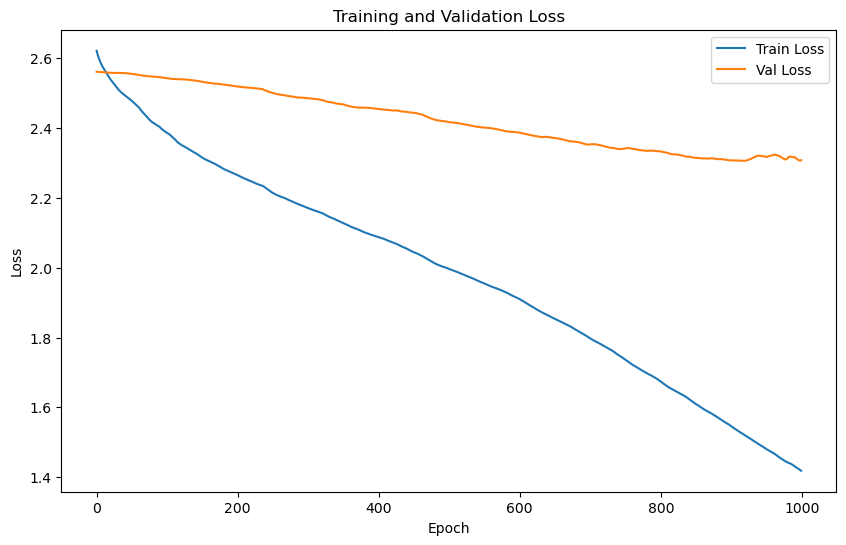

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 2.1910 | Test Accuracy: 44.68%


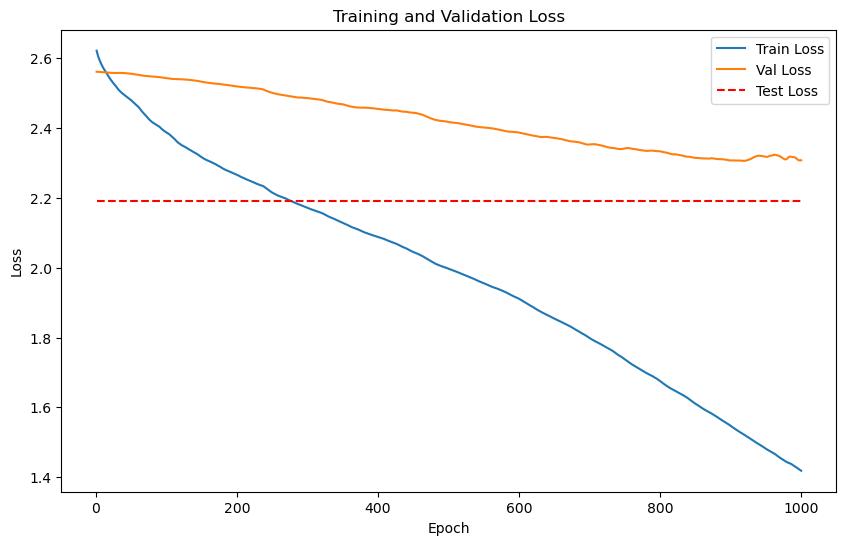

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


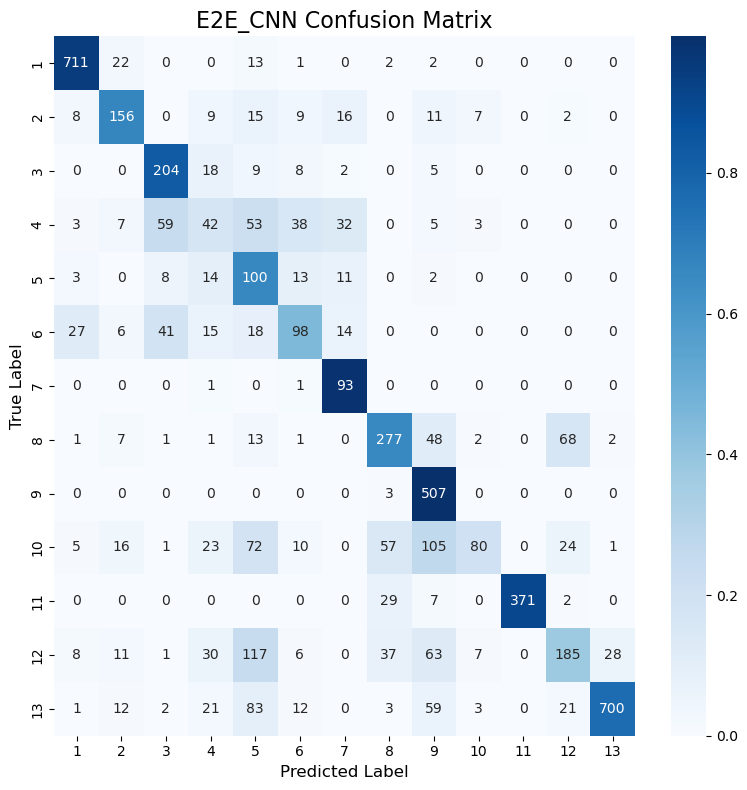

Classification Accuracy: 69.36%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


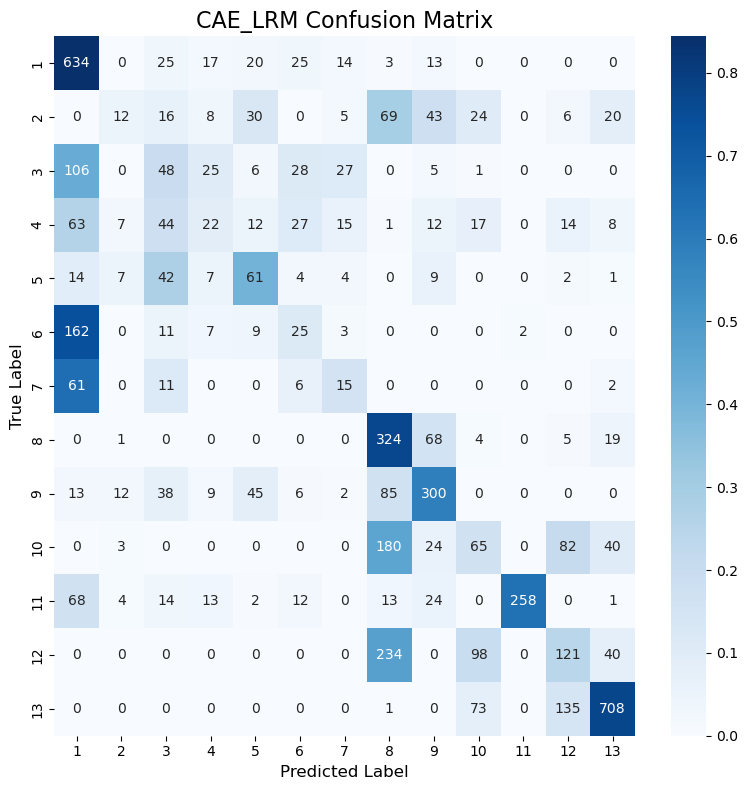

Classification Accuracy: 51.03%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


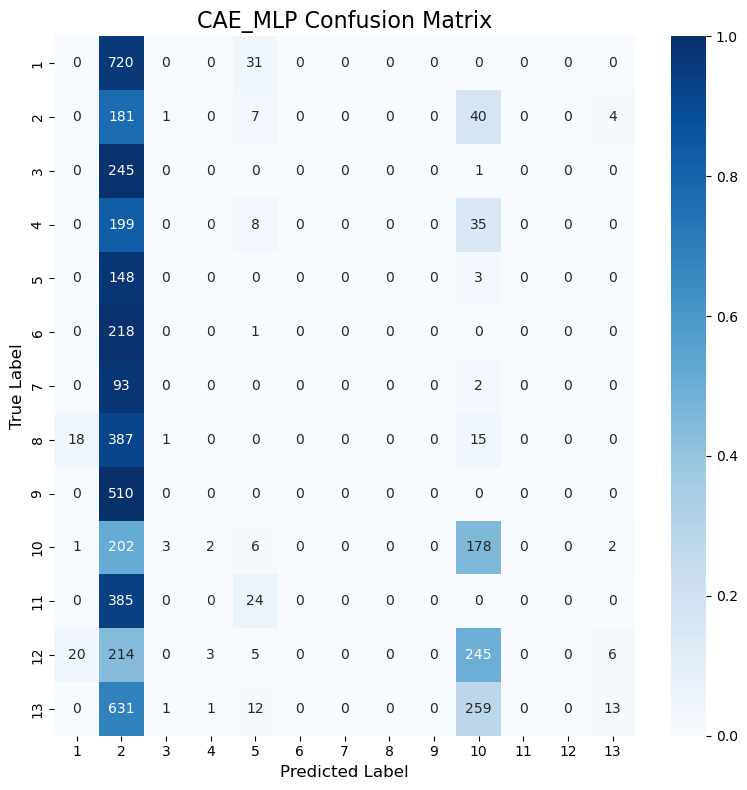

Classification Accuracy: 7.32%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


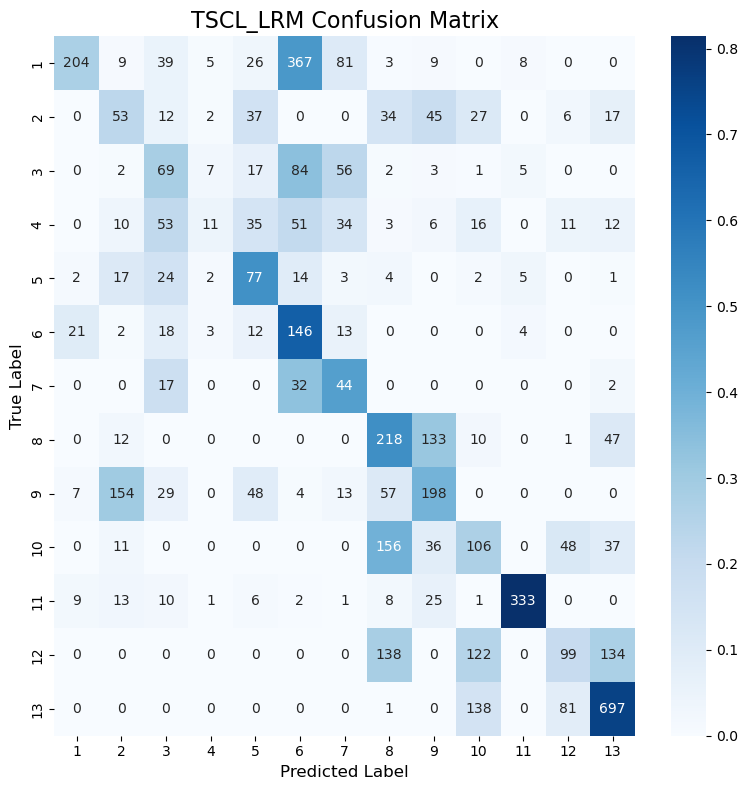

Classification Accuracy: 44.38%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


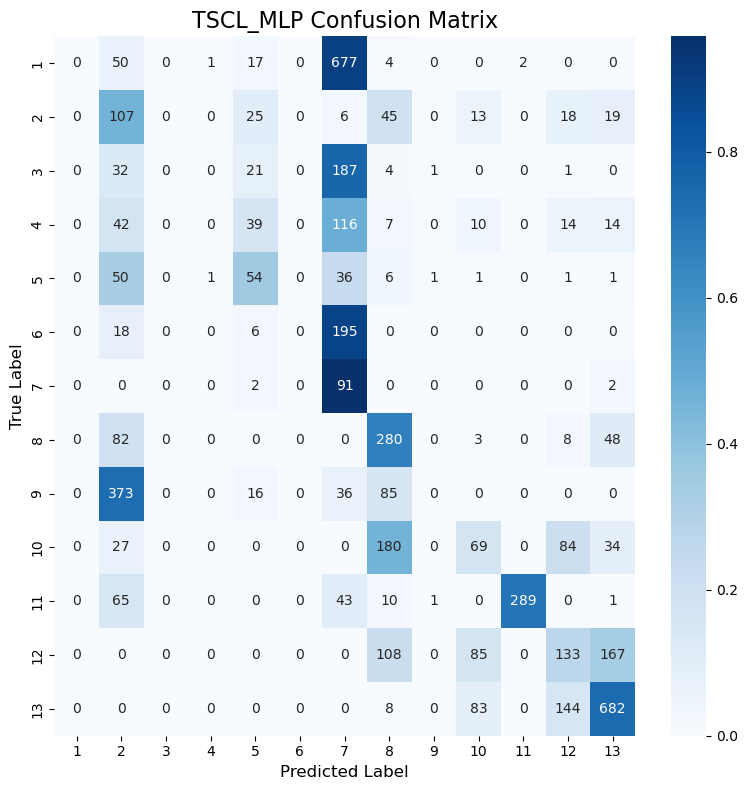

Classification Accuracy: 33.56%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


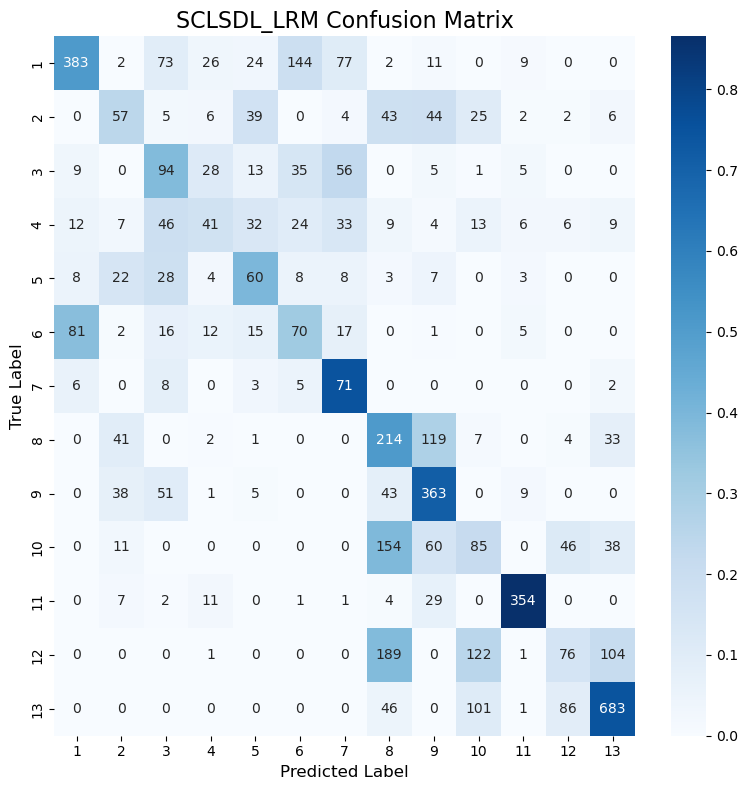

Classification Accuracy: 50.21%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


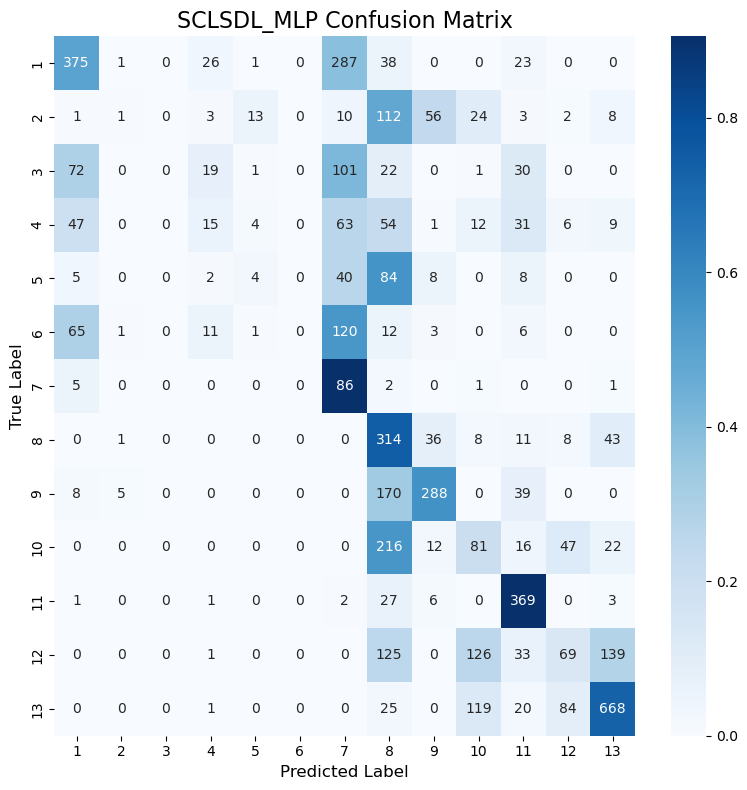

Classification Accuracy: 44.68%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          69.36
1    LRM (CAE)          51.03
2    MLP (CAE)           7.32
3     TSCL LRM          44.38
4     TSCL MLP          33.56
5  SCL_SDL LRM          50.21
6  SCL_SDL MLP          44.68

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          69.36
1    LRM (CAE)          51.03
5  SCL_SDL LRM          50.21
6  SCL_SDL MLP          44.68
3     TSCL LRM          44.38
4     TSCL MLP          33.56
2    MLP (CAE)           7.32
